In [1]:
import numpy as np
import matplotlib.pyplot as plt
import CorrPy as cp
from tqdm import tqdm
# import seaborn as sns
# from scipy.stats import bootstrap
# from sklearn.model_selection import train_test_split
plt.rcParams['figure.dpi'] = 150

# Define a constant to recalculate median absolute deviation to standard deviation
const = 1.4826

markers = ['o', 'd', '>', '<', 'P', 'v']

Synthetic data.
Let's find the best fitting region according to the paper "Power-Law Distributions in Empirical Data" by Clauset et al. (DOI: 10.1137/070710111) in Section 3.3.

In [2]:
def selfAffineExponent(delta, H, gamma_start = 0, psi_end=0.8, interpolationFactor=1):
    """
    Description:
    This function estimates the self-affine exponent.

    Parameters:
    :delta is equal to discretization. It is determined as delta = L/n
    where, L is profile's length and n is a number of points.
    :H is the normalised Hurst function. It should have a form of an
    one-dimensional array.
    :gamma_start is a parameter which controls the initial point of the
    fitting region as l_orig = gamma_start*xi.
    :psi_end is a parameter which controls the end point of the fitting
    region as l_end = psi_end*xi.
    :interpolationFactor is a constant which controls number of points in
    interpolation.

    Note:
    :The correlation length xi is defined as H >= np.sqrt(1-1/2.71), for more
    details see DOI: 10.1103/PhysRevE.110.064143.

    Return:
    It returns values of the amplitude a and a self-affine exponent alpha, i.e.
    r = a*X^alpha.    
    """
    H = H[~np.isnan(H)]
    
    if len(H) > 4 and gamma_start < len(H):
        # HOrig = H
        # Interpolate the Hurst function if it is needed
        if interpolationFactor > 1:
            X = delta*np.linspace(0, len(H) - 1, len(H))
            X, H = cp.fitData(delta, X, H, interpPoints=int(interpolationFactor*len(H)))

        # Find where to cut the curve and cut it.
        pos = np.where(H >= psi_end*0.7943) # pos = np.where(H >= np.sqrt(1-1/2.71))
        pos_0 = np.where(H >= gamma_start*0.7943)
        
        if not pos or not pos_0:
            return np.nan, np.nan
            
        H = H[pos_0[0][0]:pos[0][1]]

        
        # Generate the length scale
        # delta /= interpolationFactor
        X = (delta/interpolationFactor)*np.linspace(0, len(H) - 1, len(H))

        try:
            popt, pcov = cp.curve_fit(cp.powerlaw, X, H, (0.1, 0.5))
        except:
            return np.nan, np.nan
        if np.any(pcov == np.inf) or popt[-1] < 1e-2:
            # print("!")
            return np.nan, np.nan
        else:
            return popt
    else:
        return np.nan, np.nan

In [3]:
def genData(alphaIn=0.5, xiIn=10, deltaXiIn=0.01):
    deltaIn = deltaXiIn*xiIn
    numberOfProfiles = 100

    # lengthIn = 300*xiIn
    lengthIn = 100*xiIn
    # lengthIn = 50*xiIn

    # Generate profiles
    xiRef, PWT = cp.profileGenerator(alpha=alphaIn, omega=1, xi=xiIn, delta=deltaIn,
                                length=lengthIn, N=numberOfProfiles)


    ####################################################################
    # Calculate the autocorrelation and Hurst functions
    step=20*xiIn

    # Calculate the autocorrelation function
    A, IW = cp.GrowingWindow(start=lengthIn - step, stop=lengthIn, step=step, Profiles=PWT,
                                delta=deltaIn, method='acf', deviation='std')
        
    # Calculate the Hurst function
    H = np.sqrt(1 - A)


    ####################################################################
    # Print a number of windows
    # print('A.shape: ', A.shape)

    # Extract only from the last window
    T = A[:,-1,:]
    # print('T.shape: ', T.shape)

    # Calculate the Hurst function
    H = np.sqrt(1 - T)
    # print('H.shape: ', H.shape)
    return H

In [4]:
# Define a set of cut-offs (x_min) as coef*xi
# gamma_start_lst = np.linspace(0, 0.3, 4)
# psi_end_lst = np.linspace(.4, 1.3, 25)

# Only for fit
gamma_start_lst = [0]
psi_end_lst = np.linspace(.4, 1., 25)

In [7]:
# Input parameters
alphaIn = 0.7
xiIn = 10

# deltaXiIn = 0.005
deltaXiIn = 0.01
# deltaXiIn = 0.02

deltaIn = deltaXiIn*xiIn

H = genData(alphaIn=alphaIn, xiIn=xiIn, deltaXiIn=deltaXiIn)

# 

interpFactor = 1

errorFLst = []
alphaFLst = []
alphaFMADLst = []


for gamma_start in gamma_start_lst:
    errorLst = []
    alphaLst = []
    alphaMADLst = []
    for psi_end in psi_end_lst:
        alphaN = []
        for profNumber in range(0, 100):
            amp, alpha = selfAffineExponent(deltaIn, H[:, profNumber],
                                                gamma_start=gamma_start,
                                                psi_end=psi_end,
                                                interpolationFactor=interpFactor)
            # alphaN.append(alpha)
            alphaN.append(alpha)#/correctionFactor(psi=psi_end, gamma=0.1))

        if sum(~np.isnan(alphaN)) < 15:
            errorLst.append(np.nan)
            alphaLst.append(np.nan)
            alphaMADLst.append(np.nan)
        else:
            errorLst.append(cp.errorRel(np.nanmedian(alphaN), alphaIn))
            alphaLst.append(np.nanmedian(alphaN))
            alphaMADLst.append(const*cp.mad(alphaN, nan_policy='omit'))

    errorFLst.append(errorLst)
    alphaFLst.append(alphaLst)
    alphaFMADLst.append(alphaMADLst)


print(f"alpha: {alphaIn}")
print(f"delta_xi: {deltaXiIn}")
# Just to copy output

if alphaIn == 0.3:
    alphaFLst_03 = alphaFLst
    alphaFMADLst_03 = alphaFMADLst
    error_03 = errorFLst
elif alphaIn == 0.5:
    alphaFLst_05 = alphaFLst
    alphaFMADLst_05 = alphaFMADLst
    error_05 = errorFLst
elif alphaIn == 0.7:
    alphaFLst_07 = alphaFLst
    alphaFMADLst_07 = alphaFMADLst
    error_07 = errorFLst

# if xiIn == 10:
#     alphaFLst_10 = alphaFLst
#     alphaFMADLst_10 = alphaFMADLst
#     error_10 = errorFLst
# elif xiIn == 30:
#     alphaFLst_30 = alphaFLst
#     alphaFMADLst_30 = alphaFMADLst
#     error_30 = errorFLst
# elif xiIn == 50:
#     alphaFLst_50 = alphaFLst
#     alphaFMADLst_50 = alphaFMADLst
#     error_50 = errorFLst

# if deltaXiIn == 0.01:
#     error_001 = errorFLst
# elif deltaXiIn == 0.02:
#     error_002 = errorFLst
# elif deltaXiIn == 0.005:
#     error_005 = errorFLst

alpha: 0.7
delta_xi: 0.01


In [11]:
# for i, j, k, l in zip(alphaFLst, alphaFMADLst, markers, gamma_start_lst):
#     plt.errorbar(psi_end_lst, i, j, capsize=6, marker=k, linestyle='--', label=fr'$\gamma$ = {l:.1f}')
# plt.ylabel(r'$\hat{\alpha}$', fontsize="18")
# plt.xlabel(r'$\psi$', fontsize="18")
# plt.tick_params(axis='both', labelsize=15)
# plt.legend(fontsize="18", ncol=2)
# plt.grid()
# # plt.savefig(f"./images/valAlpha_{interpFactor}/alphaIn_{alphaIn}_deltaXi_{deltaXiIn}.png", format="png", bbox_inches="tight", dpi=300)
# plt.show()

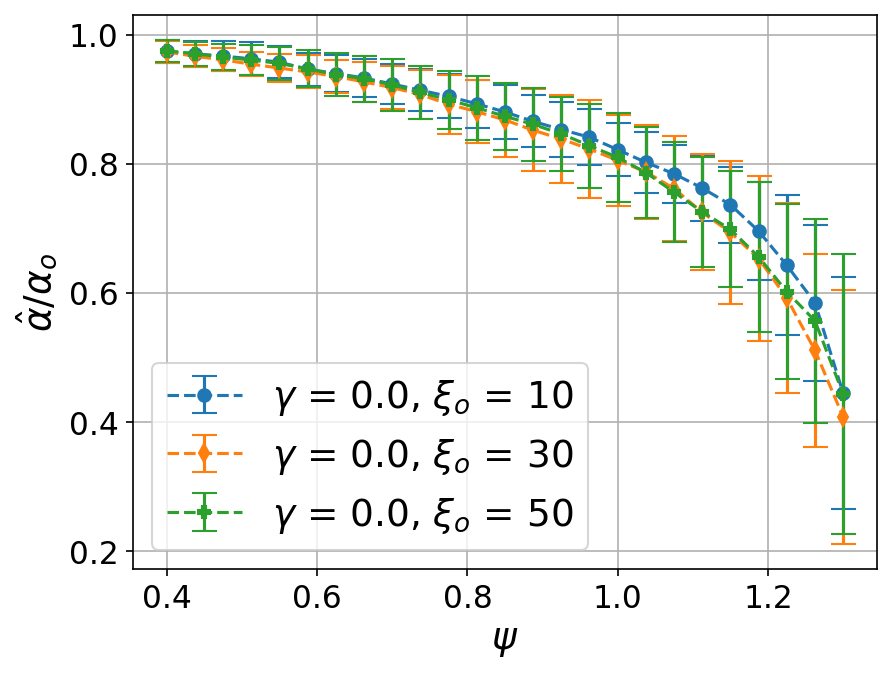

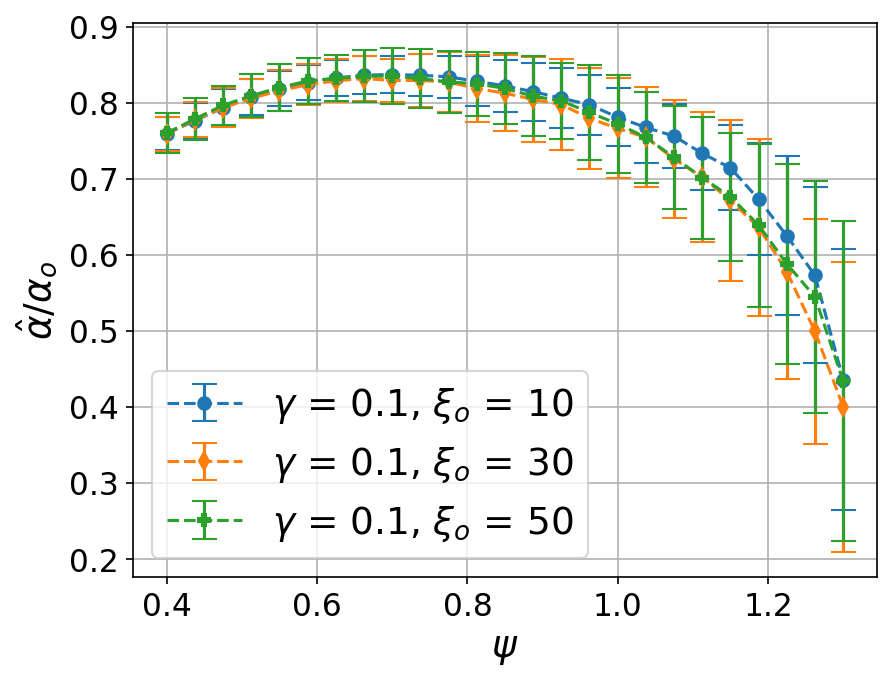

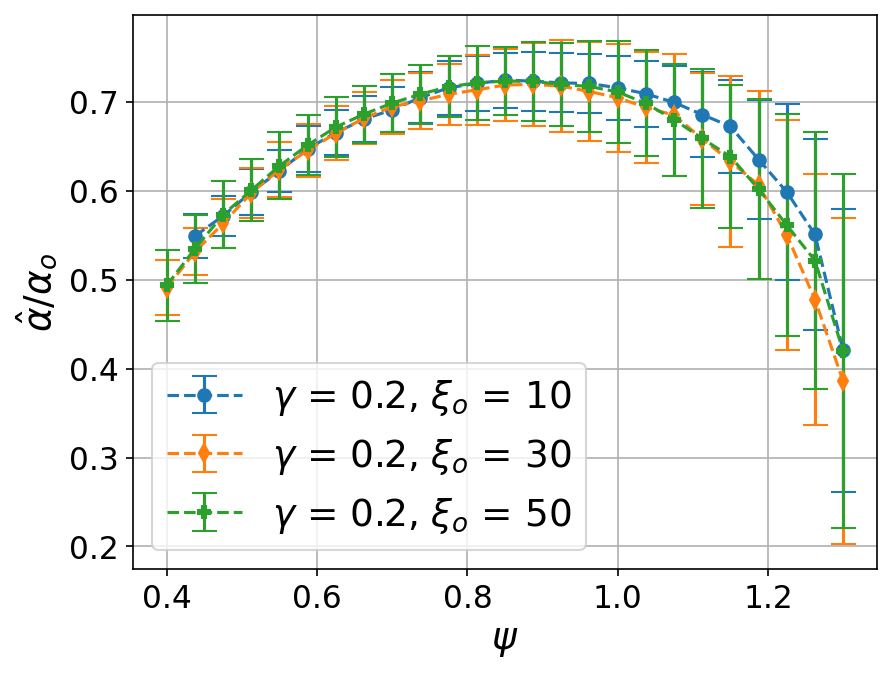

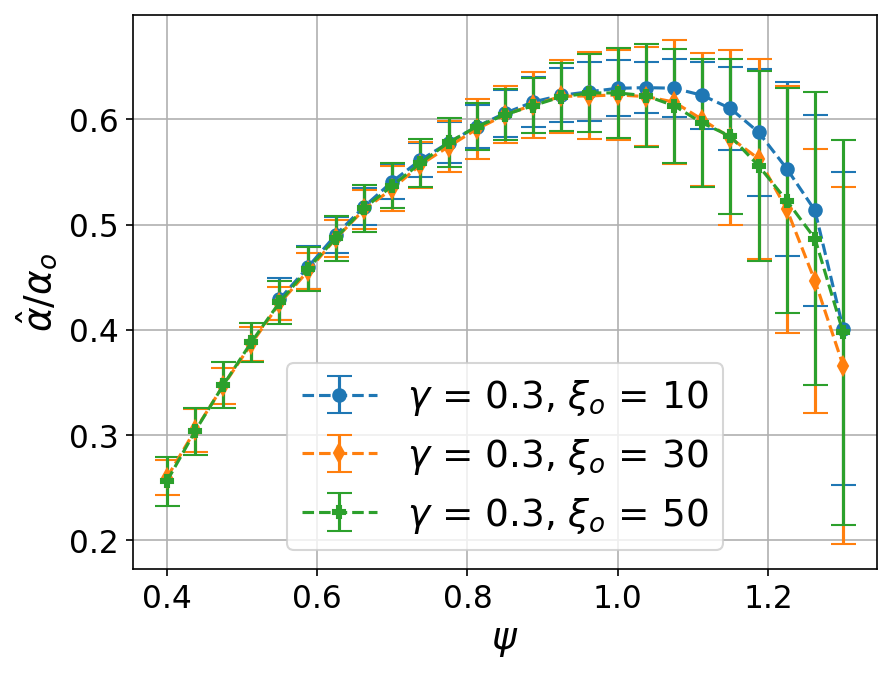

In [10]:
for r in range(4):
    colors = ('tab:blue', 'tab:orange', 'tab:green', 'tab:red')

    for i, ii, j, jj, f, ff, k, l, c in zip(alphaFLst_10[r:r+1], alphaFMADLst_10[r:r+1], alphaFLst_30[r:r+1], alphaFMADLst_30[r:r+1],
                                alphaFLst_50[r:r+1], alphaFMADLst_50[r:r+1], markers, gamma_start_lst[r:r+1], colors):
        plt.errorbar(psi_end_lst, np.divide(i, 0.5), np.divide(ii, 0.5), marker='o', capsize=6, linestyle='--', label=fr'$\gamma$ = {l:.1f}, $\xi_o$ = 10')
        plt.errorbar(psi_end_lst, np.divide(j, 0.5), np.divide(jj, 0.5), marker='d', capsize=6, linestyle='--', label=fr'$\gamma$ = {l:.1f}, $\xi_o$ = 30')
        plt.errorbar(psi_end_lst, np.divide(f, 0.5), np.divide(ff, 0.5), marker='P', capsize=6, linestyle='--', label=fr'$\gamma$ = {l:.1f}, $\xi_o$ = 50')
    plt.ylabel(r'$\hat{\alpha}/\alpha_o$', fontsize="18")
    plt.xlabel(r'$\psi$', fontsize="18")
    plt.tick_params(axis='both', labelsize=15)
    plt.legend(fontsize="18", ncol=1)
    plt.grid()
    plt.savefig(f"./images/valAlpha_{interpFactor}/AlphaOverAlpha_gamma_{l:.1f}_deltaXi_{deltaXiIn}_alpha_{alphaIn}.png", format="png", bbox_inches="tight", dpi=300)
    plt.show()

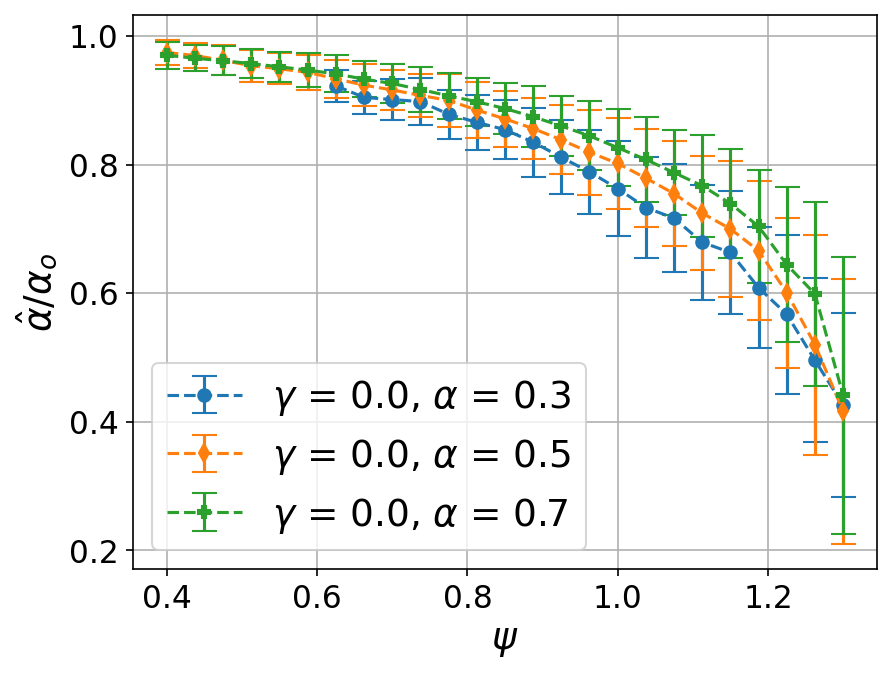

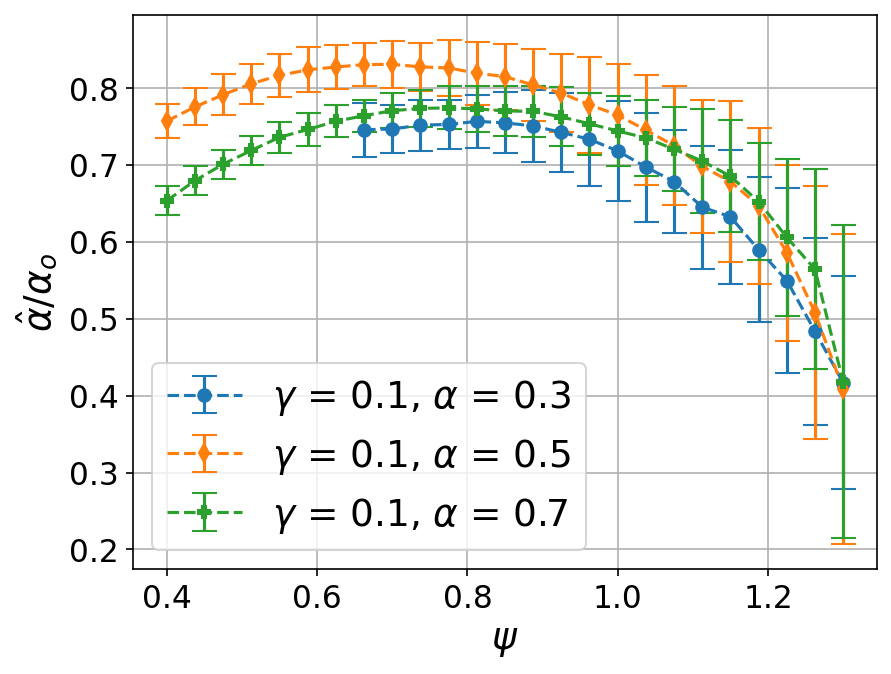

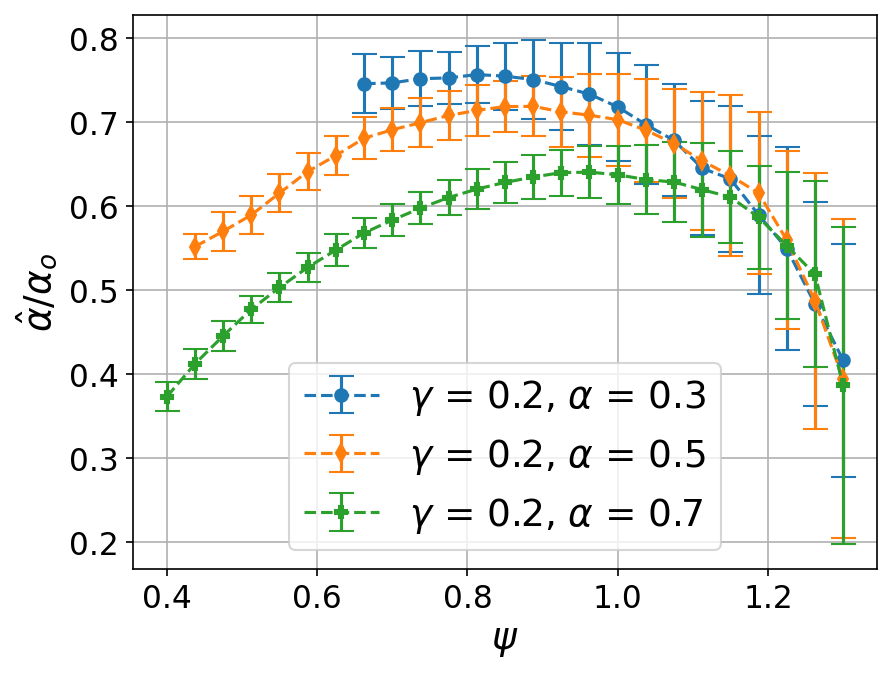

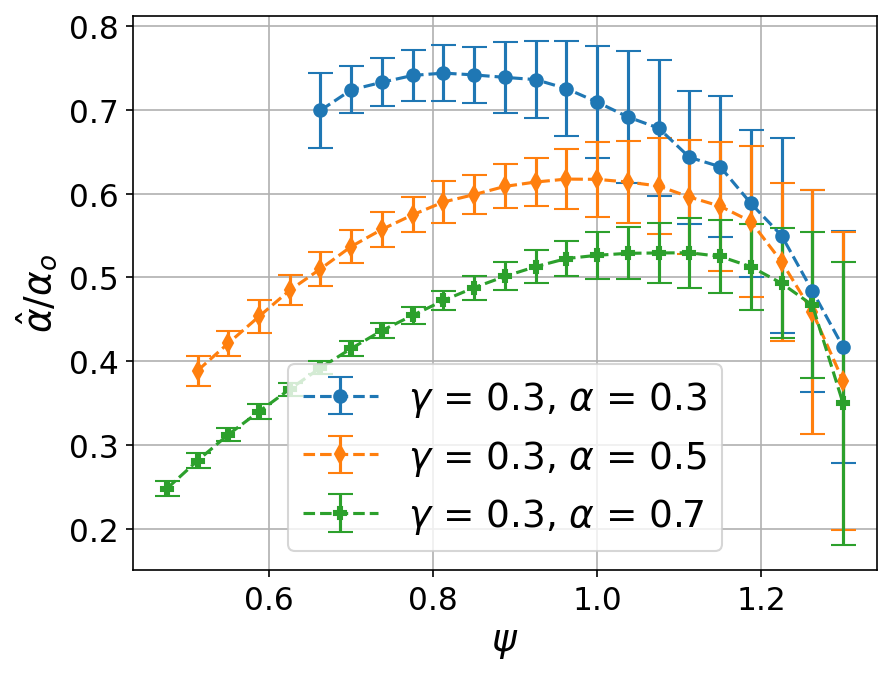

In [9]:
for r in range(4):
    colors = ('tab:blue', 'tab:orange', 'tab:green', 'tab:red')

    for i, ii, j, jj, f, ff, k, l, c in zip(alphaFLst_03[r:r+1], alphaFMADLst_03[r:r+1], alphaFLst_05[r:r+1], alphaFMADLst_05[r:r+1],
                                alphaFLst_07[r:r+1], alphaFMADLst_07[r:r+1], markers, gamma_start_lst[r:r+1], colors):
        plt.errorbar(psi_end_lst, np.divide(i, 0.3), np.divide(ii, 0.3), marker='o', capsize=6, linestyle='--', label=fr'$\gamma$ = {l:.1f}, $\alpha$ = 0.3')
        plt.errorbar(psi_end_lst, np.divide(j, 0.5), np.divide(jj, 0.5), marker='d', capsize=6, linestyle='--', label=fr'$\gamma$ = {l:.1f}, $\alpha$ = 0.5')
        plt.errorbar(psi_end_lst, np.divide(f, 0.7), np.divide(ff, 0.7), marker='P', capsize=6, linestyle='--', label=fr'$\gamma$ = {l:.1f}, $\alpha$ = 0.7')
    plt.ylabel(r'$\hat{\alpha}/\alpha_o$', fontsize="18")
    plt.xlabel(r'$\psi$', fontsize="18")
    plt.tick_params(axis='both', labelsize=15)
    plt.legend(fontsize="18", ncol=1)
    plt.grid()
    plt.savefig(f"./images/valAlpha_{interpFactor}/AlphaOverAlpha_gamma_{l:.1f}_deltaXi_{deltaXiIn}.png", format="png", bbox_inches="tight", dpi=300)
    plt.show()

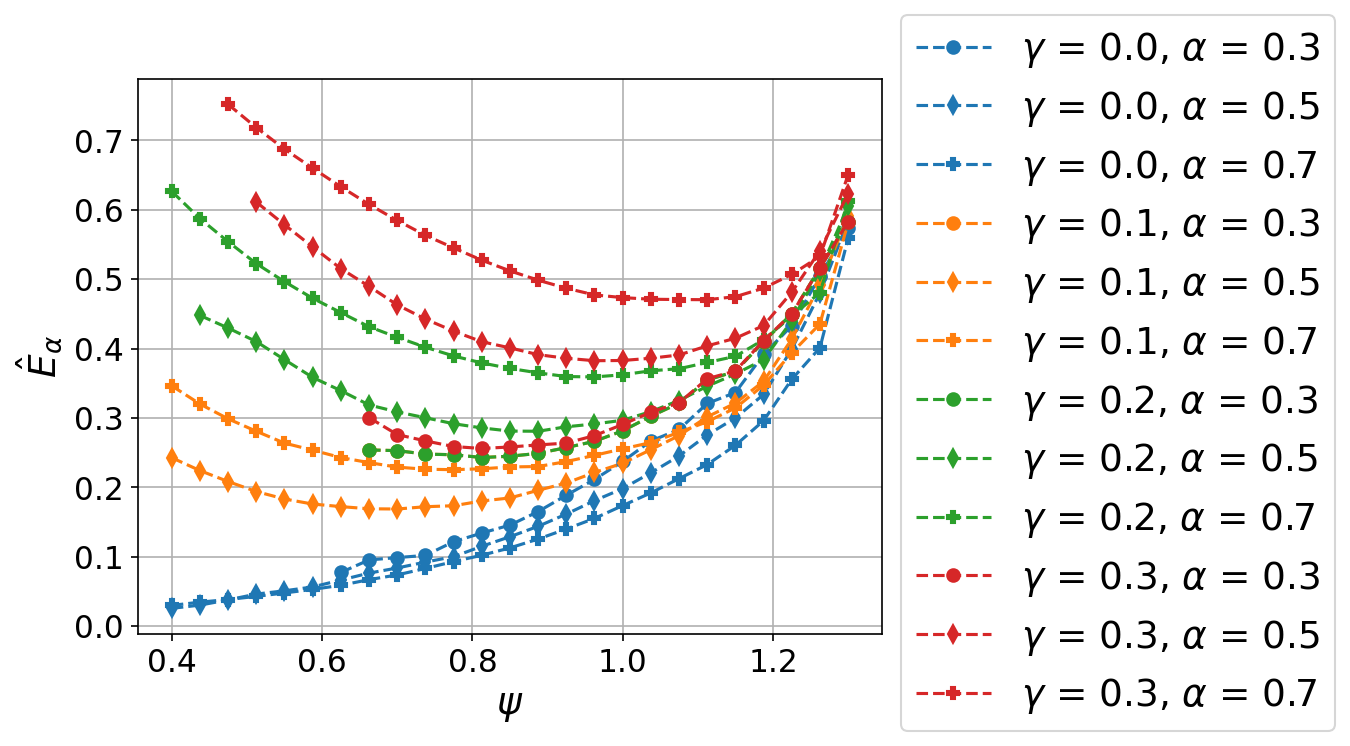

In [10]:
colors = ('tab:blue', 'tab:orange', 'tab:green', 'tab:red')

for i, j, f, k, l, c in zip(error_03, error_05, error_07, markers, gamma_start_lst, colors):
    plt.plot(psi_end_lst, i, marker='o', linestyle='--', label=fr'$\gamma$ = {l:.1f}, $\alpha$ = 0.3', color=c)
    plt.plot(psi_end_lst, j, marker='d', linestyle='--', label=fr'$\gamma$ = {l:.1f}, $\alpha$ = 0.5', color=c)
    plt.plot(psi_end_lst, f, marker='P', linestyle='--', label=fr'$\gamma$ = {l:.1f}, $\alpha$ = 0.7', color=c)
plt.ylabel(r'$\hat{E}_{\alpha}$', fontsize="18")
plt.xlabel(r'$\psi$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize="18", ncol=1, bbox_to_anchor=(1, 1.15))
plt.grid()
plt.savefig(f"./images/valAlpha_{interpFactor}/E_gamma_deltaXi_{deltaXiIn}.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

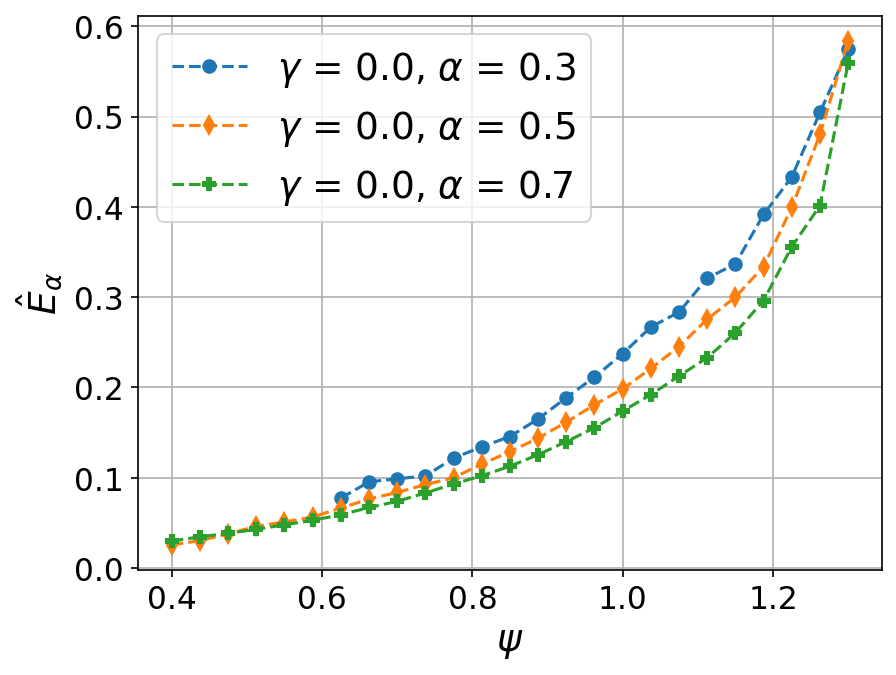

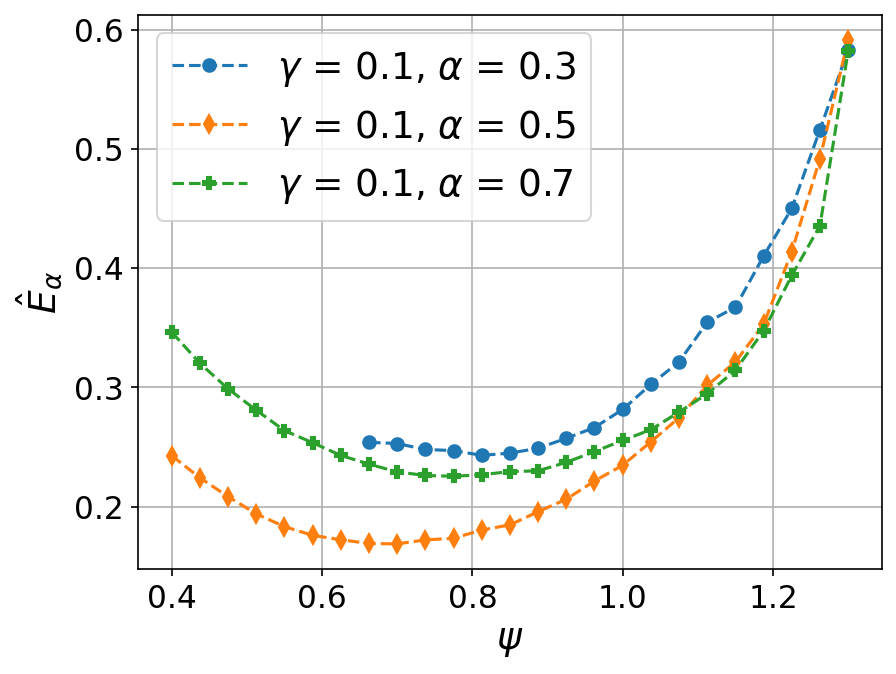

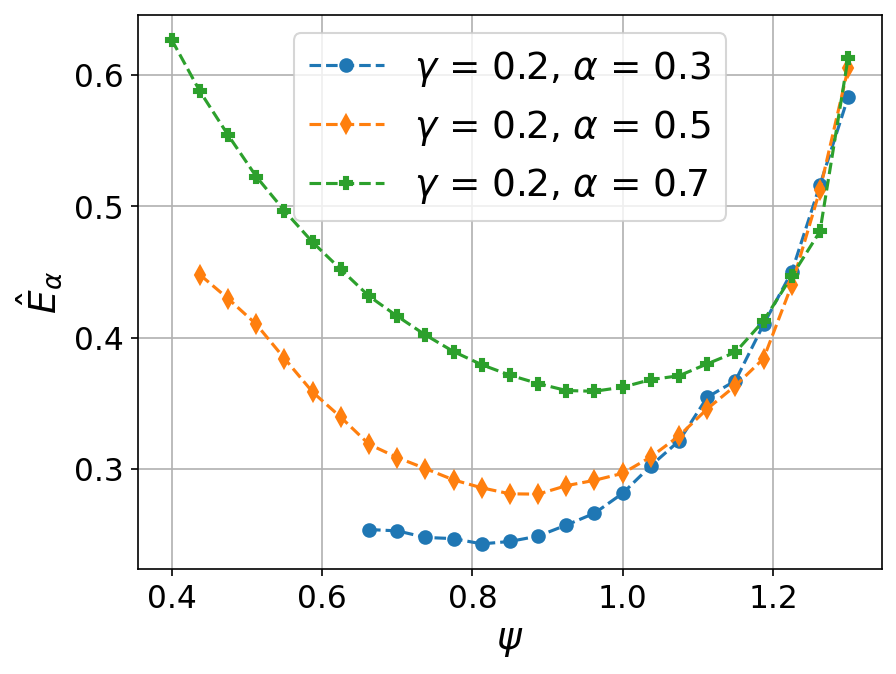

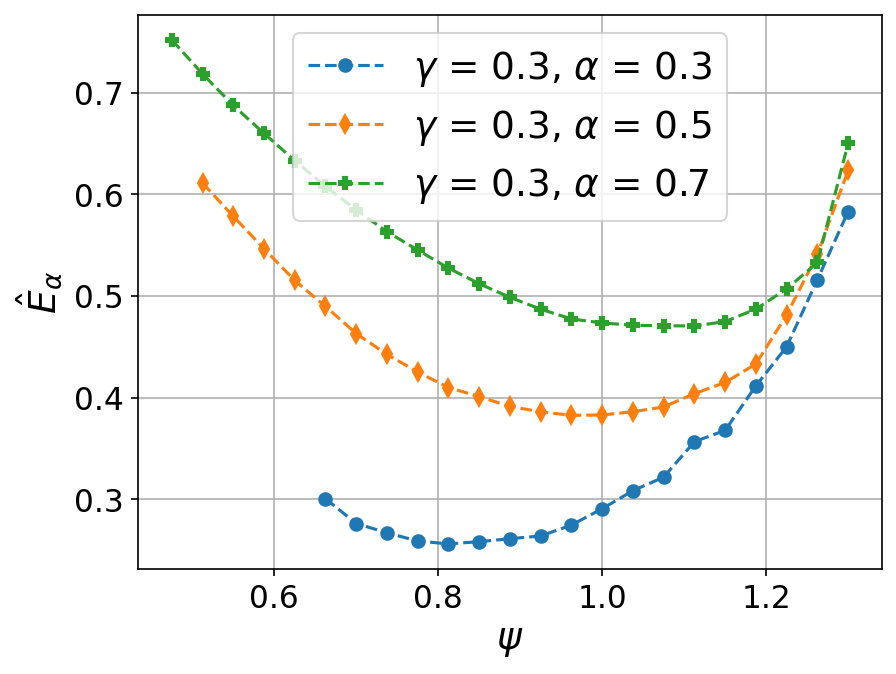

In [11]:
for st in range(4):
    lim = st + 1
    colors = ('tab:blue', 'tab:orange', 'tab:green', 'tab:red')

    for i, j, f, k, l in zip(error_03[st:lim], error_05[st:lim], error_07[st:lim], markers, gamma_start_lst[st:lim]):
        plt.plot(psi_end_lst, i, marker='o', linestyle='--', label=fr'$\gamma$ = {l:.1f}, $\alpha$ = 0.3')
        plt.plot(psi_end_lst, j, marker='d', linestyle='--', label=fr'$\gamma$ = {l:.1f}, $\alpha$ = 0.5')
        plt.plot(psi_end_lst, f, marker='P', linestyle='--', label=fr'$\gamma$ = {l:.1f}, $\alpha$ = 0.7')
    plt.ylabel(r'$\hat{E}_{\alpha}$', fontsize="18")
    plt.xlabel(r'$\psi$', fontsize="18")
    plt.tick_params(axis='both', labelsize=15)
    plt.legend(fontsize="18", ncol=1)#, bbox_to_anchor=(1, 1.15))
    plt.grid()
    plt.savefig(f"./images/valAlpha_{interpFactor}/E_gamma_{l:.1f}_deltaXi_{deltaXiIn}.png", format="png", bbox_inches="tight", dpi=300)
    plt.show()

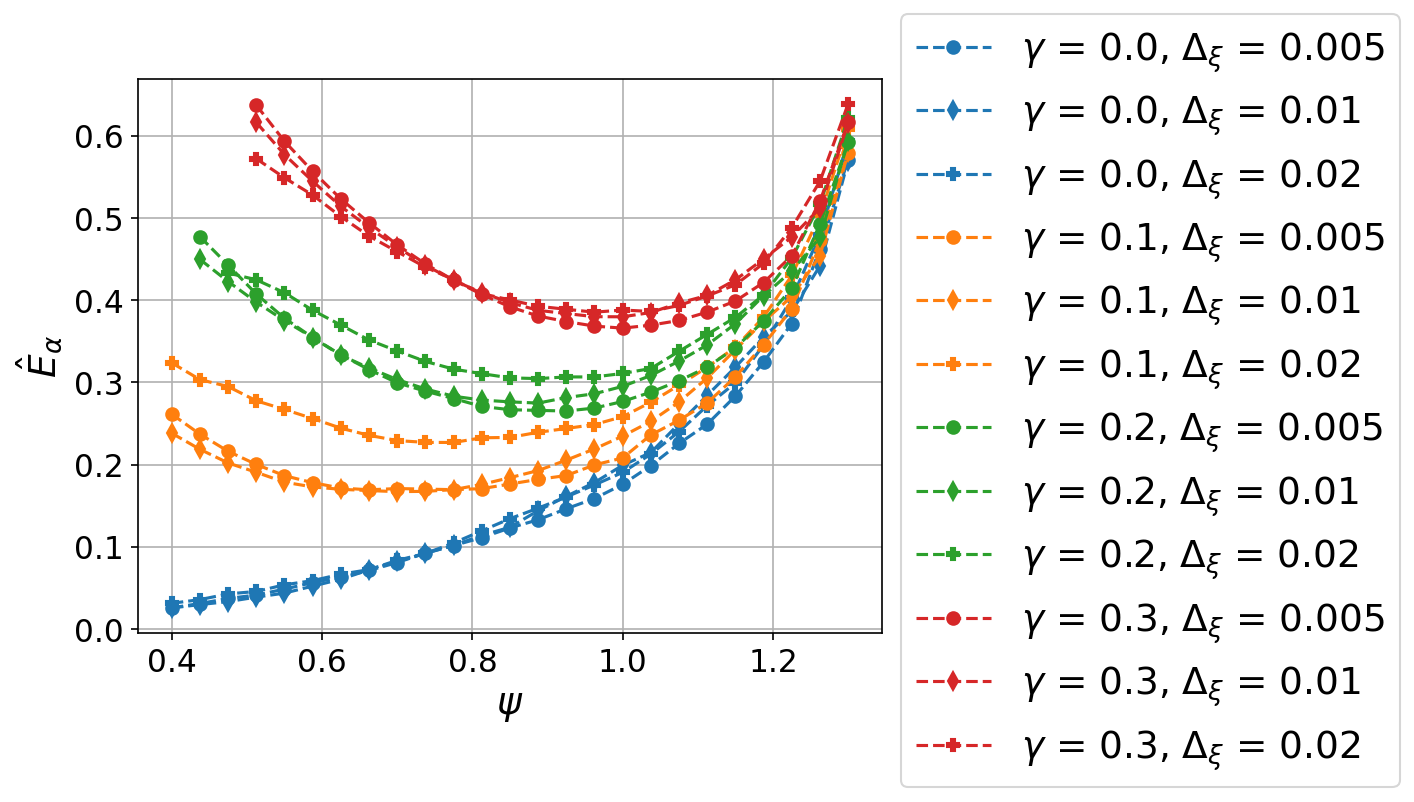

In [10]:
colors = ('tab:blue', 'tab:orange', 'tab:green', 'tab:red')

for i, j, f, k, l, c in zip(error_005, error_001, error_002, markers, gamma_start_lst, colors):
    plt.plot(psi_end_lst, i, marker='o', linestyle='--', label=fr'$\gamma$ = {l:.1f}, $\Delta_{{\xi}}$ = 0.005', color=c)
    plt.plot(psi_end_lst, j, marker='d', linestyle='--', label=fr'$\gamma$ = {l:.1f}, $\Delta_{{\xi}}$ = 0.01', color=c)
    plt.plot(psi_end_lst, f, marker='P', linestyle='--', label=fr'$\gamma$ = {l:.1f}, $\Delta_{{\xi}}$ = 0.02', color=c)
plt.ylabel(r'$\hat{E}_{\alpha}$', fontsize="18")
plt.xlabel(r'$\psi$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize="18", ncol=1, bbox_to_anchor=(1, 1.15))
plt.grid()
plt.savefig(f"./images/valAlpha_{interpFactor}/E_gamma_various_deltaXi_alpha_{alphaIn}.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

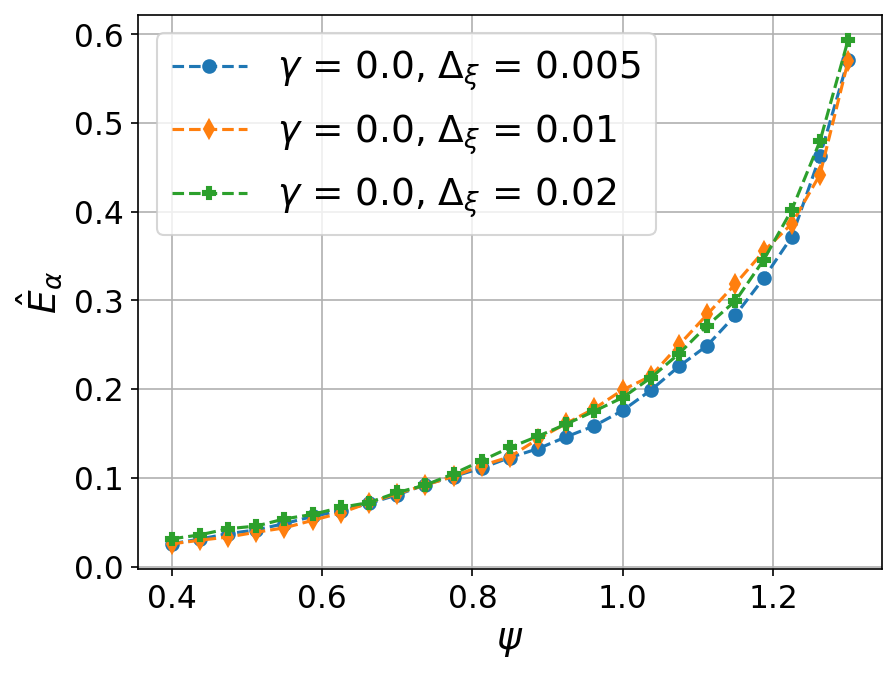

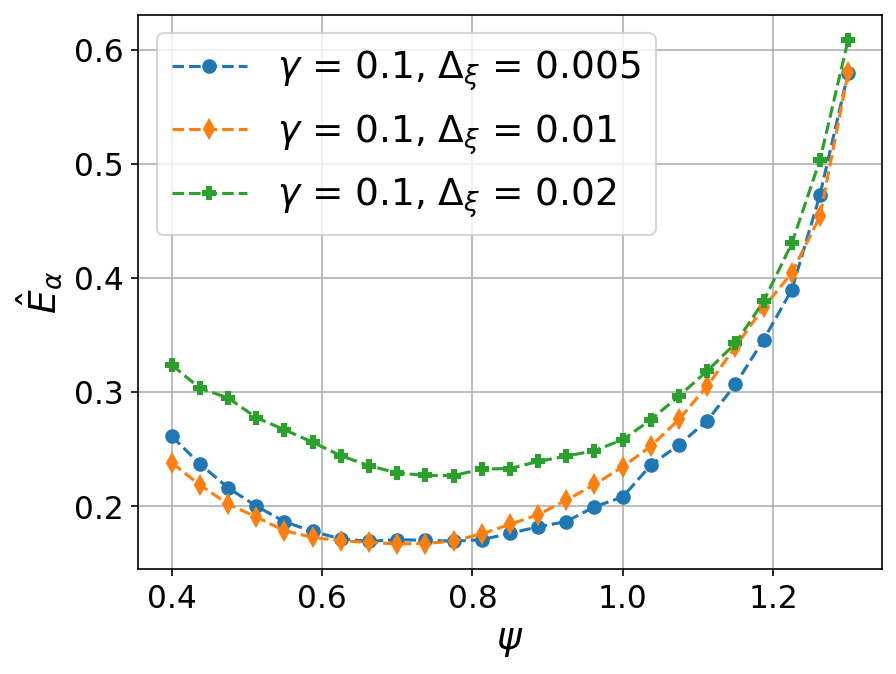

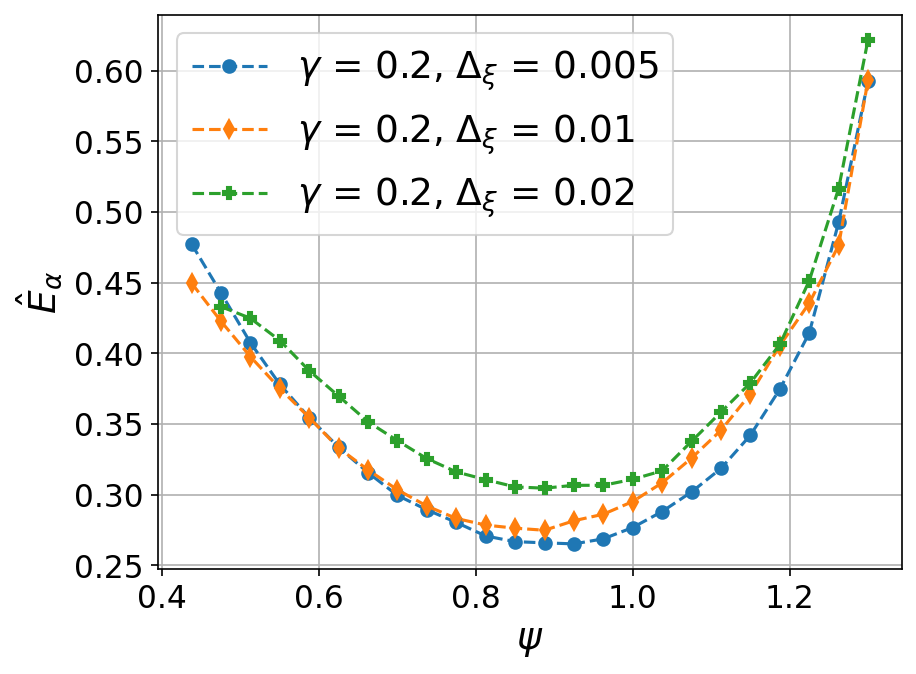

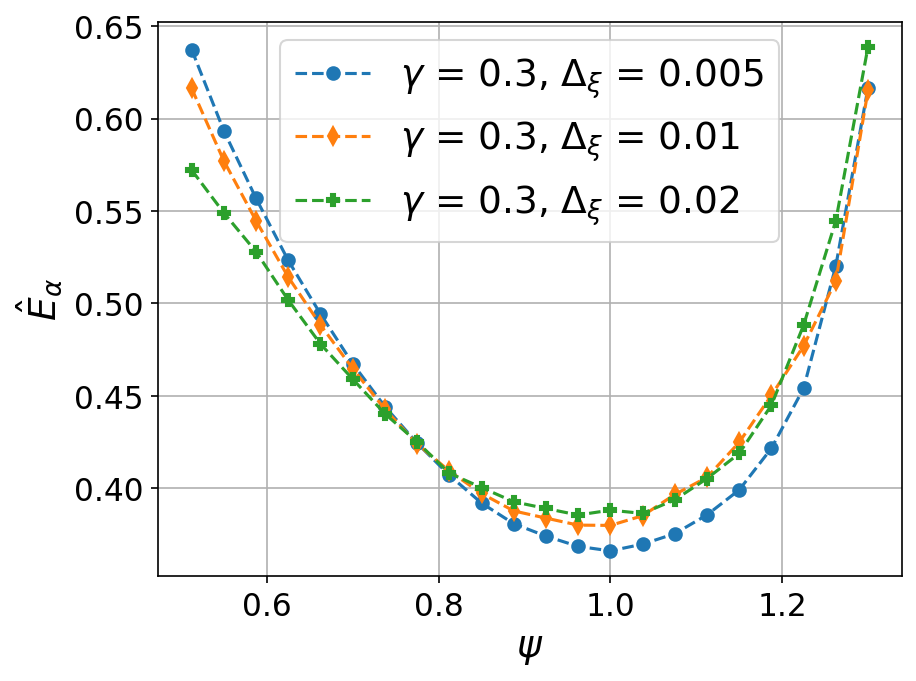

In [11]:
for st in range(4):
    lim = st + 1
    colors = ('tab:blue', 'tab:orange', 'tab:green', 'tab:red')

    for i, j, f, k, l in zip(error_005[st:lim], error_001[st:lim], error_002[st:lim], markers, gamma_start_lst[st:lim]):
        plt.plot(psi_end_lst, i, marker='o', linestyle='--', label=fr'$\gamma$ = {l:.1f}, $\Delta_{{\xi}}$ = 0.005')
        plt.plot(psi_end_lst, j, marker='d', linestyle='--', label=fr'$\gamma$ = {l:.1f}, $\Delta_{{\xi}}$ = 0.01')
        plt.plot(psi_end_lst, f, marker='P', linestyle='--', label=fr'$\gamma$ = {l:.1f}, $\Delta_{{\xi}}$ = 0.02')
    plt.ylabel(r'$\hat{E}_{\alpha}$', fontsize="18")
    plt.xlabel(r'$\psi$', fontsize="18")
    plt.tick_params(axis='both', labelsize=15)
    plt.legend(fontsize="18", ncol=1)#, bbox_to_anchor=(1, 1.15))
    plt.grid()
    plt.savefig(f"./images/valAlpha_{interpFactor}/E_gamma_{l:.1f}_deltaXi_various_alpha_{alphaIn}.png", format="png", bbox_inches="tight", dpi=300)
    plt.show()

Fit various alpha.

In [8]:
from scipy.stats import bootstrap

In [9]:
def powerLawConst(x, a, b):
    return a*x**b + 1

In [10]:
alphaLst = []
psiLst = []

lst = [alphaFLst_03, alphaFLst_05, alphaFLst_07]

for i, j in zip(lst, [0.3, 0.5, 0.7]):
    alphaLst.append(np.divide(i[0], j))
    psiLst.append(psi_end_lst)
else:
    alphaM = np.nanmedian(alphaLst, 0)
    alphaM = np.array(alphaM)
    alpha = np.array(alphaLst).reshape(75, 1)
    psi = np.array(psiLst).reshape(75, 1)

In [11]:
aLst = []
bLst = []
stdLst = []

X_train, X_test, Y_train, y_test = cp.train_test_split(psi, alpha, shuffle=True, test_size=0.2)

for i in range(10):
    x_train, _, y_train, _ = cp.train_test_split(X_train, Y_train, shuffle=True, test_size=0.2)

    popt, pcov = cp.curve_fit(powerLawConst, x_train[:, 0], y_train[:, 0], (0, 1), nan_policy='omit')

    score = np.nanstd(powerLawConst(X_test, *popt) - y_test)
    stdLst.append(score)
    # print(f"STD: {score:.4f}")

    aLst.append(popt[0])
    bLst.append(popt[1])
    res = powerLawConst(psi_end_lst, *popt)
    # print(f"a: {popt[0]:.4f}; b: {popt[1]:.4f}")

In [12]:
print(np.mean(aLst))
print(np.mean(bLst))
print(np.std(aLst))
print(np.std(bLst))

-0.19083239166589258
2.311786514759244
0.003313393056337602
0.06296002373707697


In [16]:
resA = bootstrap((aLst,), np.mean, confidence_level=0.95, n_resamples=50)
print(resA.confidence_interval)

ConfidenceInterval(low=-0.1928556086968604, high=-0.1891591081679753)


In [17]:
resB = bootstrap((bLst, ), np.mean, confidence_level=0.95, n_resamples=50)
print(resB.confidence_interval)

ConfidenceInterval(low=2.281715354642289, high=2.337513232209997)


In [26]:
popt = (-0.187, 2.312)

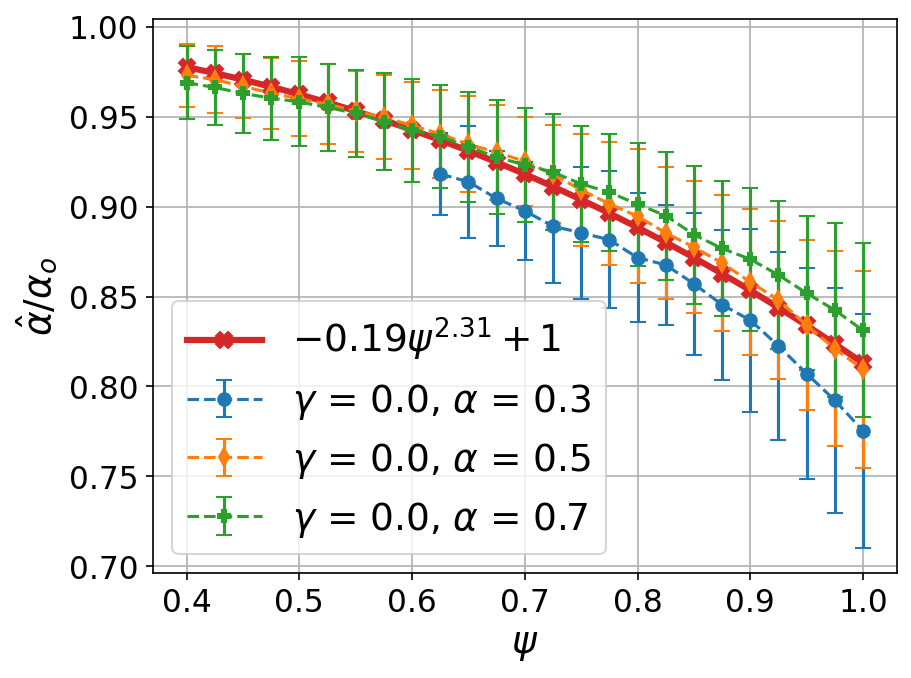

In [28]:
res = powerLawConst(psi_end_lst, *popt)

for r in range(1):
    colors = ('tab:blue', 'tab:orange', 'tab:green', 'tab:red')

    for i, ii, j, jj, f, ff, k, l, c in zip(alphaFLst_03[r:r+1], alphaFMADLst_03[r:r+1], alphaFLst_05[r:r+1], alphaFMADLst_05[r:r+1],
                                alphaFLst_07[r:r+1], alphaFMADLst_07[r:r+1], markers, gamma_start_lst[r:r+1], colors):
        plt.errorbar(psi_end_lst, np.divide(i, 0.3), np.divide(ii, 0.3), marker='o', capsize=4, linestyle='--', label=fr'$\gamma$ = {l:.1f}, $\alpha$ = 0.3')
        plt.errorbar(psi_end_lst, np.divide(j, 0.5), np.divide(jj, 0.5), marker='d', capsize=4, linestyle='--', label=fr'$\gamma$ = {l:.1f}, $\alpha$ = 0.5')
        plt.errorbar(psi_end_lst, np.divide(f, 0.7), np.divide(ff, 0.7), marker='P', capsize=4, linestyle='--', label=fr'$\gamma$ = {l:.1f}, $\alpha$ = 0.7')
    
    plt.plot(psi_end_lst, res, '-X', linewidth=3, markersize=8, label=rf'${popt[0]:.2f} \psi^{{{popt[1]:.2f}}} + 1$')
    plt.ylabel(r'$\hat{\alpha}/\alpha_o$', fontsize="18")
    plt.xlabel(r'$\psi$', fontsize="18")
    plt.tick_params(axis='both', labelsize=15)
    plt.legend(fontsize="18", ncol=1)
    plt.grid()
    plt.savefig(f"./images/fitPsi.png", format="png", bbox_inches="tight", dpi=300)
    plt.show()

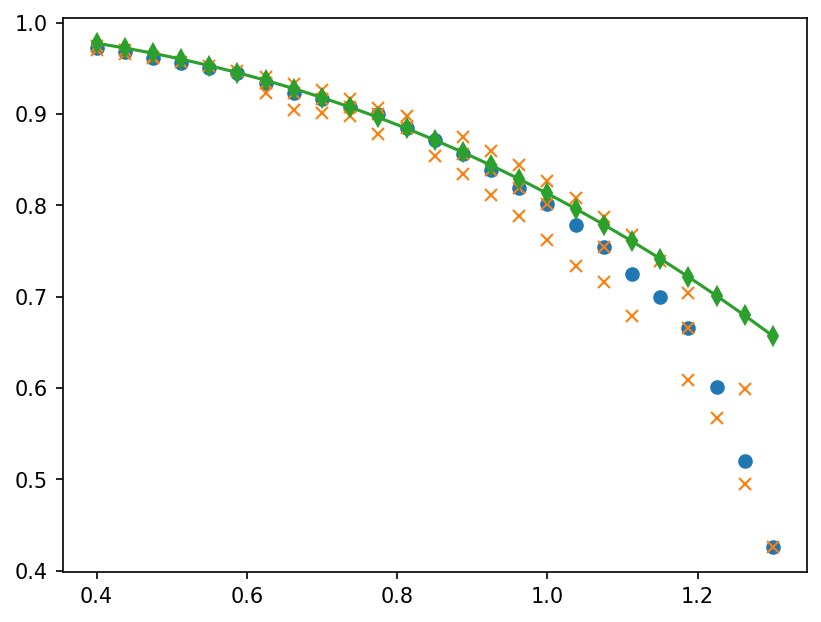

In [29]:
plt.plot(psi_end_lst, alphaM, 'o')
plt.plot(X_train, Y_train, 'x')
plt.plot(psi_end_lst, res, '-d')
plt.show()

In [189]:
popt

(-0.187, 2.312)

In [184]:
def correctionFactor(psi=0.8):
    return -0.187*psi**2.31 + 1

0.45/correctionFactor()

0.5065748045152311

Synthetic data.

Calculate the B-coefficient for various values of $n_{\xi}$ and at constant $\xi_p$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import CorrPy as cp
from tqdm import tqdm
# import seaborn as sns
# from scipy.stats import bootstrap
# from sklearn.model_selection import train_test_split
plt.rcParams['figure.dpi'] = 150

# Define a constant to recalculate median absolute deviation to standard deviation
const = 1.4826

markers = ['o', 'd', '>', '<', 'P', 'v']

In [18]:
# Control parameters
alphaIn = .5
numberOfProfiles = 100

# Initialize containers
xiMed = []
xiMAD = []
xiSTD = []

alphaMed = []
alphaMAD = []
alphaSTD = []

ExiMed = []
# ExiMAD = []

EalphaMed = []
# EalphaMAD = []

BMed = []
BMAD = []

xiIn = 10
# xiIn = 5
# step=20*xiIn
step=100
lengthIn = 300*xiIn

# step=2*xiIn
# lengthIn = 100*xiIn

deltaXiIn_ = [0.02, 0.01, 0.005]

for deltaXiIn in tqdm(deltaXiIn_):    
    deltaIn = deltaXiIn*xiIn 
    xiRef, PWT = cp.profileGenerator(alpha=alphaIn, omega=1, xi=xiIn, delta=deltaIn,
                            length=lengthIn, N=numberOfProfiles)

    # Subtract trend
    # PWT = cp.subtractTrend(dist, PWT, 'svr')

    # Calculate the autocorrelation function
    A, IW = cp.GrowingWindow(start=step, stop=lengthIn, step=step, Profiles=PWT,
                             delta=deltaIn, method='acf', deviation='std')
    
    # Calculate the Hurst function
    # H = np.sqrt(1 - A)
    
    # Calculate the lateral correlation length
    xi = cp.correlationLength(deltaIn, A)
        
    # Calculate the self-affine exponent
    # alpha = cp.selfAffineParameters(deltaIn, H, 'exponent', robust=False)
    alpha = cp.selfAffineParameters(deltaIn, np.sqrt(1 - A), 'exponent', robust=False)
    
    # Generate length scales at which the statistical functions
    # and the self-affine parameters were found
    X = np.linspace(step, lengthIn, len(xi)).reshape(-1,1)

    # Calculate median and median absolute deviation
    xiMed.append(np.nanmedian(xi, 1))
    xiMAD.append(cp.mad(xi, 1, nan_policy='omit'))
    xiSTD.append(np.nanstd(xi, axis=1))

    alphaMed.append(np.nanmedian(alpha, 1))
    alphaMAD.append(cp.mad(alpha, 1, nan_policy='omit'))
    alphaSTD.append(np.nanstd(alpha, axis=1))

    ExiMed.append(np.abs(xiRef - np.nanmedian(xi, 1))/xiRef)
    # ExiMAD.append(cp.mad(xi, 1, nan_policy='omit')/xiRef)

    EalphaMed.append(np.abs(alphaIn - np.nanmedian(alpha, 1))/alphaIn)
    # EalphaMAD.append(cp.mad(alpha, 1, nan_policy='omit')/alphaIn)

    # Calculate the B-coefficient
    B = X/xi;
    # B = np.sqrt(1/B)

    BMed.append(np.nanmedian(B, 1))
    BMAD.append(cp.mad(B, 1, nan_policy='omit'))

    del PWT, A, xi, alpha, B


  0%|          | 0/3 [00:00<?, ?it/s]/home/aleksandr/ownCloud/Data/First Study/Articles/PRL_UQ/Data/CorrPy.py:415: RuntimeWarning: divide by zero encountered in power
  return a*pow(x,b)
100%|██████████| 3/3 [02:50<00:00, 56.86s/it]


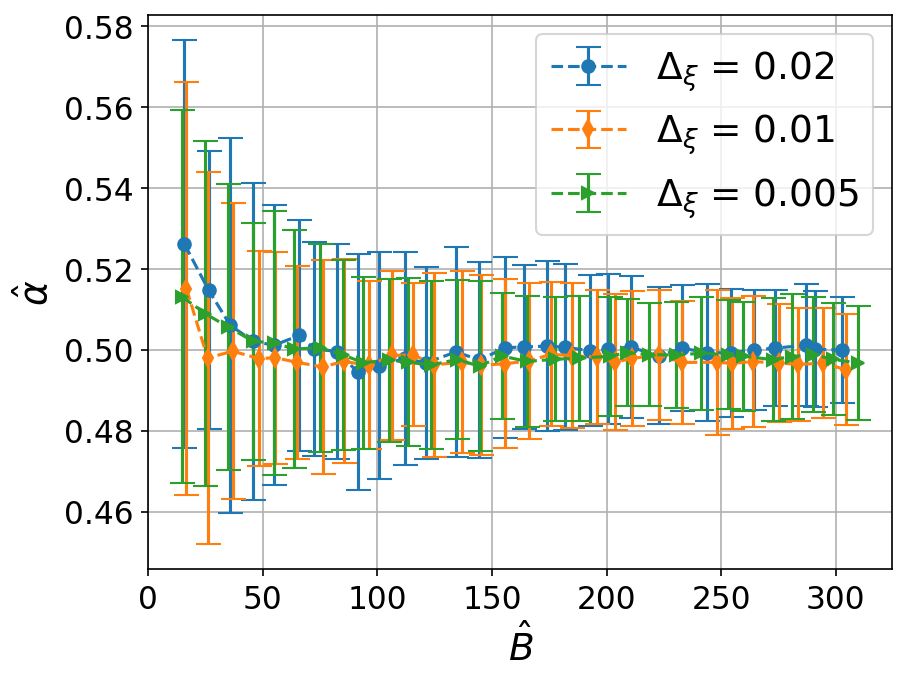

In [21]:
for i, v, j, k, l, m in zip(BMed, BMAD, alphaMed, alphaMAD, deltaXiIn_, markers):
    plt.errorbar(i, j, yerr=const*k, label=fr'$\Delta_{{\xi}}$ = {l}', capsize=6, marker=m, linestyle='--')
plt.xlabel(r'$\hat{B}$', fontsize="18")
plt.ylabel(r'$\hat{\alpha}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize="18", ncol=1)
plt.grid()
plt.savefig("./images/alphaDelta.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

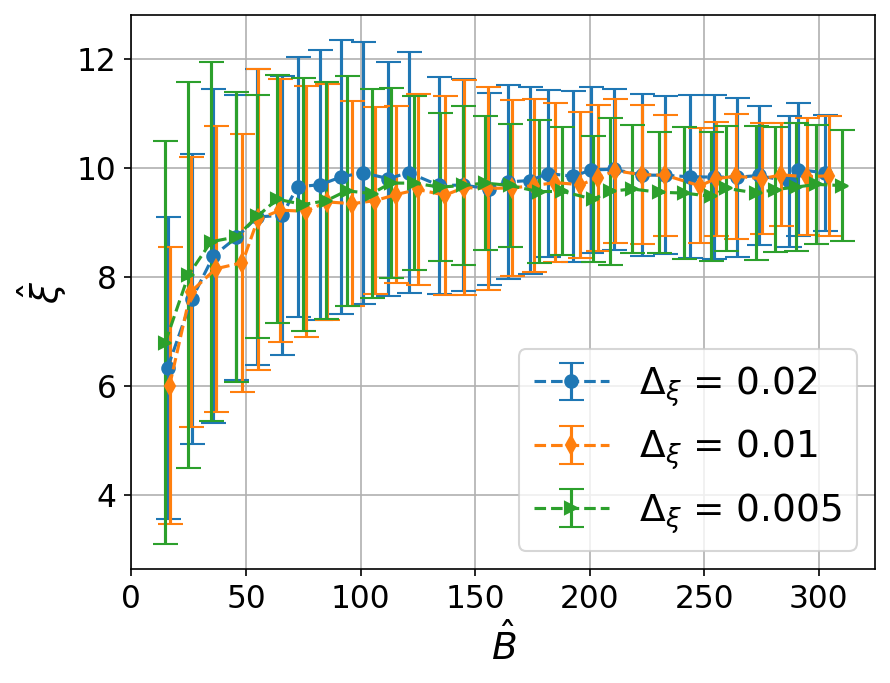

In [22]:
for i, j, k, l, m in zip(BMed, xiMed, xiMAD, deltaXiIn_, markers):
    plt.errorbar(i, j, const*k, label=fr'$\Delta_{{\xi}}$ = {l}', capsize=6, marker=m, linestyle='--')
plt.xlabel(r'$\hat{B}$', fontsize="18")
plt.ylabel(r'$\hat{\xi}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize="18", ncol=1)
plt.grid()
# plt.savefig("./images/xiDelta.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

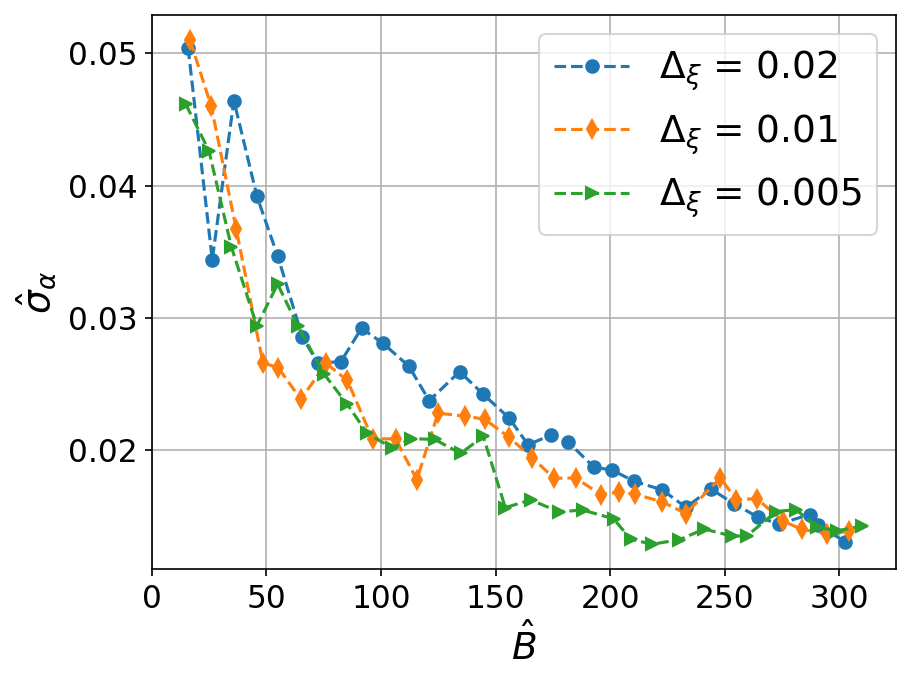

In [24]:
for i, v, j, k, l, m in zip(BMed, BMAD, alphaMed, alphaMAD, deltaXiIn_, markers):
    plt.plot(i, const*k, label=fr'$\Delta_{{\xi}}$ = {l}', marker=m, linestyle='--')
plt.xlabel(r'$\hat{B}$', fontsize="18")
plt.ylabel(r'$\hat{\sigma}_{\alpha}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize="18", ncol=1)
plt.grid()
plt.savefig("./images/sigmaAlphaDelta.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

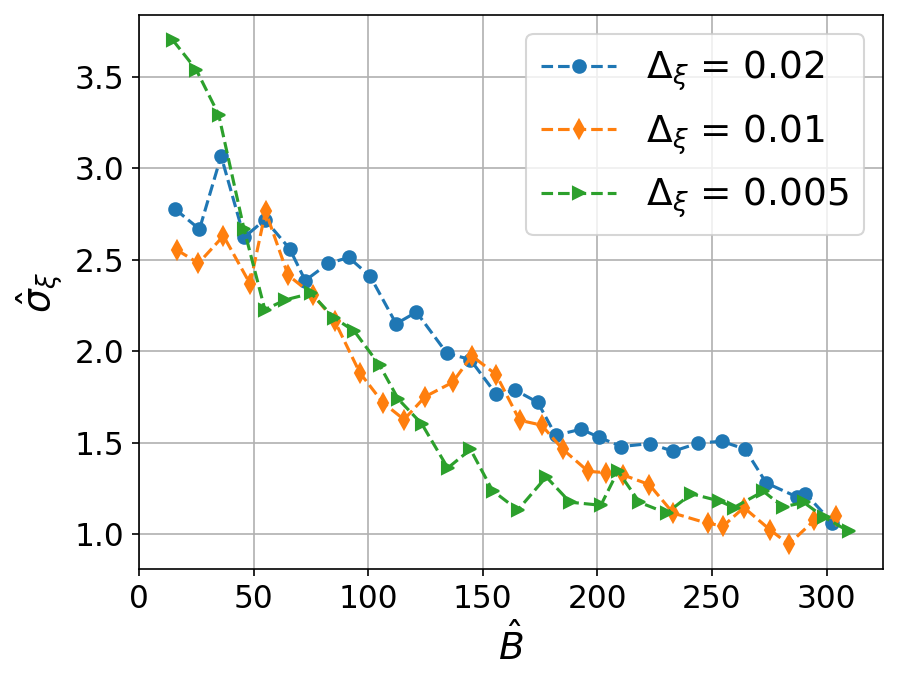

In [25]:
for i, j, k, l, m in zip(BMed, xiMed, xiMAD, deltaXiIn_, markers):
    plt.plot(i, const*k, label=fr'$\Delta_{{\xi}}$ = {l}', marker=m, linestyle='--')
plt.xlabel(r'$\hat{B}$', fontsize="18")
plt.ylabel(r'$\hat{\sigma}_{\xi}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize="18", ncol=1)
plt.grid()
# plt.savefig("./images/sigmaXiDelta.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

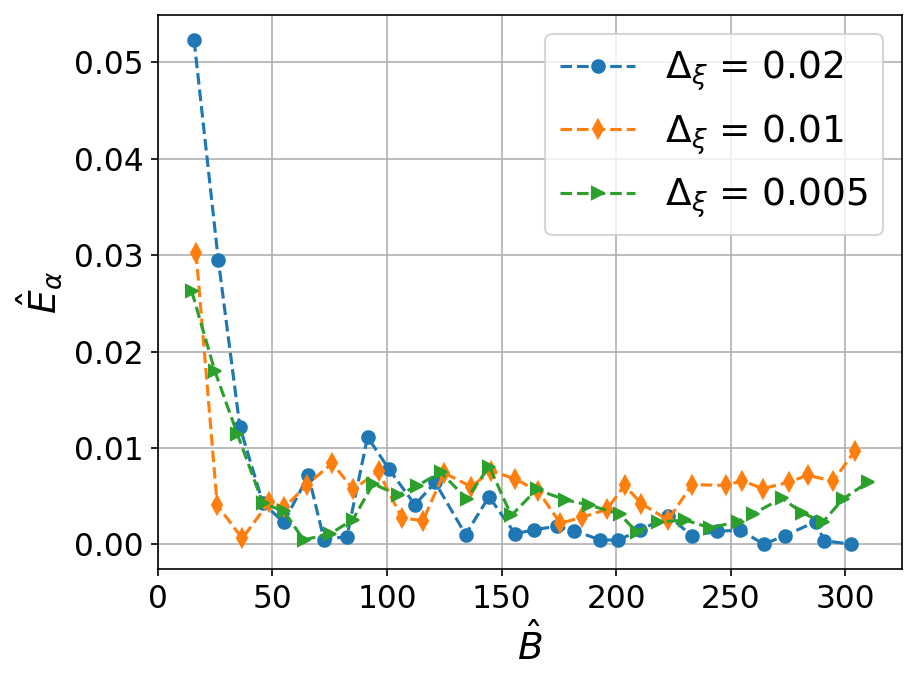

In [26]:
for i, j, l, m in zip(EalphaMed, BMed, deltaXiIn_, markers):
    plt.plot(j, i, label=fr'$\Delta_{{\xi}}$ = {l}', marker=m, linestyle='--')
plt.xlabel(r'$\hat{B}$', fontsize="18")
plt.ylabel(r'$\hat{E}_{\alpha}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize="18", ncol=1)
plt.grid()
plt.savefig("./images/errorAlphaDelta.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

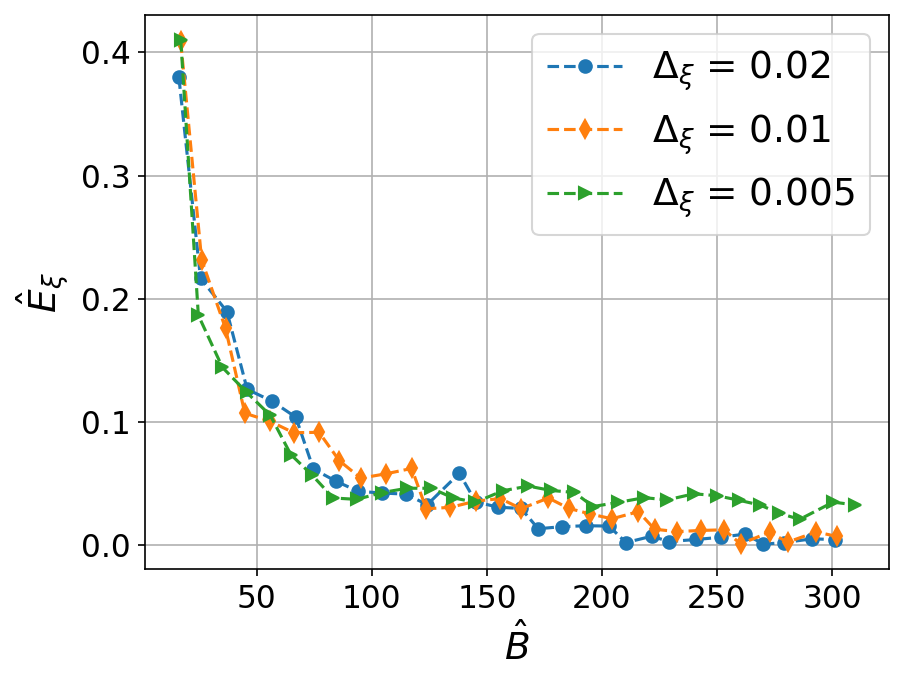

In [7]:
for i, j, l, m in zip(ExiMed, BMed, deltaXiIn_, markers):
    plt.plot(j, i, label=fr'$\Delta_{{\xi}}$ = {l}', marker=m, linestyle='--')
plt.xlabel(r'$\hat{B}$', fontsize="18")
plt.ylabel(r'$\hat{E}_{\xi}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize="18", ncol=1)
plt.grid()
# plt.savefig("./images/errorXiDelta.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

Synthetic data.

Calculate the B-coefficient for various values of $\xi_o$ and at constant $n_{\xi}$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import CorrPy as cp
from tqdm import tqdm

from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns

# from scipy.stats import bootstrap
# from sklearn.model_selection import train_test_split
plt.rcParams['figure.dpi'] = 150

# Define a constant to recalculate median absolute deviation to standard deviation
const = 1.4826

markers = ['o', 'd', '>', '<', 'P']

In [12]:
# Control parameters
alphaIn = .5
numberOfProfiles = 100

# Initialize containers
xiMed = []
xiMAD = []

alphaMed = []
alphaMAD = []

ExiMed = []
# ExiMAD = []

EalphaMed = []
# EalphaMAD = []

BMed = []
BMAD = []

xiIn_ = list(range(10, 60, 20))
deltaXiIn = .01

for xiIn in tqdm(xiIn_):
    deltaIn = xiIn*deltaXiIn
    
    # step=20*xiIn
    # lengthIn = 300*xiIn
    
    # step=10*xiIn
    step=5*xiIn
    lengthIn = 300*xiIn
    
    # step=2*xiIn
    # lengthIn = 100*xiIn
    
    xiRef, PWT = cp.profileGenerator(alpha=alphaIn, omega=1, xi=xiIn, delta=deltaIn,
                            length=lengthIn, N=numberOfProfiles)

    # Subtract trend
    # PWT = cp.subtractTrend(dist, PWT, 'svr')

    # Calculate the autocorrelation function
    A, IW = cp.GrowingWindow(start=step, stop=lengthIn, step=step, Profiles=PWT,
                             delta=deltaIn, method='acf', deviation='std')
    
    # Calculate the Hurst function
    # H = np.sqrt(1 - A)
    
    # Calculate the lateral correlation length
    xi = cp.correlationLength(deltaIn, A)
    
    # Calculate the self-affine exponent
    alpha = cp.selfAffineParameters(deltaIn, np.sqrt(1 - A), 'exponent', robust=False)
    

    # Generate length scales at which the statistical functions
    # and the self-affine parameters were found
    # X = step*np.linspace(1, deltaIn*len(xi), len(xi)).reshape(-1,1)
    # X = np.linspace(step, lengthIn, len(xi))
    X = np.linspace(step, lengthIn, len(xi)).reshape(-1,1)

    # Calculate median and median absolute deviation
    xiMed.append(np.nanmedian(xi, 1))
    xiMAD.append(cp.mad(xi, 1, nan_policy='omit'))

    alphaMed.append(np.nanmedian(alpha, 1))
    alphaMAD.append(cp.mad(alpha, 1, nan_policy='omit'))


    ExiMed.append(np.abs(xiRef - np.nanmedian(xi, 1))/xiRef)
    # ExiMAD.append(cp.mad(xi, 1, nan_policy='omit')/xiRef)

    EalphaMed.append(np.abs(alphaIn - np.nanmedian(alpha, 1))/alphaIn)
    # EalphaMed.append(np.abs(.4475 - np.nanmedian(alpha, 1))/.4475)
    # EalphaMed.append(np.abs(alphaMed[-1][-1] - np.nanmedian(alpha, 1))/alphaMed[-1][-1])

    # EalphaMAD.append(cp.mad(alpha, 1, nan_policy='omit')/alphaIn)

    # Calculate the B-coefficient
    B = X/xi;
    # B = np.sqrt(1/B)

    BMed.append(np.nanmedian(B, 1))
    BMAD.append(cp.mad(B, 1, nan_policy='omit'))

    del PWT, A, xi, alpha, B


100%|██████████| 3/3 [03:58<00:00, 79.46s/it]


In [37]:
res = np.where(np.max(xi) == xi)
k  = res[0][0]

In [42]:
BMed[-1][k]

64.95999086277052

In [38]:
xi[k, :]

array([  77.01  ,   55.4225,   41.94  ,   49.1325,   45.895 ,   46.445 ,
         45.1775,   39.2175,   53.6   ,   39.6425,   61.8675,   57.675 ,
         30.9025,   48.3875,   49.33  ,   52.4625,   45.4175,   46.285 ,
         33.42  ,   57.695 ,   37.05  ,   52.78  ,   46.6075,   74.5   ,
         31.6225,   68.65  ,   45.85  ,   32.4275,   55.88  ,   44.645 ,
         36.6525,   42.3425,   39.2725,   38.1825,   47.0575,   36.7125,
         44.74  ,   48.0725,   58.025 ,   45.2025,   44.435 ,   42.3675,
         39.42  ,   33.4075,   61.205 ,   59.305 ,   64.5325,   73.23  ,
         79.5925,   30.4025,   47.635 ,   46.9025,   49.8925,   60.5   ,
       1059.5   ,   46.08  ,   53.645 ,   54.2725,   60.0425,   51.9575,
         46.45  ,   46.4175,   44.68  ,   42.745 ,   55.625 ,   46.0575,
         53.065 , 1179.715 ,   61.35  ,   42.2075,   38.3625,   37.135 ,
         34.125 ,   42.655 ,   35.0175,   36.405 ,   61.91  ,   34.55  ,
         52.14  ,   42.48  ,   38.9625,   47.44  , 

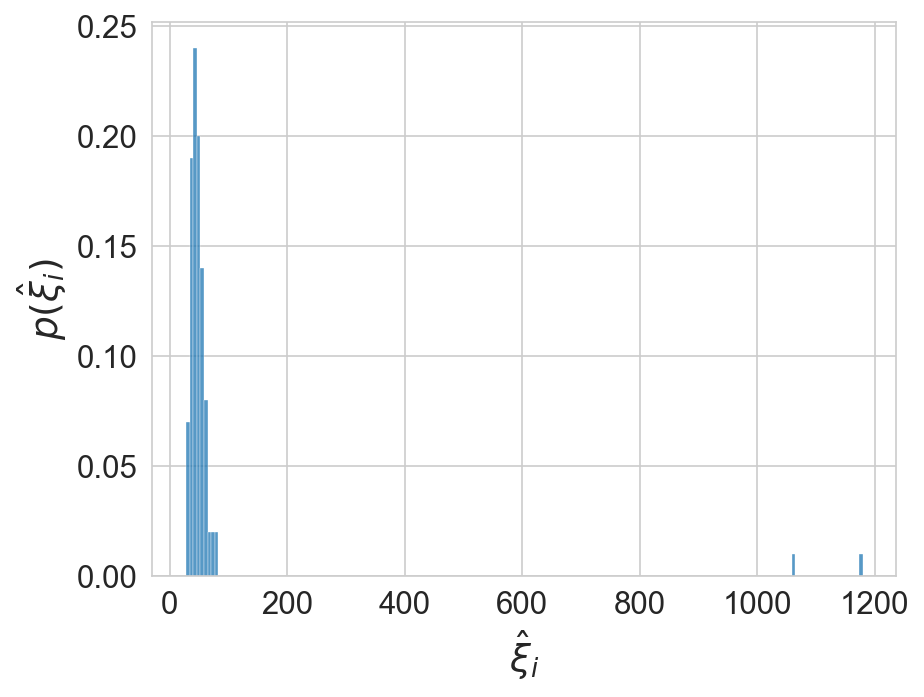

In [43]:
sns.histplot(xi[k, :].flatten(), kde=False, legend=False, stat='probability', label=r'$\alpha=0.75$', line_kws={'linewidth': 4, 'linestyle':'--'})
sns.set_style("whitegrid")
plt.ylabel(r'$p(\hat{\xi}_i)$', fontsize="18")
plt.xlabel(r'$\hat{\xi}_i$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
# plt.xlim(left=0, right=20)
# plt.legend(fontsize="18")
plt.savefig("./images/pdfXi.png", format="png", bbox_inches="tight")
plt.show()

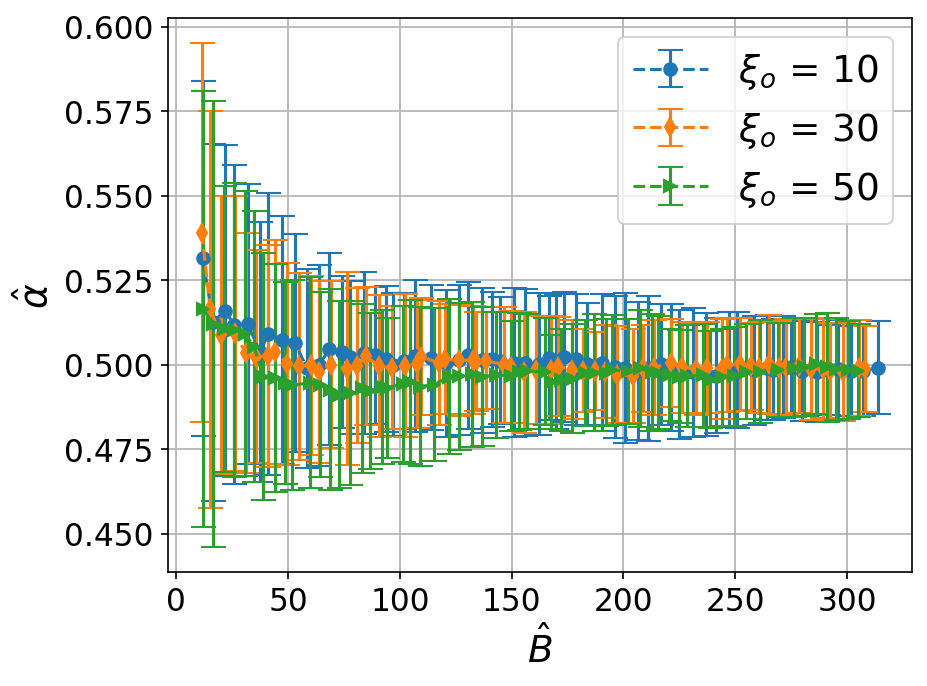

In [13]:
for i, v, j, k, l, m in zip(BMed, BMAD, alphaMed, alphaMAD, xiIn_, markers):
    plt.errorbar(i, j, yerr=const*k, label=fr'$\xi_o$ = {l}', capsize=6, marker=m, linestyle='--')
plt.xlabel(r'$\hat{B}$', fontsize="18")
plt.ylabel(r'$\hat{\alpha}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
# plt.legend(fontsize="18", loc='center', bbox_to_anchor=(.61, .18), ncol=2)
plt.legend(fontsize="18", ncol=1)
plt.grid()
# plt.savefig("./images/alphaB.png", format="png", bbox_inches="tight", dpi=300)
# plt.savefig("./images/alphaB_100.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

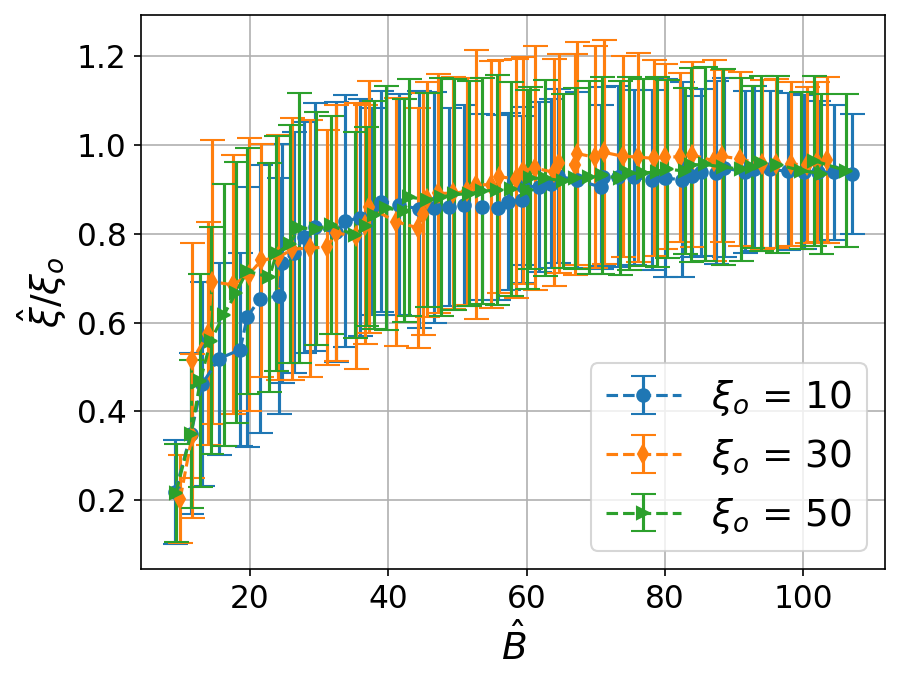

In [7]:
for i, j, k, l, m in zip(BMed, xiMed, xiMAD, xiIn_, markers):
    plt.errorbar(i, j/l, const*k/l, label=fr'$\xi_o$ = {l}', capsize=6, marker=m, linestyle='--')
plt.xlabel(r'$\hat{B}$', fontsize="18")
plt.ylabel(r'$\hat{\xi}/\xi_o$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
# plt.legend(fontsize="18", loc='center', bbox_to_anchor=(.61, .18), ncol=2)
plt.legend(fontsize="18", ncol=1)
plt.grid()
# plt.savefig("./images/xiB.png", format="png", bbox_inches="tight", dpi=300)
plt.savefig("./images/xiB_100.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

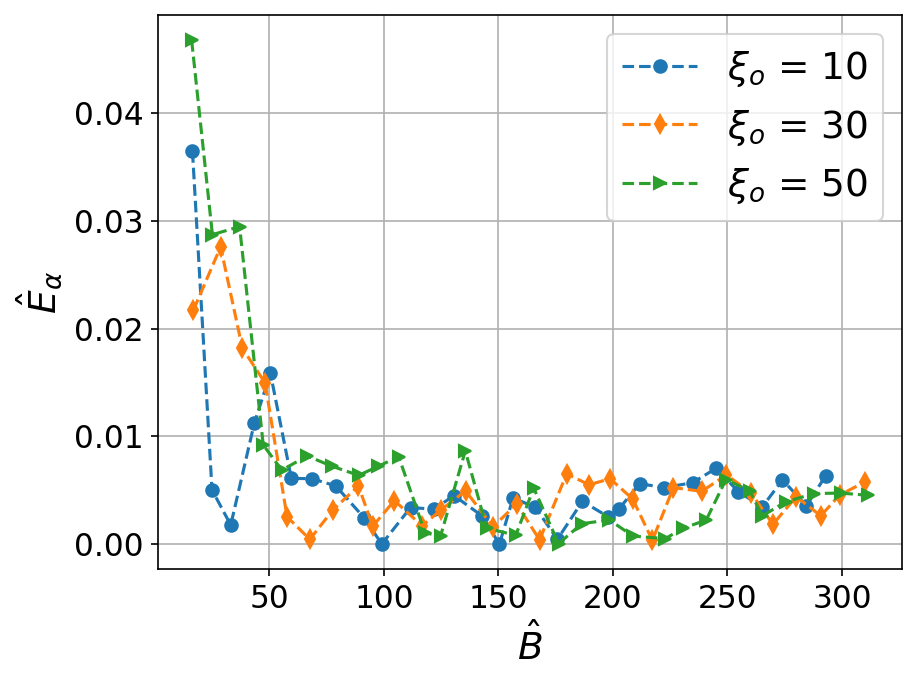

In [5]:
for i, j, l, m in zip(EalphaMed, BMed, xiIn_, markers):
    plt.plot(j, i, label=fr'$\xi_o$ = {l}', marker=m, linestyle='--')
plt.xlabel(r'$\hat{B}$', fontsize="18")
plt.ylabel(r'$\hat{E}_{\alpha}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
# plt.legend(fontsize="18", loc='center', bbox_to_anchor=(.42, 1.125), ncol=3)
plt.legend(fontsize="18", ncol=1)
plt.grid()
# plt.savefig("./images/errorAlphaB.png", format="png", bbox_inches="tight", dpi=300)
# plt.savefig("./images/errorAlphaB_100.png", format="png", bbox_inches="tight", dpi=300)
# plt.savefig("./images/errorAlphaB_lawLarge.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

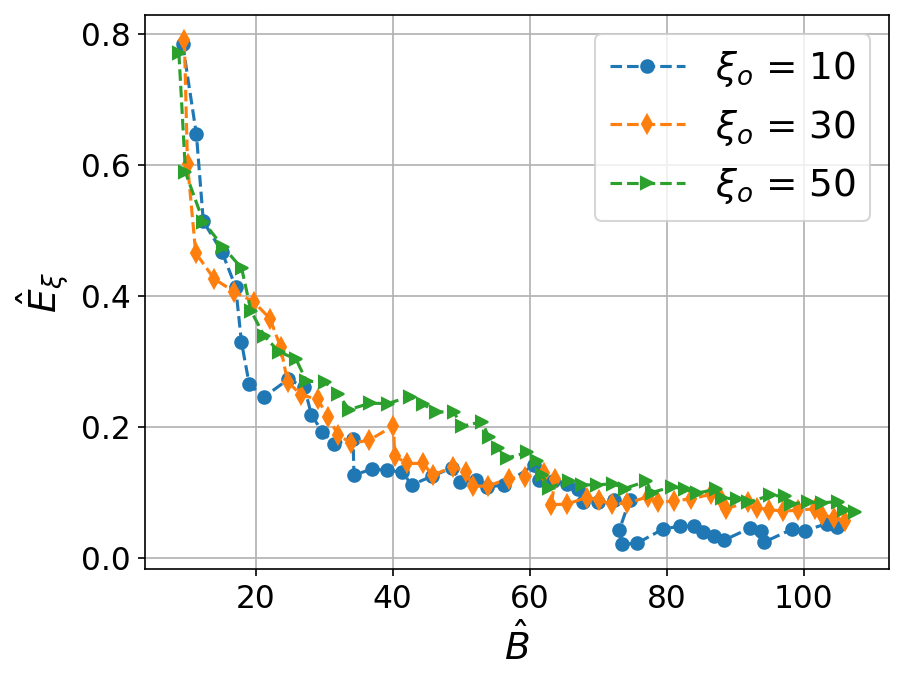

In [46]:
for i, j, l, m in zip(ExiMed, BMed, xiIn_, markers):
    plt.plot(j, i, label=fr'$\xi_o$ = {l}', marker=m, linestyle='--')
plt.xlabel(r'$\hat{B}$', fontsize="18")
plt.ylabel(r'$\hat{E}_{\xi}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
# plt.legend(fontsize="18", loc='center', bbox_to_anchor=(.6, .82), ncol=2)
plt.legend(fontsize="18", ncol=1)
plt.grid()
# plt.savefig("./images/errorXiB.png", format="png", bbox_inches="tight", dpi=300)
# plt.savefig("./images/errorXiB_100.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

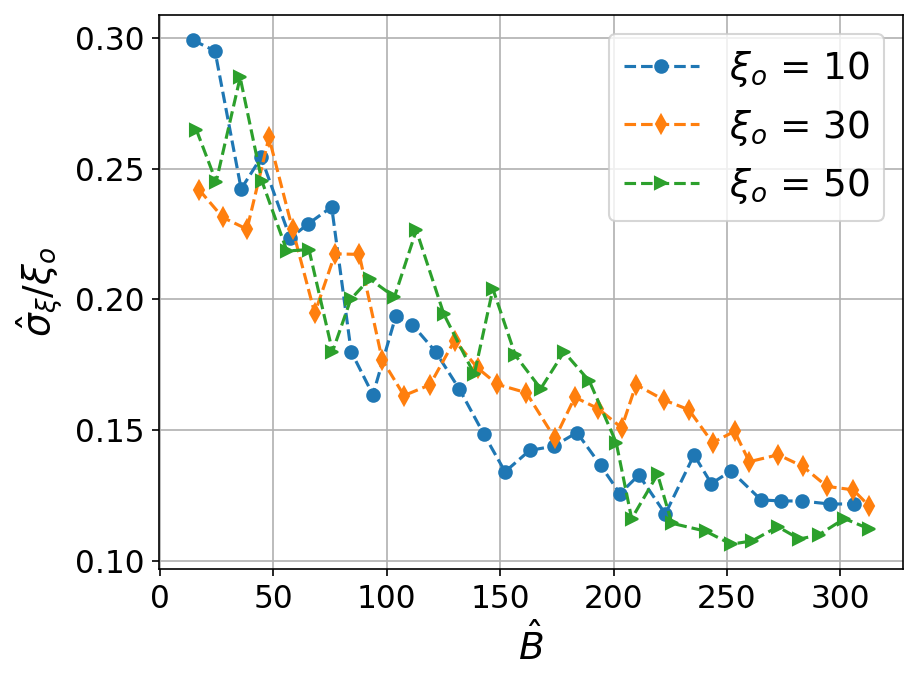

In [20]:
for i, j, k, l, m in zip(BMed, xiMed, xiMAD, xiIn_, markers):
    plt.plot(i, const*k/l, label=fr'$\xi_o$ = {l}', marker=m, linestyle='--')
plt.xlabel(r'$\hat{B}$', fontsize="18")
plt.ylabel(r'$\hat{\sigma}_{\xi}/\xi_o$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize="18", ncol=1)
plt.grid()
# plt.savefig("./images/sigmaXiB.png", format="png", bbox_inches="tight", dpi=300)
# plt.savefig("./images/sigmaXiB_100.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

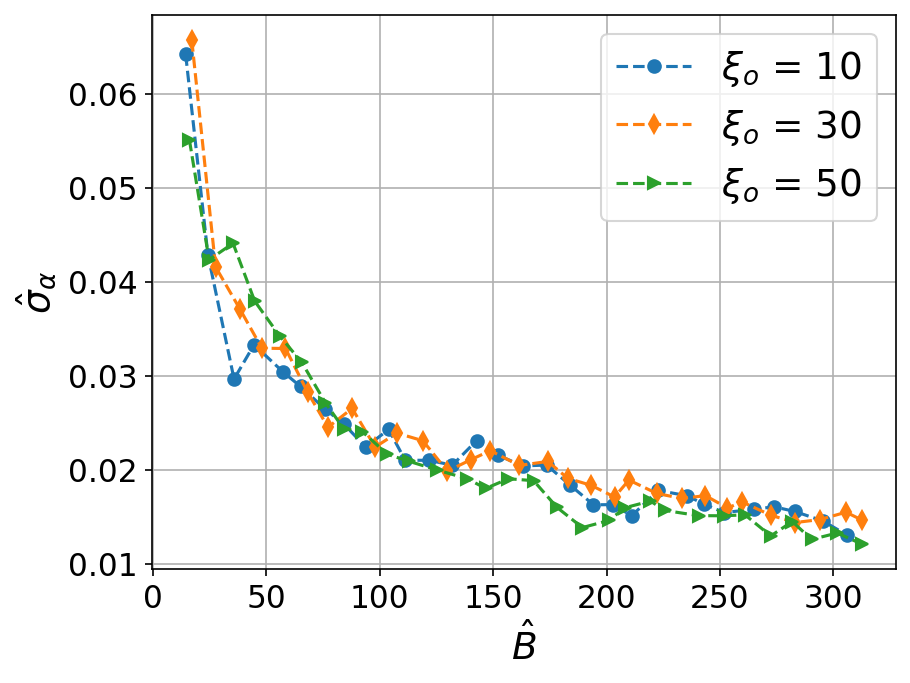

In [22]:
for i, v, j, k, l, m in zip(BMed, BMAD, alphaMed, alphaMAD, xiIn_, markers):
    plt.plot(i, const*k, label=fr'$\xi_o$ = {l}', marker=m, linestyle='--')
plt.xlabel(r'$\hat{B}$', fontsize="18")
plt.ylabel(r'$\hat{\sigma}_{\alpha}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize="18", ncol=1)
plt.grid()
plt.savefig("./images/sigmaAlphaB.png", format="png", bbox_inches="tight", dpi=300)
# plt.savefig("./images/sigmaAlphaB_100.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

In [133]:
X = np.full(1, np.nan)
Y = X
# print(X)
for i in range(len(xiIn_)):
    X = np.append(X, ExiMed[i])
    Y = np.append(Y, np.sqrt(1/BMed[i]))
X = X[~np.isnan(X)]
Y = Y[~np.isnan(Y)]
X = X.reshape(-1,1)
X.shape
# print(X)
# print(Y)

(90, 1)

In [146]:
X_test, X_train, Y_test, Y_train = train_test_split(X, Y, test_size=0.4, shuffle=True)

In [147]:
# LR = LinearRegression()
LR = HuberRegressor()
LR.fit(X_train, Y_train)
Y_pred = LR.predict(X_test)

RE = cp.errorRel(Y_pred, Y_test)


print("Relative error: ", np.round(np.mean(RE), 2))
print('Coefficient of proportionality: ', np.round(LR.coef_[0], 2))
print("Intercept value:", np.round(LR.intercept_, 2))

Relative error:  0.11
Coefficient of proportionality:  0.65
Intercept value: 0.05


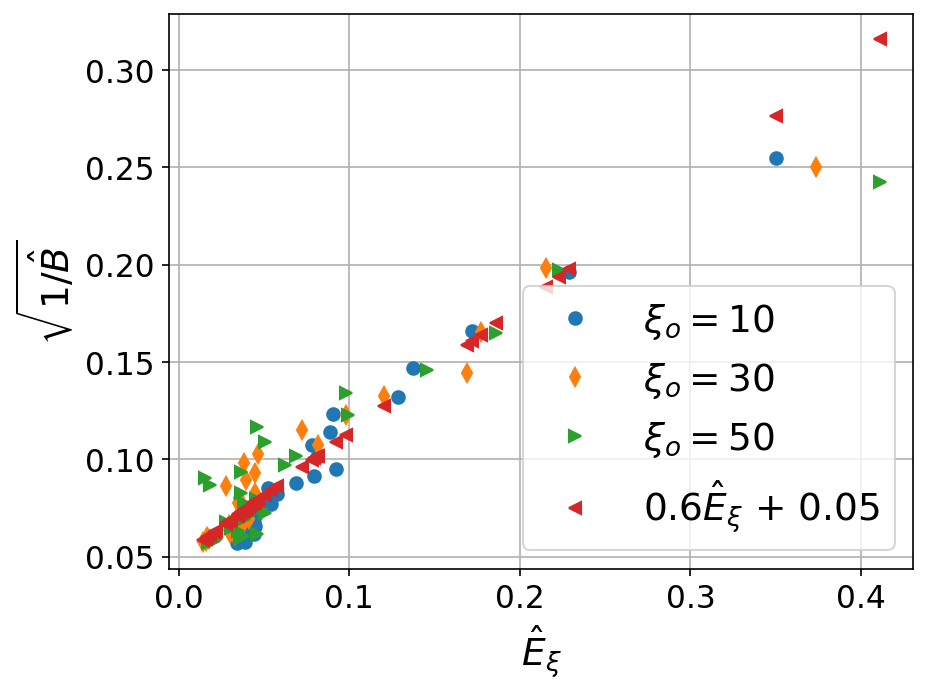

In [148]:
for i, j, k, m in zip(ExiMed, BMed, xiIn_, markers):
    plt.plot(i, np.sqrt(1/j), m, label=rf'$\xi_o = {k}$')
plt.plot(X_test, Y_pred, '<', label=rf'{LR.coef_[0]:.1f}$\hat{{E}}_{{\xi}}$ + {LR.intercept_:.2f}')
plt.xlabel(r'$\hat{E}_{\xi}$', fontsize="18")
plt.ylabel(r'$\sqrt{1/\hat{B}}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize="18", ncol=1)
plt.grid()
# plt.savefig("./images/lawLargeNumbersXi_linear.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

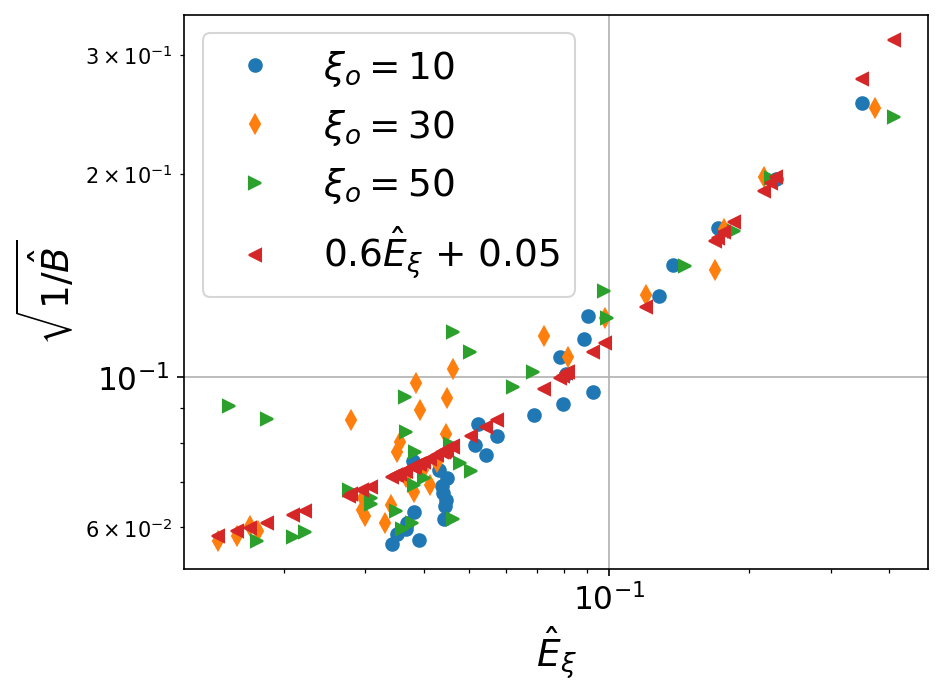

In [149]:
for i, j, k, m in zip(ExiMed, BMed, xiIn_, markers):
    plt.loglog(i, np.sqrt(1/j), m, label=rf'$\xi_o = {k}$')
plt.plot(X_test, Y_pred, '<', label=rf'{LR.coef_[0]:.1f}$\hat{{E}}_{{\xi}}$ + {LR.intercept_:.2f}')
plt.xlabel(r'$\hat{E}_{\xi}$', fontsize="18")
plt.ylabel(r'$\sqrt{1/\hat{B}}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize="18", ncol=1)
plt.grid()
# plt.savefig("./images/lawLargeNumbersXi_log.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

In [14]:
# The same for alpha
X = np.full(1, np.nan)
Y = X
# print(X)
for i in range(len(xiIn_)):
    X = np.append(X, EalphaMed[i])
    Y = np.append(Y, np.sqrt(1/BMed[i]))
X = X[~np.isnan(X)]
Y = Y[~np.isnan(Y)]
X = X.reshape(-1,1)
X.shape
# print(X)
# print(Y)

(180, 1)

In [15]:
X_test, X_train, Y_test, Y_train = train_test_split(X, Y, test_size=0.4, shuffle=True)

In [16]:
# LR = LinearRegression()
LR = HuberRegressor()
LR.fit(X_train, Y_train)
Y_pred = LR.predict(X_test)
RE = cp.errorRel(Y_pred, Y_test)

print("Relative error: ", np.round(np.mean(RE), 2))
print('Coefficient of proportionality: ', np.round(LR.coef_[0], 2))
print("Intercept value:", np.round(LR.intercept_, 2))

Relative error:  0.21
Coefficient of proportionality:  5.34
Intercept value: 0.06


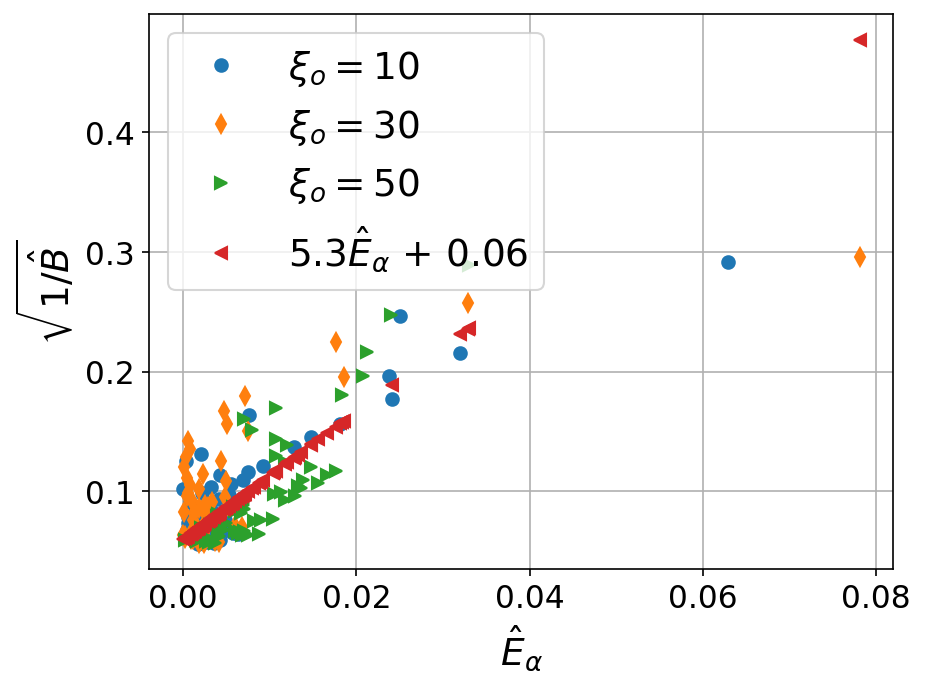

In [17]:
for i, j, k, m in zip(EalphaMed, BMed, xiIn_, markers):
    plt.plot(i, np.sqrt(1/j), m, label=rf'$\xi_o = {k}$')
plt.plot(X_test, Y_pred, '<', label=rf'{LR.coef_[0]:.1f}$\hat{{E}}_{{\alpha}}$ + {LR.intercept_:.2f}')
plt.xlabel(r'$\hat{E}_{\alpha}$', fontsize="18")
plt.ylabel(r'$\sqrt{1/\hat{B}}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize="18", ncol=1)
plt.grid()
# plt.savefig("./images/lawLargeNumbersAlpha_linear.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

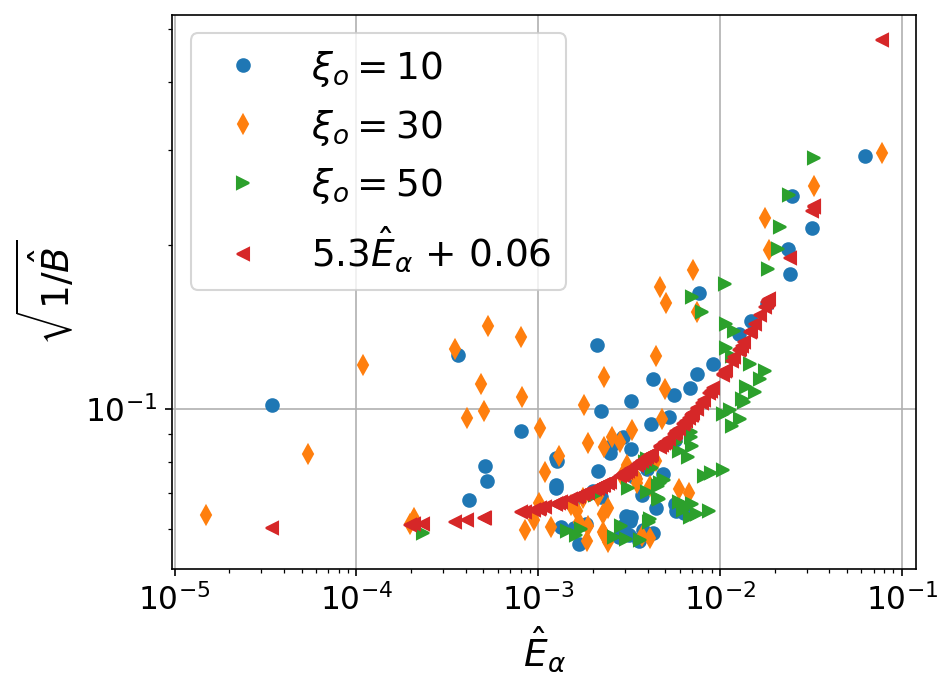

In [ ]:
for i, j, k, m in zip(EalphaMed, BMed, xiIn_, markers):
    plt.loglog(i, np.sqrt(1/j), m, label=rf'$\xi_o = {k}$')
plt.loglog(X_test, Y_pred, '<', label=rf'{LR.coef_[0]:.1f}$\hat{{E}}_{{\alpha}}$ + {LR.intercept_:.2f}')
plt.xlabel(r'$\hat{E}_{\alpha}$', fontsize="18")
plt.ylabel(r'$\sqrt{1/\hat{B}}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize="18", ncol=1)
plt.grid()
# plt.savefig("./images/lawLargeNumbersAlpha_log.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

Synthetic data.
Estimate the self-affine exponent $\alpha$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import CorrPy as cp
from tqdm import tqdm
# import seaborn as sns
# from scipy.stats import bootstrap
# from sklearn.model_selection import train_test_split
plt.rcParams['figure.dpi'] = 150

# Define a constant to recalculate median absolute deviation to standard deviation
const = 1.4826
markers = ['o', 'd', '>', '<', 'P', 'v']

In [2]:
# Control parameters
# Initialize containers
HCopy = []
xiMed = []
xiMAD = []

alphaMed = []
alphaMAD = []

ExiMed = []
# ExiMAD = []

EalphaMed = []
# EalphaMAD = []

BMed = []
BMAD = []

numberOfProfiles = 100
# alphaIn_ = [0.3, 0.4, 0.5, 0.6, 0.7]
alphaIn_ = [0.3, 0.5, 0.7]
xiIn = 10

deltaIn = 0.01*xiIn
# deltaIn = 0.005*xiIn

step=10*xiIn
# step=4*xiIn

lengthIn = 300*xiIn
# lengthIn = 100*xiIn


for alphaIn in tqdm(alphaIn_):
    
    xiRef, PWT = cp.profileGenerator(alpha=alphaIn, omega=1, xi=xiIn, delta=deltaIn,
                            length=lengthIn, N=numberOfProfiles)

    # Subtract trend
    # PWT = cp.subtractTrend(dist, PWT, 'svr')

    # Calculate the autocorrelation function
    A, IW = cp.GrowingWindow(start=step, stop=lengthIn, step=step, Profiles=PWT,
                             delta=deltaIn, method='acf', deviation='std')
    
    # Calculate the Hurst function
    H = np.sqrt(1 - A)
    HCopy.append(H[:,:,0])
    
    # Calculate the lateral correlation length
    xi = cp.correlationLength(deltaIn, A)
    # xi_med = np.nanmedian(xi, 1)
    # Calculate the self-affine exponent
    alpha = cp.selfAffineParameters(deltaIn, H, 'exponent', robust=False)
    # print(alpha)

    # Generate length scales at which the statistical functions
    # and the self-affine parameters were found
    # X = step*np.linspace(1, deltaIn*len(xi), len(xi)).reshape(-1,1)
    # X = np.linspace(step, lengthIn, len(xi))
    X = np.linspace(step, lengthIn, len(xi)).reshape(-1,1)

    # Calculate median and median absolute deviation
    xiMed.append(np.nanmedian(xi, 1))
    # xiMed.append(np.nanmean(xi, 1))
    xiMAD.append(cp.mad(xi, 1, nan_policy='omit'))

    alphaMed.append(np.nanmedian(alpha, 1))
    alphaMAD.append(cp.mad(alpha, 1, nan_policy='omit'))


    ExiMed.append(np.abs(xiRef - np.nanmedian(xi, 1))/xiRef)
    # ExiMAD.append(cp.mad(xi, 1, nan_policy='omit')/xiRef)

    EalphaMed.append(np.abs(alphaIn - np.nanmedian(alpha, 1))/alphaIn)
    # EalphaMAD.append(cp.mad(alpha, 1, nan_policy='omit')/alphaIn)

    # Calculate the B-coefficient
    B = X/xi;
    # B = np.sqrt(1/B)

    BMed.append(np.nanmedian(B, 1))
    BMAD.append(cp.mad(B, 1, nan_policy='omit'))

    del PWT, A, H, xi, alpha, B, X

  0%|          | 0/3 [00:00<?, ?it/s]/home/aleksandr/ownCloud/Data/First Study/Articles/PRL_UQ/Data/CorrPy.py:415: RuntimeWarning: divide by zero encountered in power
  return a*pow(x,b)
100%|██████████| 3/3 [03:12<00:00, 64.06s/it] 


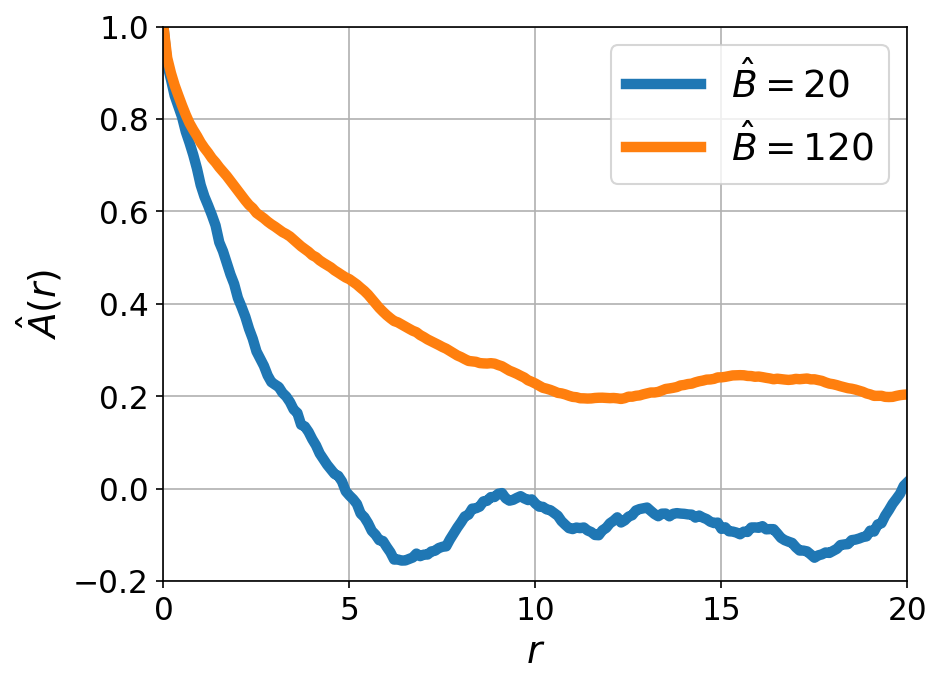

In [ ]:
# r = 0.01*xiIn*np.linspace(0, len(i) - 1, len(i))
col = ['tab:blue', 'tab:red', 'tab:green']
n = 1
for i, c, l in zip(HCopy, col, range(1)):
    r = 0.01*xiIn*np.linspace(0, len(i) - 1, len(i))
    plt.plot(r[::n], 1 - pow(i[0::n, 0], 2), linewidth=5, label=r"$\hat{B} = 20$")
    plt.plot(r[::n], 1 - pow(i[0::n, -1], 2), linewidth=5, label=r"$\hat{B} = 120$")
plt.xlabel(r'$r$', fontsize="18")
plt.ylabel(r'$\hat{A}(r)$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize="18", ncol=1)
plt.xlim([0, 20])
plt.ylim([-.2, 1])
plt.grid()
# plt.savefig("./images/convergenceA.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

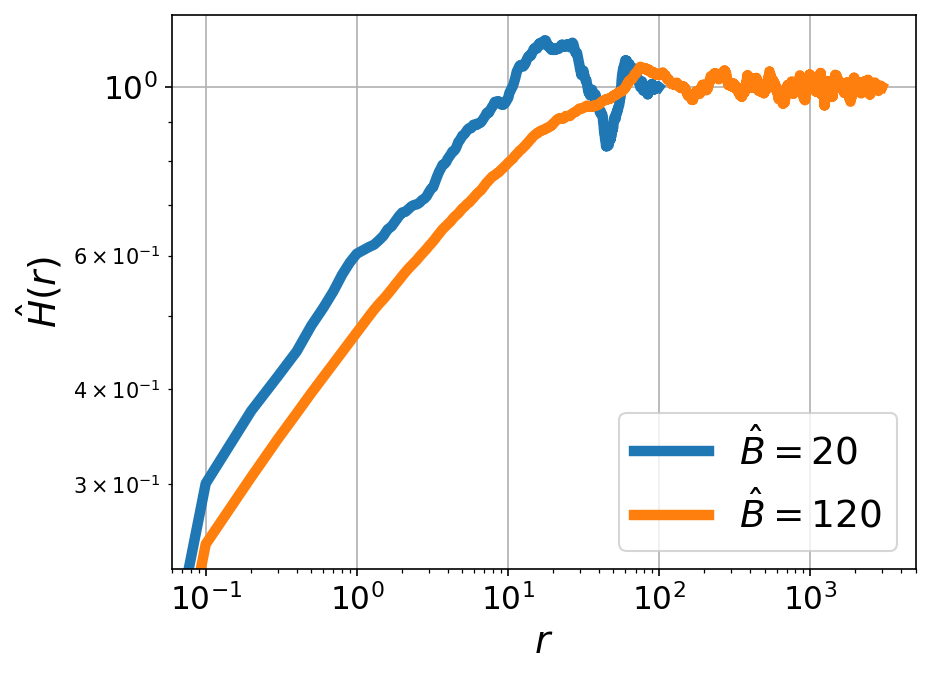

In [3]:
# r = 0.01*xiIn*np.linspace(0, len(i) - 1, len(i))
col = ['tab:blue', 'tab:red', 'tab:green']
n = 1
for i, c, l in zip(HCopy, col, range(1)):
    r = 0.01*xiIn*np.linspace(0, len(i) - 1, len(i))
    plt.loglog(r[::n], i[0::n, 0], linewidth=5, label=r"$\hat{B} = 20$")
    plt.loglog(r[::n], i[0::n, -1], linewidth=5, label=r"$\hat{B} = 120$")
plt.xlabel(r'$r$', fontsize="18")
plt.ylabel(r'$\hat{H}(r)$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize="18", ncol=1)
# plt.xlim([-0.1, 20])
# plt.ylim([-.2, 1])
plt.grid()
# plt.savefig("./images/convergenceH.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

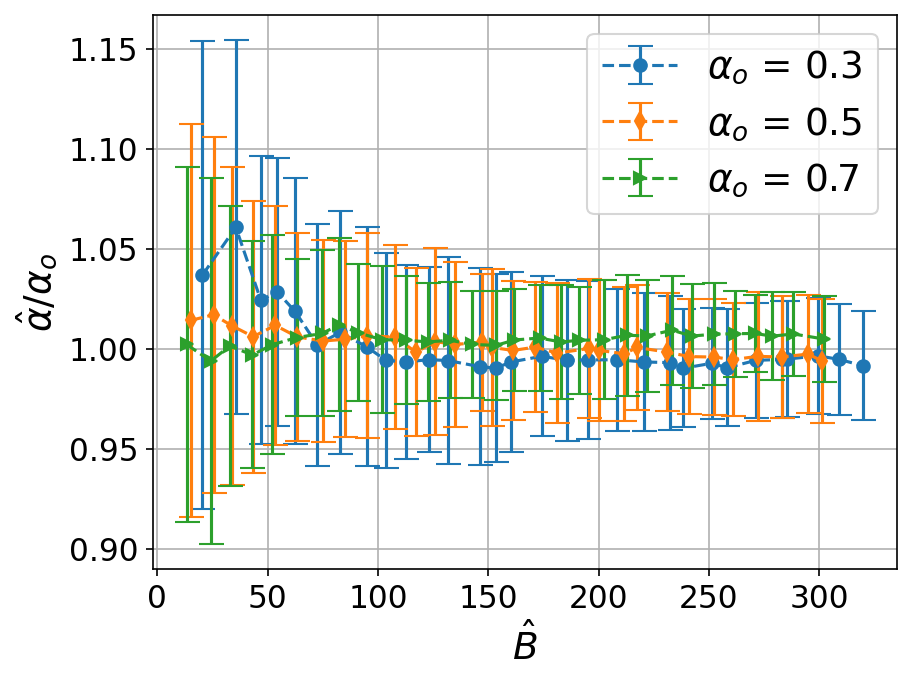

In [3]:
for i, v, j, k, l, m in zip(BMed, BMAD, alphaMed, alphaMAD, alphaIn_, markers):
    plt.errorbar(i, j/l, yerr=const*k/l, label=fr'$\alpha_o$ = {l}', capsize=6, marker=m, linestyle='--')
plt.xlabel(r'$\hat{B}$', fontsize="18")
plt.ylabel(r'$\hat{\alpha}/\alpha_o$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
# plt.legend(fontsize="18", loc='center', bbox_to_anchor=(.61, .18), ncol=2)
plt.legend(fontsize="18", ncol=1)
plt.grid()
# plt.savefig("./images/variousAlphaB.png", format="png", bbox_inches="tight", dpi=300)
# plt.savefig("./images/variousAlphaB_100.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

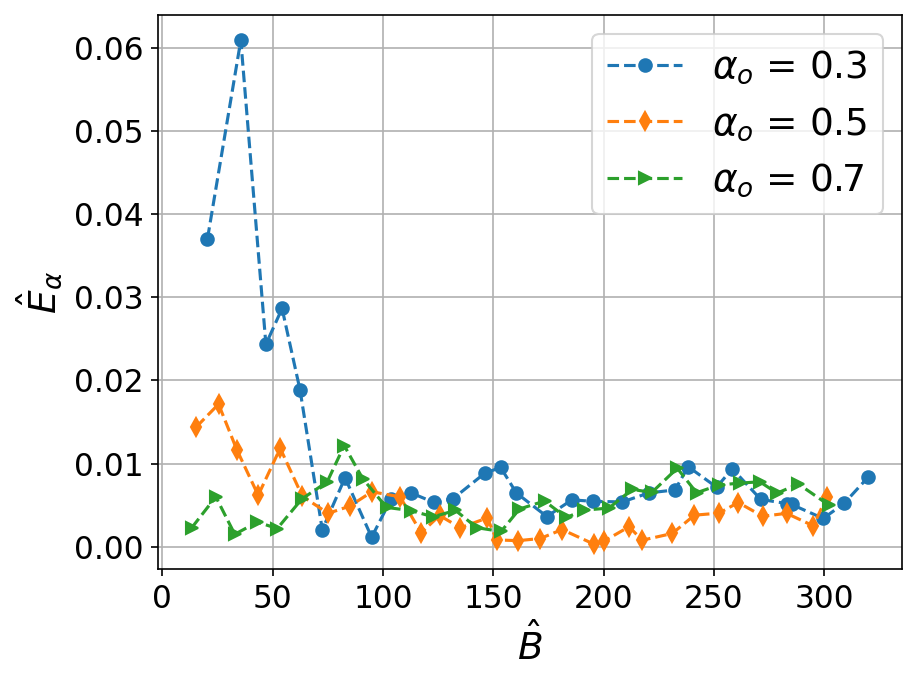

In [4]:
for i, j, l, m in zip(EalphaMed, BMed, alphaIn_, markers):
    plt.plot(j, i, label=fr'$\alpha_o$ = {l}', marker=m, linestyle='--')
plt.xlabel(r'$\hat{B}$', fontsize="18")
plt.ylabel(r'$\hat{E}_{\alpha}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
# plt.legend(fontsize="18", loc='center', bbox_to_anchor=(.42, 1.125), ncol=3)
plt.legend(fontsize="18", ncol=1)
plt.grid()
# plt.savefig("./images/errorVariousAlphaB.png", format="png", bbox_inches="tight", dpi=300)
# plt.savefig("./images/errorVariousAlphaB_100.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

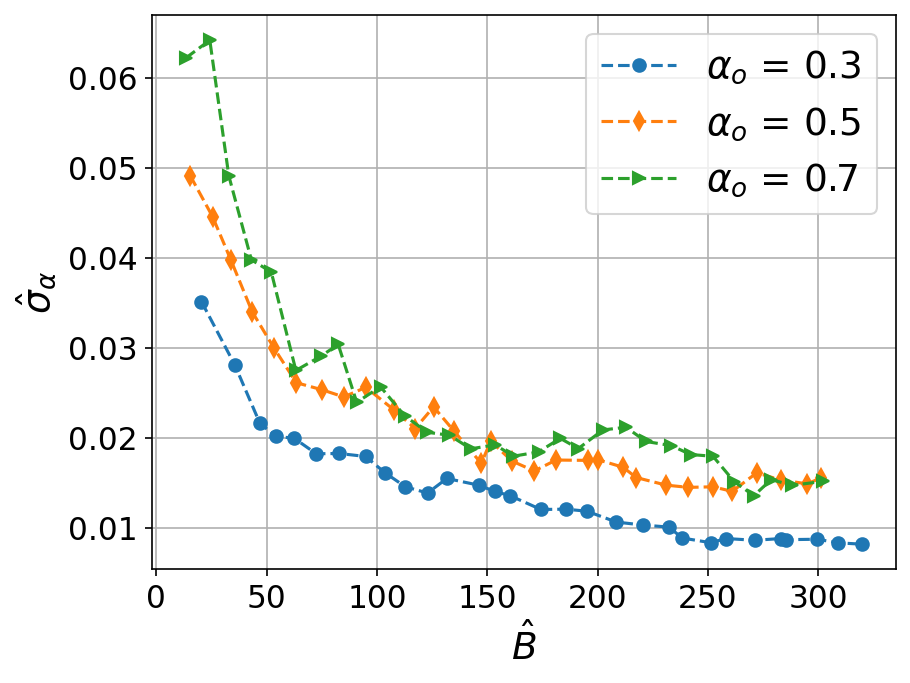

In [5]:
for i, v, j, k, l, m in zip(BMed, BMAD, alphaMed, alphaMAD, alphaIn_, markers):
    plt.plot(i, const*k, label=fr'$\alpha_o$ = {l}', marker=m, linestyle='--')
plt.xlabel(r'$\hat{B}$', fontsize="18")
plt.ylabel(r'$\hat{\sigma}_{\alpha}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize="18", ncol=1)
plt.grid()
# plt.savefig("./images/sigmaVariousAlpha.png", format="png", bbox_inches="tight", dpi=300)
# plt.savefig("./images/sigmaVariousAlpha_100.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

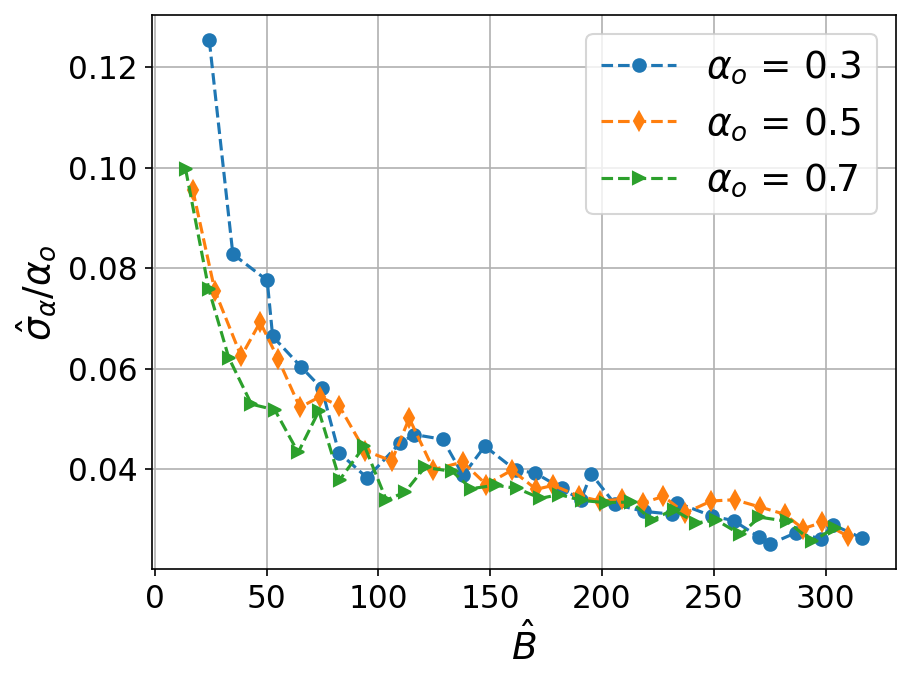

In [11]:
for i, v, j, k, l, m in zip(BMed, BMAD, alphaMed, alphaMAD, alphaIn_, markers):
    plt.plot(i, const*k/l, label=fr'$\alpha_o$ = {l}', marker=m, linestyle='--')
plt.xlabel(r'$\hat{B}$', fontsize="18")
plt.ylabel(r'$\hat{\sigma}_{\alpha}/\alpha_o$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize="18", ncol=1)
plt.grid()
plt.savefig("./images/sigmaVariousAlphaRelative.png", format="png", bbox_inches="tight", dpi=300)
# plt.savefig("./images/sigmaVariousAlphaRelative_100.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

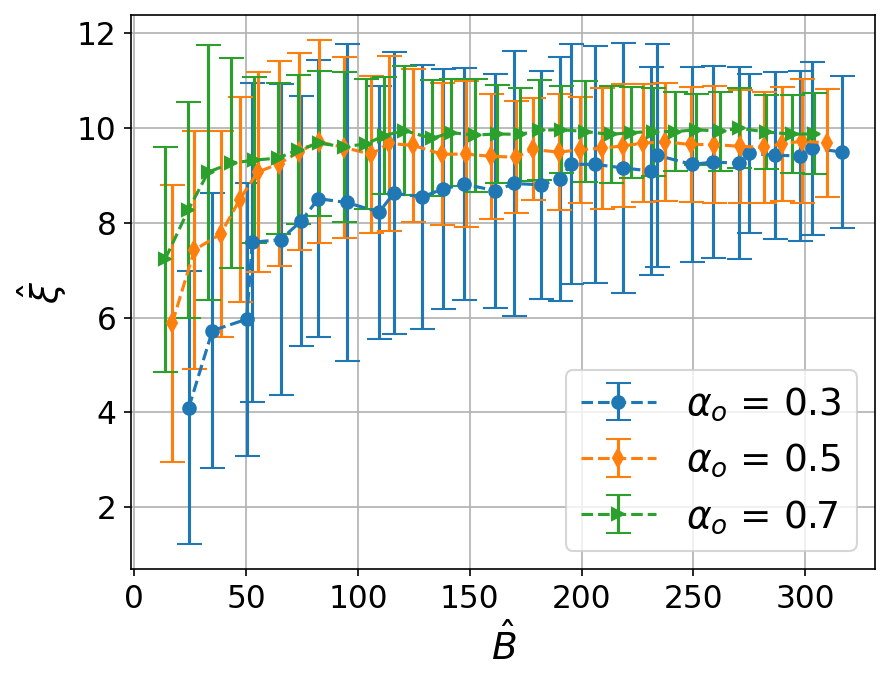

In [15]:
for i, j, k, l, m in zip(BMed, xiMed, xiMAD, alphaIn_, markers):
    plt.errorbar(i, j, const*k, label=fr'$\alpha_{{o}}$ = {l}', capsize=6, marker=m, linestyle='--')
plt.xlabel(r'$\hat{B}$', fontsize="18")
plt.ylabel(r'$\hat{\xi}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize="18", ncol=1)
plt.grid()
plt.savefig("./images/xiVarousAlpha.png", format="png", bbox_inches="tight", dpi=300)
# plt.savefig("./images/xiVarousAlpha_100.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

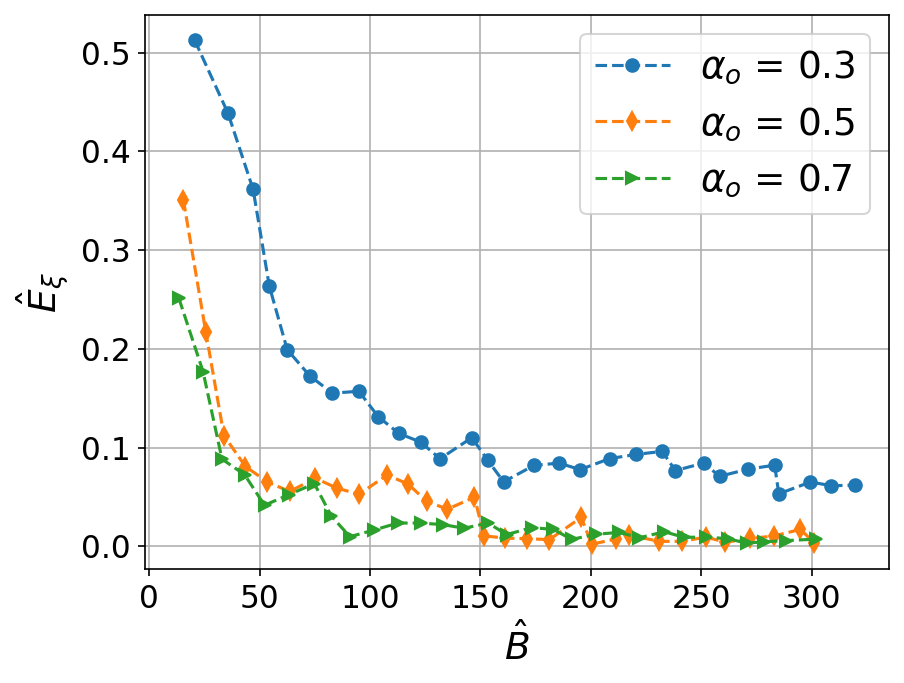

In [6]:
for i, j, l, m in zip(ExiMed, BMed, alphaIn_, markers):
    plt.plot(j, i, label=fr'$\alpha_o$ = {l}', marker=m, linestyle='--')
plt.xlabel(r'$\hat{B}$', fontsize="18")
plt.ylabel(r'$\hat{E}_{\xi}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
# plt.legend(fontsize="18", loc='center', bbox_to_anchor=(.6, .82), ncol=2)
plt.legend(fontsize="18", ncol=1)
plt.grid()
# plt.savefig("./images/errorXiVariousAlpha.png", format="png", bbox_inches="tight", dpi=300)
# plt.savefig("./images/errorXiVariousAlpha_100.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

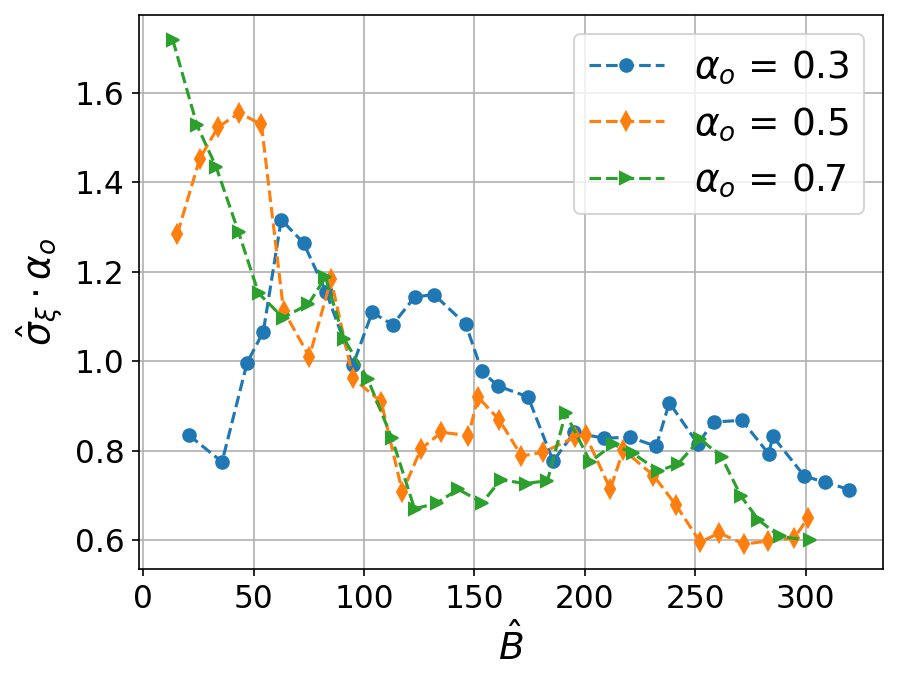

In [7]:
for i, j, k, l, m in zip(BMed, xiMed, xiMAD, alphaIn_, markers):
    plt.plot(i, const*k*l, label=fr'$\alpha_o$ = {l}', marker=m, linestyle='--')
plt.xlabel(r'$\hat{B}$', fontsize="18")
plt.ylabel(r'$\hat{\sigma}_{\xi} \cdot \alpha_o$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize="18", ncol=1)
plt.grid()
# plt.savefig("./images/sigmaXiVariousAlpha.png", format="png", bbox_inches="tight", dpi=300)
# plt.savefig("./images/sigmaXiVariousAlpha_100.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

Analysis of a real fracture surface (Steel 40Cr; high-cycle fatigue).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import CorrPy as cp

from statsmodels.tsa.stattools import adfuller

plt.rcParams['figure.dpi'] = 150

# Define a constant to recalculate median absolute deviation to standard deviation
const = 1.4826

In [2]:
# Load data
PWT = np.loadtxt('data/detrendDataPerp.csv', delimiter=',')
# PWT = np.loadtxt('data/2H2_Detrended.csv', delimiter=',')
deltaIn = .3013
# deltaIn = .42
# PWT = cp.subtractTrend(size=30, Profiles=PWT, method='gauss')
print(PWT.shape)

(3887, 100)


In [3]:
def testAdfuller(Profiles):
    pValLst = []
    critVal = []
    for indx in range(Profiles.shape[1]):
        profile = Profiles[:, indx]
        profile = profile[~np.isnan(profile)]
        res = adfuller(profile, regression='ct')
        pValLst.append(res[1])
        critVal.append(True if res[0] < res[4]['1%'] else False)
    return pValLst, critVal

In [4]:
pValLst, critVal = testAdfuller(PWT)

In [5]:
sum(critVal)

49

In [6]:
PWT_n = np.full([PWT.shape[0], sum(critVal) + 1], np.nan)

j = 1

for i in range(100):
    if critVal[i]:
        PWT_n[:, j] = PWT[:, i]
        j += 1
else:
    PWT = PWT_n

In [50]:
print(np.mean(pValLst))
print(np.median(pValLst))
print(np.max(pValLst))
print(np.min(pValLst))

0.11051378586757017
0.011673983149344966
0.994408805046819
1.3264840955373464e-06


In [28]:
# L = deltaIn*np.linspace(0, len(PWT[:,6]) - 1, len(PWT[:,6]))

# plt.plot(L, PWT[:,6])
# plt.show()

In [2]:
xiIn = 10
deltaXiIn = 0.01
deltaIn = deltaXiIn*xiIn

xiRef, PWT = cp.profileGenerator(alpha=0.5, omega=1, xi=xiIn, delta=deltaIn, length=1000, N=100)

In [3]:
PWT.shape

(10000, 100)

In [3]:
# Run a mowing window to find stationary region
step = 50 # In micrometers

step /= deltaIn # In points
step = int(step)
lengthIn = step + 1

l, N = PWT.shape

xiLst = np.full((l, N), np.nan)
iwLst = np.full((l, N), np.nan)
# alphaLst = np.full((5000, 90), np.nan)
    
for i in range(N): # Iterate over profiles
    A, IW = cp.loopOverProfileMWLIN(step=1, deltaMin=step, deltaMax=lengthIn, profile=PWT[:, i], method='acf', deviation='mad')
   
    if not np.sum(~np.isnan(A)):
        continue

    # H = np.sqrt(1 - A)

    xi = cp.correlationLength(deltaIn, A)
    # alpha = cp.selfAffineParameters(deltaIn, np.sqrt(1 - A), 'exponent', robust=False, cut_off=0.5)

    xiLst[0:xi.shape[1], i] = xi
    iwLst[0:xi.shape[1], i] = IW
    # alphaLst[0:xi.shape[1], i] = alpha

else:
    xiMed = np.nanmedian(xiLst,1)
    xiMAD = const*cp.mad(xiLst, 1, nan_policy='omit')

    iwMed = np.nanmedian(iwLst,1)
    iwMAD = const*cp.mad(iwLst, 1, nan_policy='omit')

    x = deltaIn*np.linspace(0, xiMed.shape[0]-1, xiMed.shape[0])

/tmp/ipykernel_9989/3685612658.py:30: RuntimeWarning: All-NaN slice encountered
  xiMed = np.nanmedian(xiLst,1)
/tmp/ipykernel_9989/3685612658.py:33: RuntimeWarning: All-NaN slice encountered
  iwMed = np.nanmedian(iwLst,1)


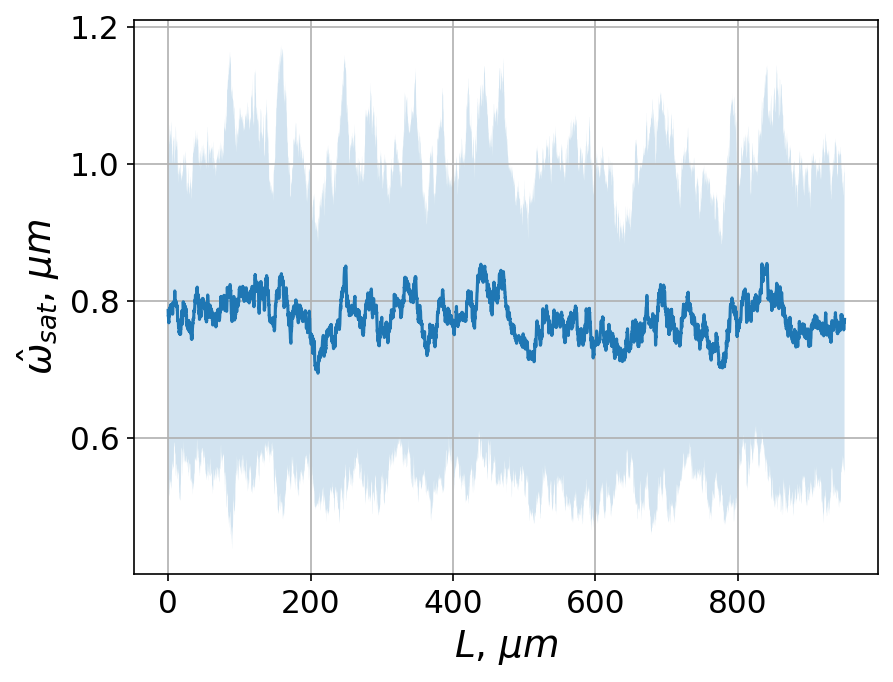

In [ ]:
plt.plot(x, const*iwMed)
plt.fill_between(x, const*(iwMed - iwMAD), const*(iwMed + iwMAD), alpha=0.2)
# plt.axhline(y=m1, color='r', linestyle='-')
# plt.axhline(y=m2, color='g', linestyle='-')
plt.ylabel(r'$\hat{\omega}_{sat}$, $\mu m$', fontsize="18")
plt.xlabel(r'$L$, $\mu m$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
# plt.savefig("./images/omegaMW.png", format="png", bbox_inches="tight", dpi=300)
# plt.savefig("./images/omegaMWSyntheticProfiles.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

In [3]:
step = 40
lengthIn = deltaIn*np.shape(PWT)[0]

print(lengthIn)

1171.1531


In [4]:
# Calculate the autocorrelation function
A, IW = cp.GrowingWindow(start=step, stop=lengthIn, step=step, Profiles=PWT,
                             delta=deltaIn, method='acf', deviation='mad')
    
# Calculate the Hurst function
H = np.sqrt(1 - A)
    
# Calculate the lateral correlation length
xi = cp.correlationLength(deltaIn, A)
    
# Calculate the self-affine exponent
alpha = cp.selfAffineParameters(deltaIn, H, 'exponent', robust=False)

/home/aleksandr/ownCloud/Data/First Study/Articles/PRL_UQ/Data/CorrPy.py:415: RuntimeWarning: divide by zero encountered in power
  return a*pow(x,b)


In [5]:
X = np.linspace(step, lengthIn, len(xi)).reshape(-1,1)

# Calculate median and median absolute deviation
xiMed = np.nanmedian(xi, 1)
xiMAD = cp.mad(xi, 1, nan_policy='omit')
xiSTD = np.nanstd(xi, axis=1)

iwMed = np.nanmedian(IW, 1)
iwMAD = cp.mad(IW, 1, nan_policy='omit')
iwSTD = np.nanstd(IW, axis=1)

alphaMed = np.nanmedian(alpha, 1)
alphaMAD = cp.mad(alpha, 1, nan_policy='omit')
alphaSTD = np.nanstd(alpha, axis=1)

# Calculate the B-coefficient
B = X/xi;

BMed = np.nanmedian(B, 1)
BMAD = cp.mad(B, 1, nan_policy='omit')

# Calculate Delta_{xi}
deltaXi = deltaIn/xi
dXMed = np.nanmedian(deltaXi, 1)
dXMAD = cp.mad(deltaXi, 1, nan_policy='omit')

# Calculate errors
sysXiError = cp.systematicErrorXi(BMed, xiMed)
randXiError = const*xiMAD/np.sqrt(PWT.shape[1])
xiErr = cp.fullError(sysXiError, const*xiMAD/np.sqrt(PWT.shape[1]))

sysAlphaError = cp.systematicErrorAlpha(BMed, alphaMed)
randAlphaError = const*alphaMAD/np.sqrt(PWT.shape[1])
alphaErr = cp.fullError(sysAlphaError, const*alphaMAD/np.sqrt(PWT.shape[1]))


xiErrRatio = sysXiError/(const*xiMAD/np.sqrt(PWT.shape[1]))
alphaErrRatio = sysAlphaError/(const*alphaMAD/np.sqrt(PWT.shape[1]))

In [6]:
X_train, X_test, y_train, y_test = cp.train_test_split(X, BMed, shuffle=True, test_size=0.3)
# SRegr = cp.LinearRegression(n_jobs=-1)
SRegr = cp.HuberRegressor(epsilon=1.1)

SRegr.fit(X_train, y_train)
BPred = SRegr.predict(X)

In [7]:
print(*SRegr.coef_)
print(SRegr.intercept_)

0.03493507165281755
6.629933055791417


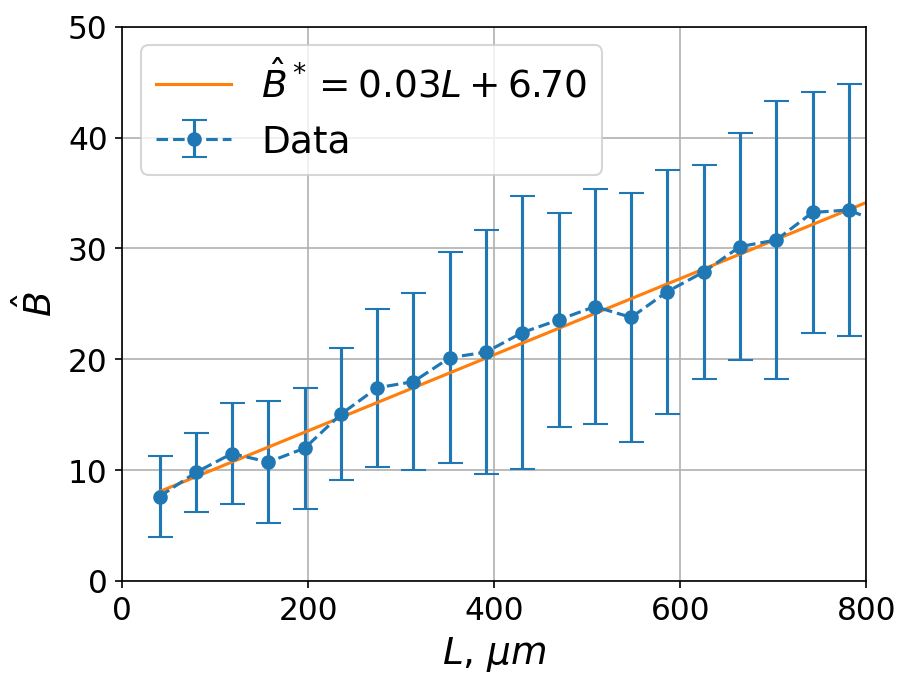

In [18]:
plt.errorbar(X, BMed, const*BMAD, capsize=6, marker='o', linestyle='--', label='Data')
plt.plot(X, BPred, label=fr"$\hat{{B}}^* = {SRegr.coef_[0]:.2f}L + {SRegr.intercept_:.2f}$")
plt.xlabel(r'$L$, $\mu m$', fontsize="18")
plt.ylabel(r'$\hat{B}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize="18", ncol=1)
plt.grid()
plt.xlim([0, 800])
plt.ylim([0, 50])
# plt.savefig("./images/BData.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

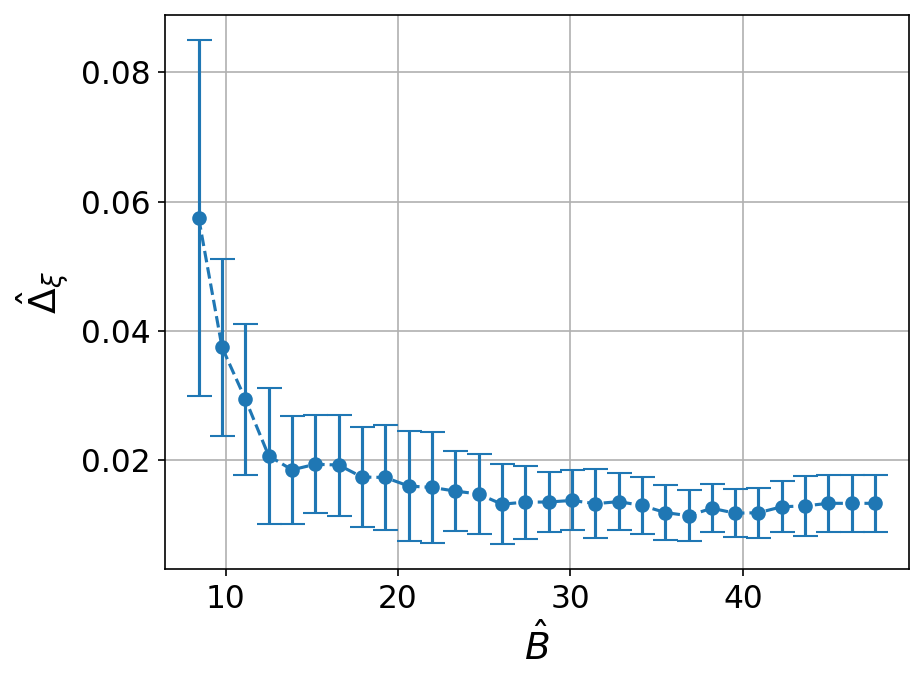

In [11]:
plt.errorbar(BPred, dXMed, const*dXMAD, capsize=6, marker='o', linestyle='--')
plt.xlabel(r'$\hat{B}$', fontsize="18")
plt.ylabel(r'$\hat{\Delta}_{\xi}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
# plt.xlim([0, 800])
# plt.ylim([0, 50])
# plt.savefig("./images/dXData.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

In [12]:
print(f"Average number of points per unit correlation length is {dXMed[-1]:.3f}.")
print(f"Data deviation of number of points per unit correlation length is {const*dXMAD[-1]:.3f}.")

Average number of points per unit correlation length is 0.013.
Data deviation of number of points per unit correlation length is 0.004.


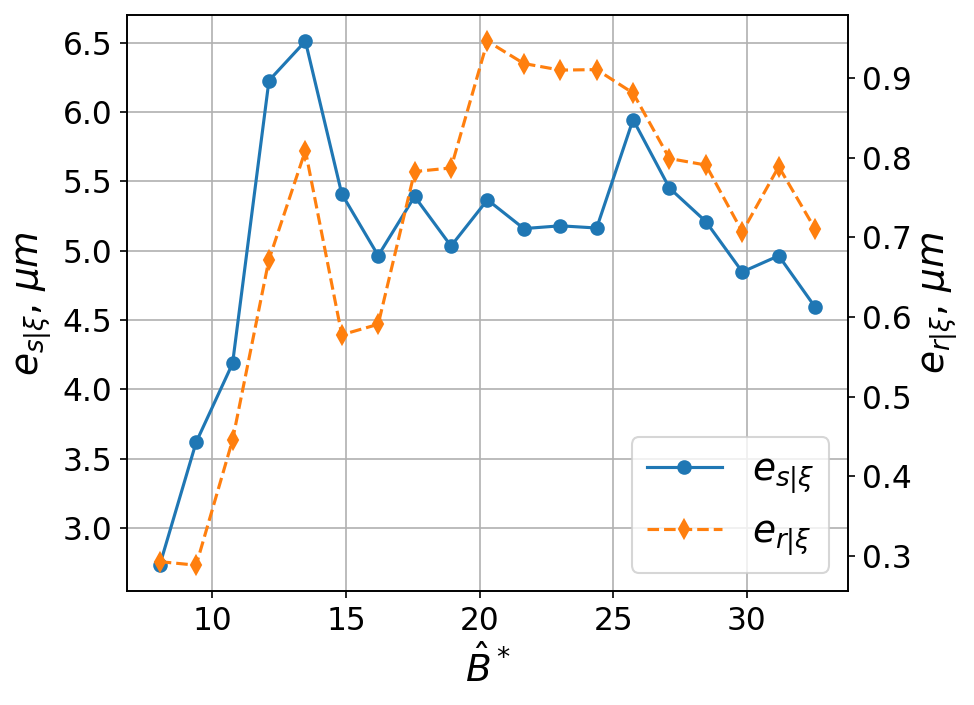

In [11]:
fig, ax1 = plt.subplots()


ax1.set_xlabel(r'$\hat{B}^*$', fontsize="18")
ax1.set_ylabel(r'$e_{s|\xi}$, $\mu m$', fontsize="18")
ax1.plot(BPred[:-11], sysXiError[:-11], label=r'$e_{s|\xi}$', marker='o')
# ax1.plot(BPred[:-11], randXiError[:-11], label=r'$e_{r|\xi}$', marker='d')
ax1.tick_params(axis='both', labelsize=15)
# ax1.legend(fontsize="18", ncol=1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel(r'$e_{r|\xi}$, $\mu m$', fontsize="18")  # we already handled the x-label with ax1
ax2.plot(BPred[:-11], randXiError[:-11], label=r'$e_{r|\xi}$', marker='d', color='tab:orange', linestyle='--')
# ax2.plot(BPred[:-11], xiErrRatio[:-11], marker='>', color='tab:green', label=r'$e_{s|\xi}/e_{r|\xi}$')
ax2.tick_params(axis='y', labelsize=15)


h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=0, fontsize="18", ncol=1)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.grid()
plt.savefig("./images/xiDataErrRatioB.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

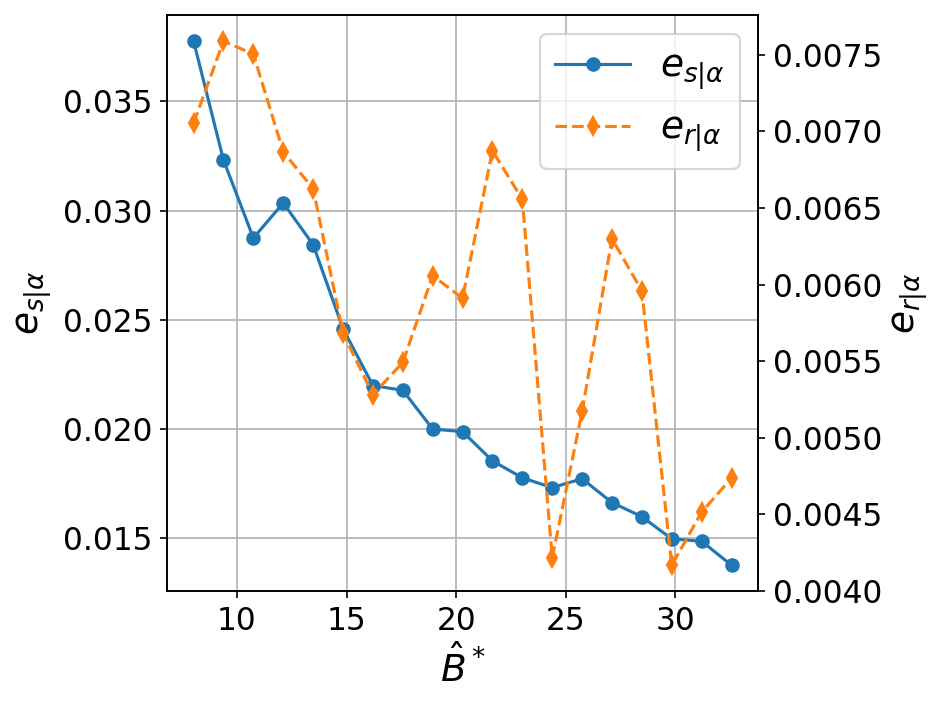

In [12]:
fig, ax1 = plt.subplots()


ax1.set_xlabel(r'$\hat{B}^*$', fontsize="18")
ax1.set_ylabel(r'$e_{s|\alpha}$', fontsize="18")
ax1.plot(BPred[:-11], sysAlphaError[:-11], label=r'$e_{s|\alpha}$', marker='o')
# ax1.plot(BPred[:-11], randAlphaError[:-11], label=r'$e_{r|\alpha}$', marker='d')
ax1.tick_params(axis='both', labelsize=15)
ax1.legend(fontsize="18", ncol=1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.set_ylabel(r'$e_{r|\alpha}$', fontsize="18")  # we already handled the x-label with ax1
ax2.plot(BPred[:-11], randAlphaError[:-11], label=r'$e_{r|\alpha}$', marker='d', color='tab:orange', linestyle='--')
# ax2.plot(BPred[:-11], alphaErrRatio[:-11], marker='>', color='tab:green', label=r'$e_{s|\alpha}/e_{r|\alpha}$')
ax2.tick_params(axis='y', labelsize=15)
# # ax2.legend(fontsize="18")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=0, fontsize="18", ncol=1)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.grid()
plt.savefig("./images/alphaDataErrRatioB.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

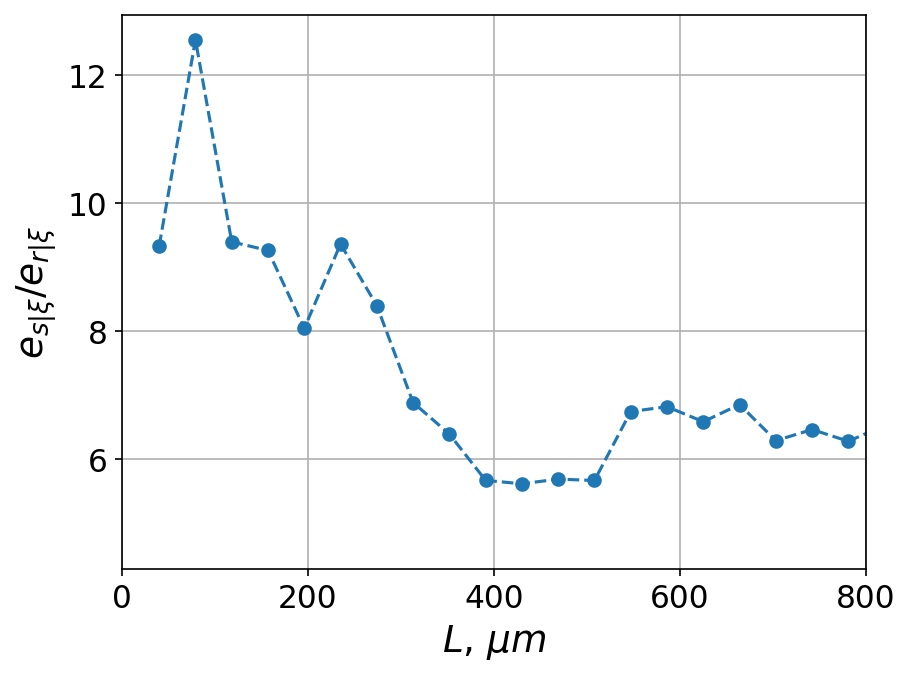

In [13]:
plt.plot(X, xiErrRatio, marker='o', linestyle='--')
plt.xlabel(r'$L$, $\mu m$', fontsize="18")
plt.ylabel(r'$e_{s|\xi}/e_{r|\xi}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
plt.xlim([0, 800])
# plt.ylim([0, 50])
# plt.savefig("./images/xiDataErrRatio.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

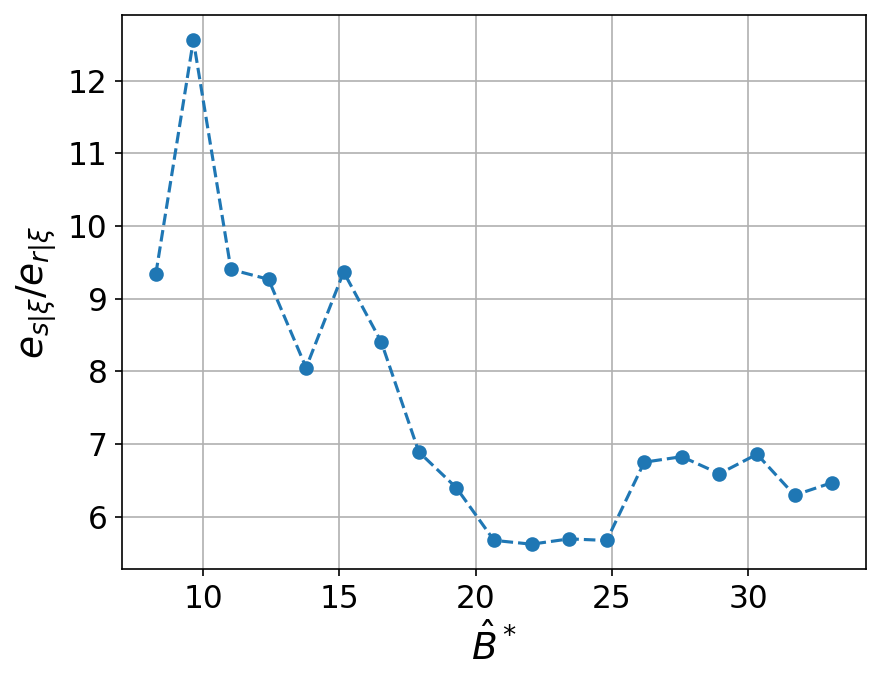

In [45]:
plt.plot(BPred[:-11], xiErrRatio[:-11], marker='o', linestyle='--')
# plt.plot(BMed[:-11], xiErrRatio[:-11], marker='o', linestyle='--')
plt.xlabel(r'$\hat{B}^*$', fontsize="18")
plt.ylabel(r'$e_{s|\xi}/e_{r|\xi}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
# plt.xlim([0, 800])
# plt.ylim([0, 50])
plt.savefig("./images/xiDataErrRatioB.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

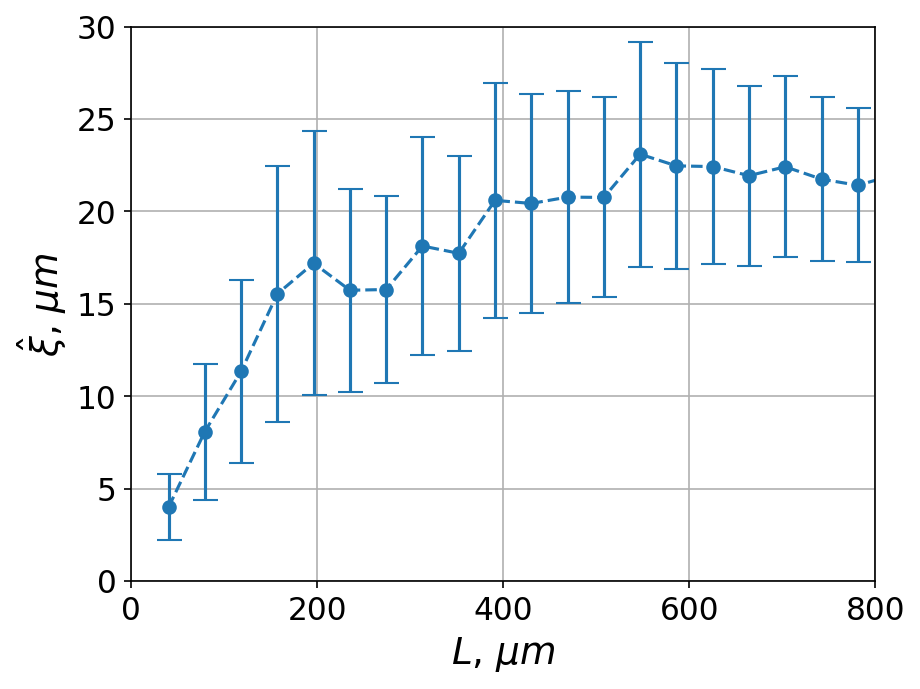

In [12]:
plt.errorbar(X, xiMed, xiErr, capsize=6, marker='o', linestyle='--')
plt.xlabel(r'$L$, $\mu m$', fontsize="18")
plt.ylabel(r'$\hat{\xi}$, $\mu m$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
plt.xlim([0, 800])
plt.ylim([0, 30])
# plt.savefig("./images/xiDataErr.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

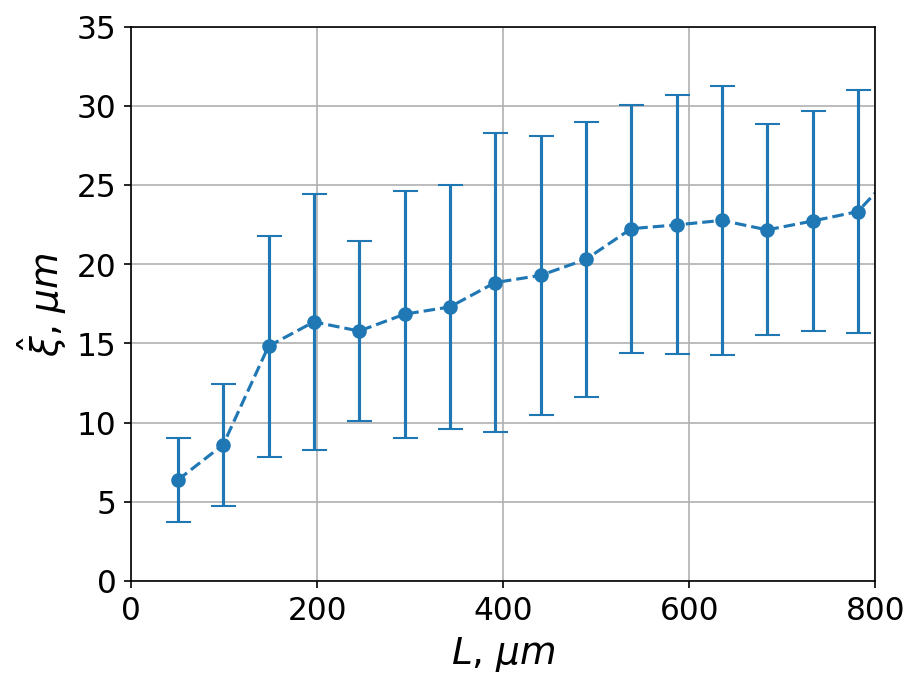

In [49]:
plt.errorbar(X, xiMed, const*xiMAD, capsize=6, marker='o', linestyle='--')
plt.xlabel(r'$L$, $\mu m$', fontsize="18")
plt.ylabel(r'$\hat{\xi}$, $\mu m$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
plt.xlim([0, 800])
plt.ylim([0, 35])
# plt.savefig("./images/xiDataDeviation.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

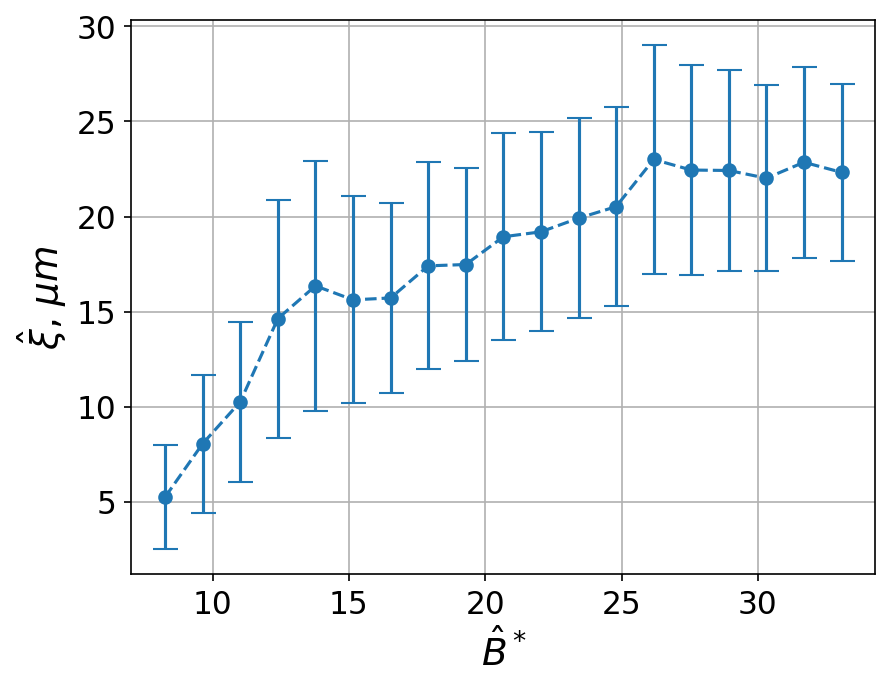

In [46]:
plt.errorbar(BPred[:-11], xiMed[:-11], xiErr[:-11], capsize=6, marker='o', linestyle='--')
plt.xlabel(r'$\hat{B}^*$', fontsize="18")
plt.ylabel(r'$\hat{\xi}$, $\mu m$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
# plt.xlim([8, 35])
plt.savefig("./images/xiDataB.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

In [11]:
print(f"The B-coefficient is {BMed[-1]:.3f}")
print(f"The standard deviation of B is {BMAD[-1]:.3f}")
print()
print(f"The median value of LCL is {xiMed[-1]:.3f}")
print(f"The standard deviation of LCL is {const*xiMAD[-1]:.3f}")
print(f"The standard error of LCL is {1/np.sqrt(90)*const*xiMAD[-1]:.3f}")
print(f"""With the probability of 99.7%, the true value of LCL lies in the range of 
      [{xiMed[-1]-3/np.sqrt(90)*const*xiMAD[-1]:.3f}...{xiMed[-1]+3/np.sqrt(90)*const*xiMAD[-1]:.3f}]""")

The B-coefficient is 51.453
The standard deviation of B is 11.557

The median value of LCL is 22.762
The standard deviation of LCL is 7.247
The standard error of LCL is 0.764
With the probability of 99.7%, the true value of LCL lies in the range of 
      [20.470...25.053]


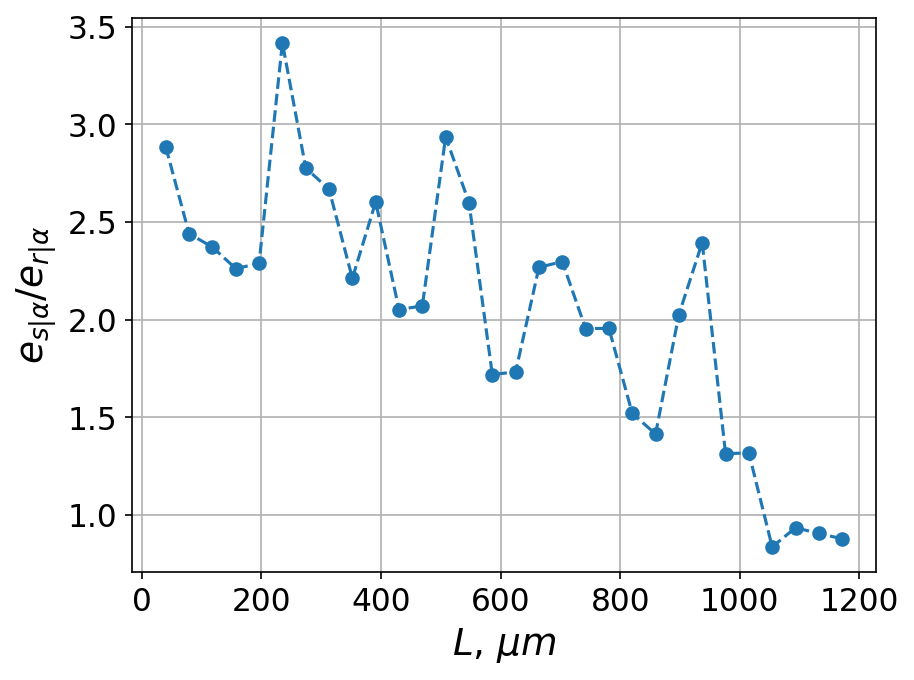

In [14]:
plt.plot(X, sysAlphaError/(const*alphaMAD/np.sqrt(PWT.shape[1])), marker='o', linestyle='--')
plt.xlabel(r'$L$, $\mu m$', fontsize="18")
plt.ylabel(r'$e_{s|\alpha}/e_{r|\alpha}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
# plt.xlim([0, 800])
# plt.ylim([2.5, 8.5])
# plt.savefig("./images/alphaDataErrRatio.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

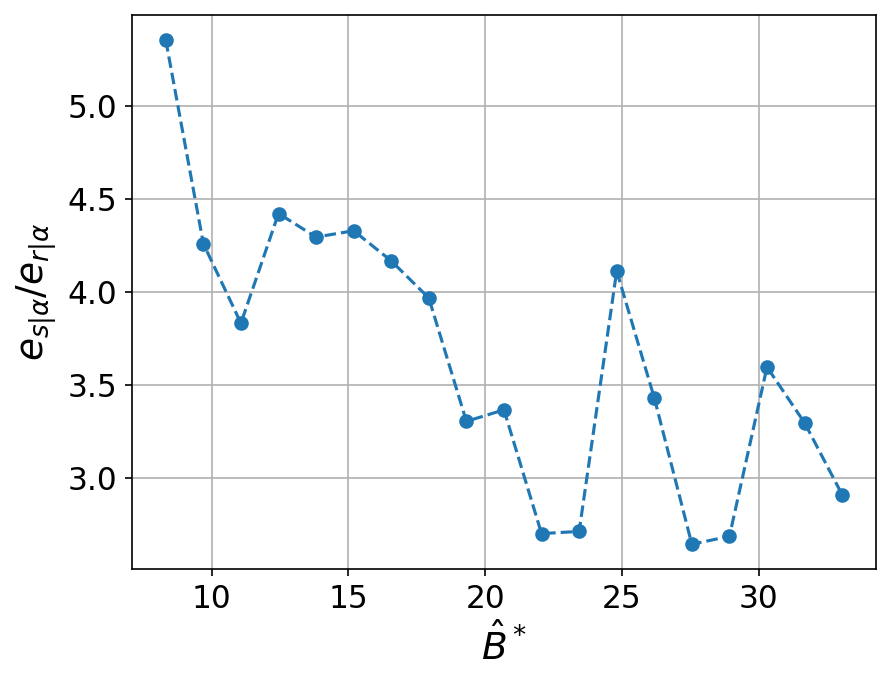

In [23]:
plt.plot(BPred[:-11], alphaErrRatio[:-11], marker='o', linestyle='--')
# plt.plot(BMed[:-11], alphaErrRatio[:-11], marker='o', linestyle='--')
plt.xlabel(r'$\hat{B}^*$', fontsize="18")
plt.ylabel(r'$e_{s|\alpha}/e_{r|\alpha}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
# plt.xlim([0, 800])
# plt.ylim([0, 50])
plt.savefig("./images/alphaDataErrRatioB.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

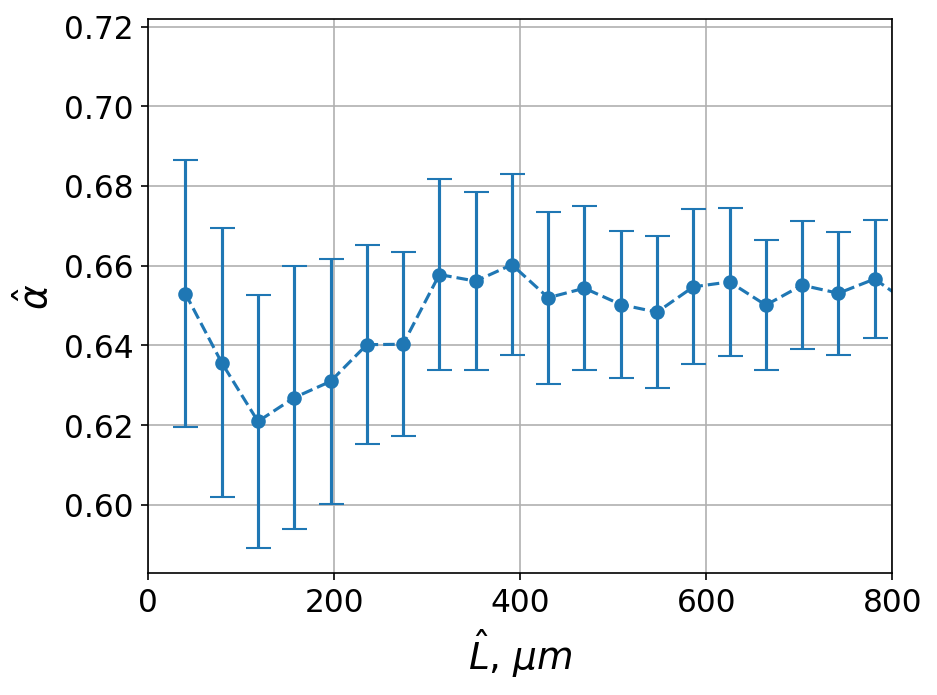

In [16]:
plt.errorbar(X, alphaMed, alphaErr, capsize=6, marker='o', linestyle='--')
plt.xlabel(r'$\hat{L}$, $\mu m$', fontsize="18")
plt.ylabel(r'$\hat{\alpha}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
plt.xlim([0, 800])
# plt.ylim([0, 30])
# plt.savefig("./images/alphaDataErr.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

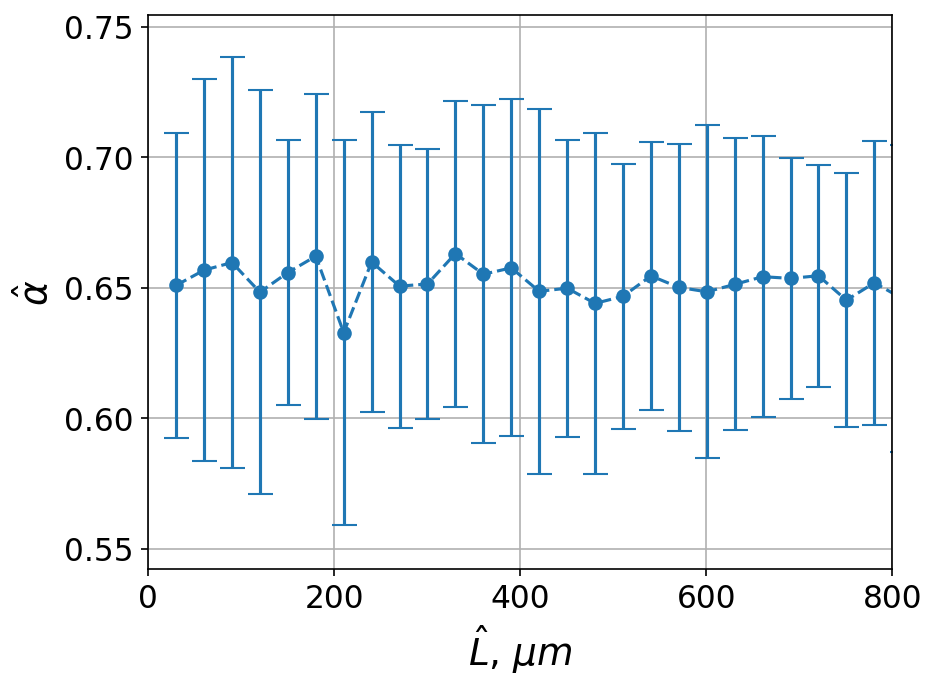

In [35]:
plt.errorbar(X, alphaMed, const*alphaMAD, capsize=6, marker='o', linestyle='--')
plt.xlabel(r'$\hat{L}$, $\mu m$', fontsize="18")
plt.ylabel(r'$\hat{\alpha}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
plt.xlim([0, 800])
# plt.ylim([0, 30])
# plt.savefig("./images/alphaDataDeviation.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

In [48]:
print(alphaMed[-11])
print(alphaErr[-11])

0.6466890636755003
0.014623927169205351


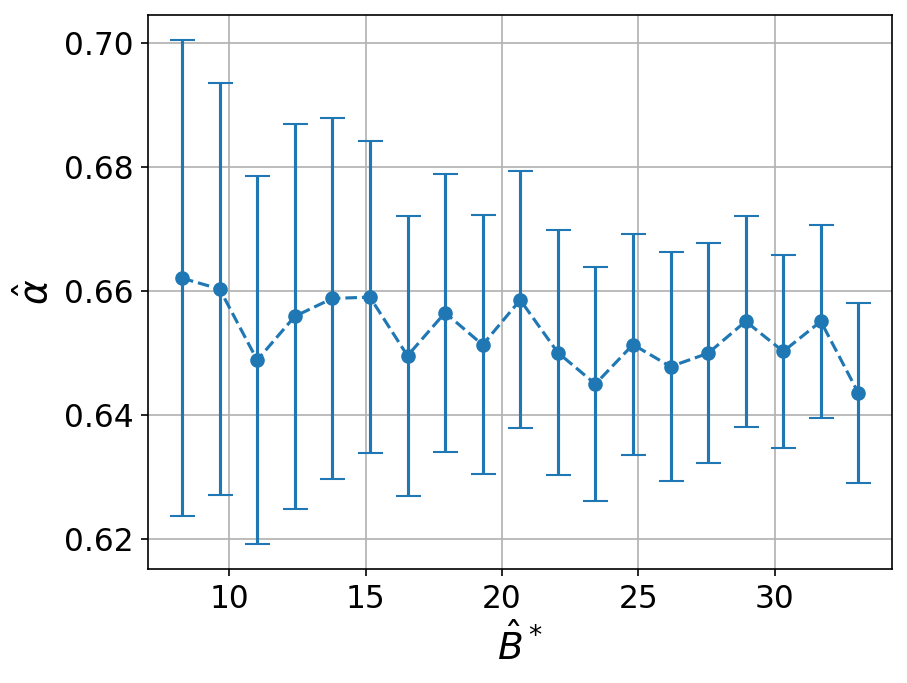

In [49]:
plt.errorbar(BPred[:-11], alphaMed[:-11], alphaErr[:-11], capsize=6, marker='o', linestyle='--')
plt.xlabel(r'$\hat{B}^*$', fontsize="18")
plt.ylabel(r'$\hat{\alpha}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
# plt.xlim([8, 35])
plt.savefig("./images/alphaDataB.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

In [24]:
print(fr"The median value of self-affine exponent is {alphaMed[-1]:.3f}")
print(f"The standard deviation of self-affine exponent is {const*alphaMAD[-1]:.3f}")
print(f"The standard error of self-affine exponent is {1/np.sqrt(90)*const*alphaMAD[-1]:.3f}")
print(f"""With the probability of 99.7%, the true value of self-affine exponent lies in the range of 
      [{alphaMed[-1]-3/np.sqrt(90)*const*alphaMAD[-1]:.3f}...{alphaMed[-1]+3/np.sqrt(90)*const*alphaMAD[-1]:.3f}]""")

The median value of self-affine exponent is 0.659
The standard deviation of self-affine exponent is 0.086
The standard error of self-affine exponent is 0.009
With the probability of 99.7%, the true value of self-affine exponent lies in the range of 
      [0.632...0.686]


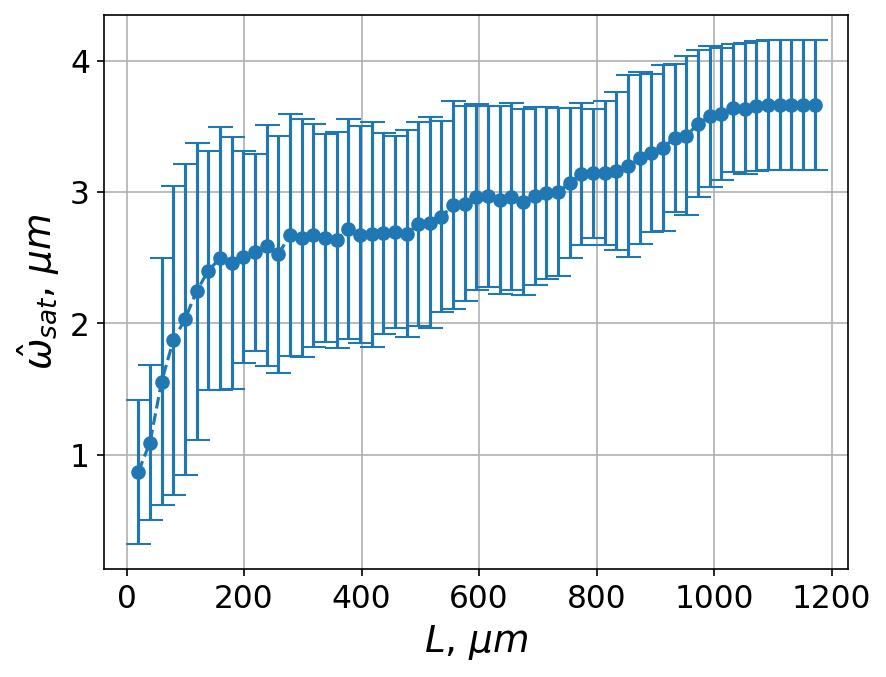

In [22]:
plt.errorbar(X, const*iwMed, const*const*iwMAD, capsize=6, marker='o', linestyle='--')
plt.xlabel(r'$L$, $\mu m$', fontsize="18")
plt.ylabel(r'$\hat{\omega}_{sat}$, $\mu m$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
# plt.savefig("./images/omegaDataDeviation.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

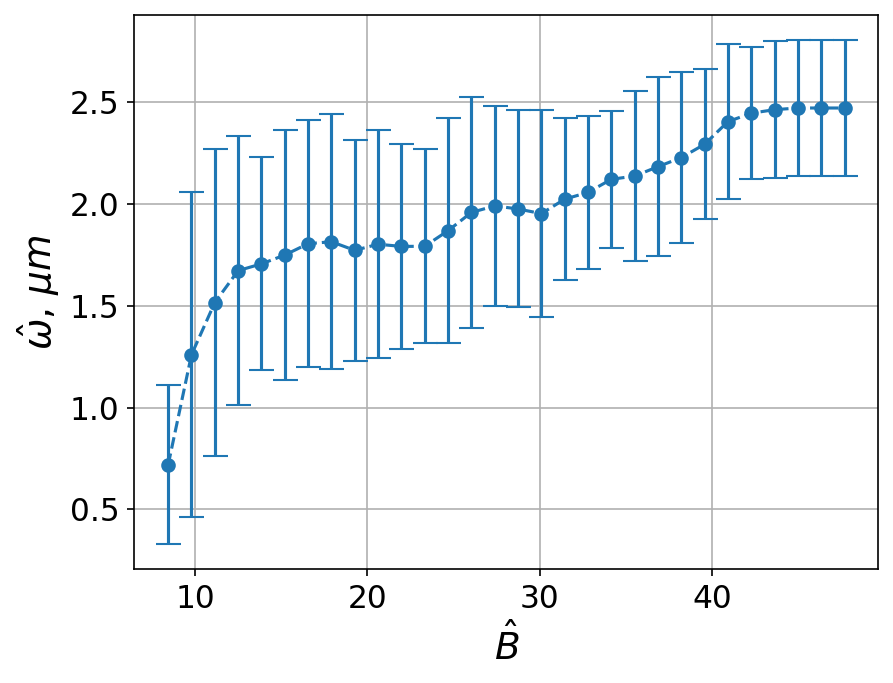

In [25]:
plt.errorbar(BPred, iwMed, const*iwMAD, capsize=6, marker='o', linestyle='--')
plt.xlabel(r'$\hat{B}$', fontsize="18")
plt.ylabel(r'$\hat{\omega}$, $\mu m$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
# plt.savefig("./images/xiData.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

Transpose data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import CorrPy as cp

from statsmodels.tsa.stattools import adfuller

plt.rcParams['figure.dpi'] = 150

# Define a constant to recalculate median absolute deviation to standard deviation
const = 1.4826

In [2]:
PWT = np.loadtxt('data/detrendDataParallel_mid.csv', delimiter=',')
deltaIn = .3018
print(PWT.shape)

(7731, 100)


In [28]:
pValLst, critVal = testAdfuller(PWT)

In [30]:
sum(critVal)

83

In [49]:
PWT_n = np.full([PWT.shape[0], sum(critVal) + 1], np.nan)

j = 1

for i in range(100):
    if critVal[i]:
        PWT_n[:, j] = PWT[:, i]
        j += 1
else:
    PWT = PWT_n

In [9]:
# Run a mowing window to find stationary region
step = 50 # In micrometers

step /= deltaIn # In points
step = int(step)
lengthIn = step + 1

l, N = PWT.shape

xiLst = np.full((l, N), np.nan)
iwLst = np.full((l, N), np.nan)
# alphaLst = np.full((5000, 90), np.nan)
    
for i in range(N): # Iterate over profiles
    A, IW = cp.loopOverProfileMWLIN(step=1, deltaMin=step, deltaMax=lengthIn, profile=PWT[:, i], method='acf', deviation='mad')
   
    if not np.sum(~np.isnan(A)):
        continue

    # H = np.sqrt(1 - A)

    xi = cp.correlationLength(deltaIn, A)
    # alpha = cp.selfAffineParameters(deltaIn, np.sqrt(1 - A), 'exponent', robust=False, cut_off=0.5)

    xiLst[0:xi.shape[1], i] = xi
    iwLst[0:xi.shape[1], i] = IW
    # alphaLst[0:xi.shape[1], i] = alpha

else:
    xiMed = np.nanmedian(xiLst,1)
    xiMAD = const*cp.mad(xiLst, 1, nan_policy='omit')

    iwMed = np.nanmedian(iwLst,1)
    iwMAD = const*cp.mad(iwLst, 1, nan_policy='omit')

    x = deltaIn*np.linspace(0, xiMed.shape[0]-1, xiMed.shape[0])

/tmp/ipykernel_9989/3685612658.py:30: RuntimeWarning: All-NaN slice encountered
  xiMed = np.nanmedian(xiLst,1)
/tmp/ipykernel_9989/3685612658.py:33: RuntimeWarning: All-NaN slice encountered
  iwMed = np.nanmedian(iwLst,1)


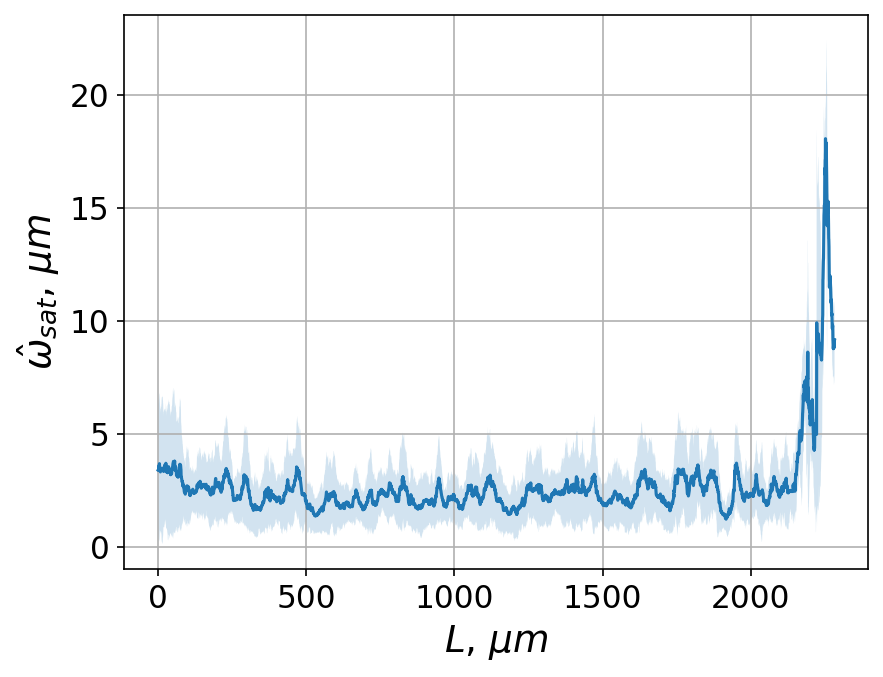

In [10]:
plt.plot(x, const*iwMed)
plt.fill_between(x, const*(iwMed - iwMAD), const*(iwMed + iwMAD), alpha=0.2)
plt.ylabel(r'$\hat{\omega}_{sat}$, $\mu m$', fontsize="18")
plt.xlabel(r'$L$, $\mu m$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
plt.savefig("./images/omegaMWParallelMid.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
# PWT = PWT[2000:6000, :]

In [3]:
step = 50
lengthIn = deltaIn*np.shape(PWT)[0]
print(lengthIn)

2333.2158


In [4]:
# Calculate the autocorrelation function
A, IW = cp.GrowingWindow(start=step, stop=lengthIn, step=step, Profiles=PWT,
                             delta=deltaIn, method='acf', deviation='mad')
    
# Calculate the Hurst function
H = np.sqrt(1 - A)
    
# Calculate the lateral correlation length
xi = cp.correlationLength(deltaIn, A)
    
# Calculate the self-affine exponent
alpha = cp.selfAffineParameters(deltaIn, H, 'exponent', robust=False)

In [5]:
X = np.linspace(step, lengthIn, len(xi)).reshape(-1,1)

# Calculate median and median absolute deviation
xiMed = np.nanmedian(xi, 1)
xiMAD = cp.mad(xi, 1, nan_policy='omit')
xiSTD = np.nanstd(xi, axis=1)

iwMed = np.nanmedian(IW, 1)
iwMAD = cp.mad(IW, 1, nan_policy='omit')
iwSTD = np.nanstd(IW, axis=1)

alphaMed = np.nanmedian(alpha, 1)
alphaMAD = cp.mad(alpha, 1, nan_policy='omit')
alphaSTD = np.nanstd(alpha, axis=1)

# Calculate the B-coefficient
B = X/xi;

BMed = np.nanmedian(B, 1)
BMAD = cp.mad(B, 1, nan_policy='omit')

# Calculate Delta_{xi}
deltaXi = deltaIn/xi
dXMed = np.nanmedian(deltaXi, 1)
dXMAD = cp.mad(deltaXi, 1, nan_policy='omit')

# Calculate errors
sysXiError = cp.systematicErrorXi(BMed, xiMed)
randXiError = const*xiMAD/PWT.shape[1]
xiErr = cp.fullError(sysXiError, const*xiMAD/PWT.shape[1])

sysAlphaError = cp.systematicErrorAlpha(BMed, alphaMed)
randAlphaError = const*alphaMAD/PWT.shape[1]
alphaErr = cp.fullError(sysAlphaError, const*alphaMAD/PWT.shape[1])

xiErrRatio = sysXiError/(const*xiMAD/np.sqrt(PWT.shape[1]))
alphaErrRatio = sysAlphaError/(const*alphaMAD/np.sqrt(PWT.shape[1]))

In [6]:
X = X[:-26]
BMed = BMed[:-26]
BMAD = BMAD[:-26]

In [7]:
X_train, X_test, y_train, y_test = cp.train_test_split(X, BMed, shuffle=True, test_size=0.4)
# SRegr = cp.LinearRegression(n_jobs=-1)
SRegr = cp.HuberRegressor(epsilon=1.3)

SRegr.fit(X_train, y_train)
BPred = SRegr.predict(X)

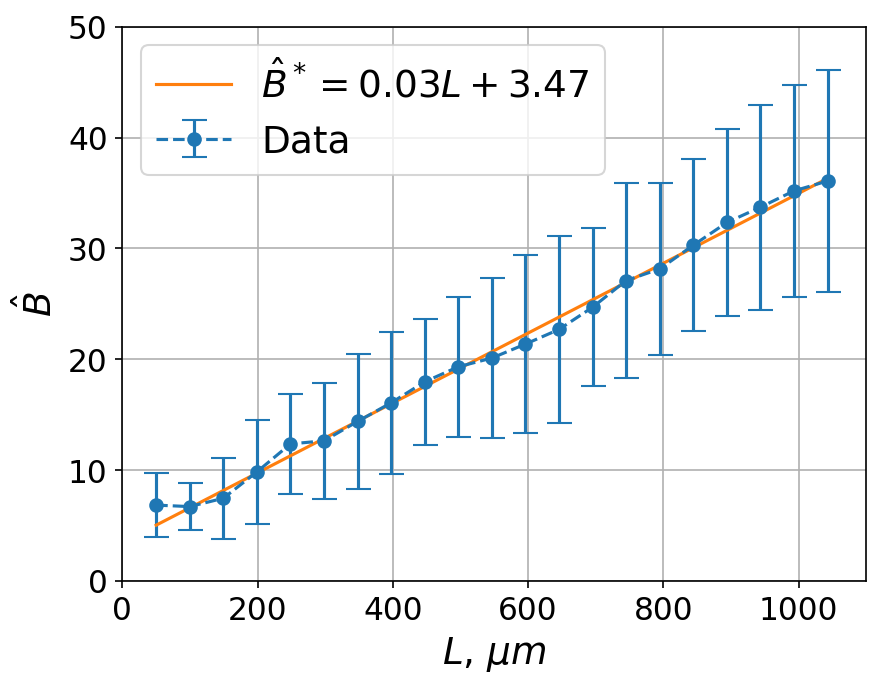

In [79]:
plt.errorbar(X, BMed, const*BMAD, capsize=6, marker='o', linestyle='--', label='Data')
plt.plot(X, BPred, label=fr"$\hat{{B}}^* = {SRegr.coef_[0]:.2f}L + {SRegr.intercept_:.2f}$")
plt.xlabel(r'$L$, $\mu m$', fontsize="18")
plt.ylabel(r'$\hat{B}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize="18", ncol=1)
plt.grid()
plt.xlim([0, 1100])
plt.ylim([0, 50])
# plt.savefig("./images/BDataParallel.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

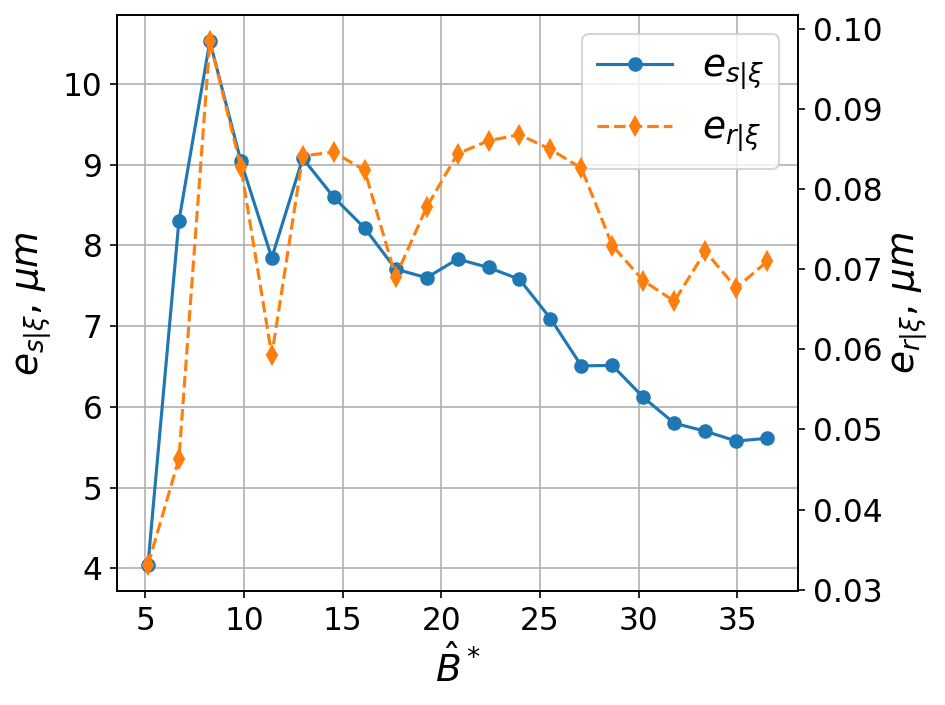

In [25]:
fig, ax1 = plt.subplots()


ax1.set_xlabel(r'$\hat{B}^*$', fontsize="18")
ax1.set_ylabel(r'$e_{s|\xi}$, $\mu m$', fontsize="18")
ax1.plot(BPred, sysXiError[:-26], label=r'$e_{s|\xi}$', marker='o')
# ax1.plot(BPred, randXiError[:-26], label=r'$e_{r|\xi}$', marker='d')
ax1.tick_params(axis='both', labelsize=15)
# ax1.legend(fontsize="18", ncol=1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel(r'$e_{r|\xi}$, $\mu m$', fontsize="18")  # we already handled the x-label with ax1
# ax2.plot(BPred, xiErrRatio[:-26], marker='>', color='tab:green', label=r'$e_{s|\xi}/e_{r|\xi}$')
ax2.plot(BPred, randXiError[:-26], label=r'$e_{r|\xi}$', marker='d', color='tab:orange', linestyle='--')
ax2.tick_params(axis='y', labelsize=15)
# # ax2.legend(fontsize="18")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=0, fontsize="18", ncol=1)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.grid()
plt.savefig("./images/xiDataParallelErrRatioB.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

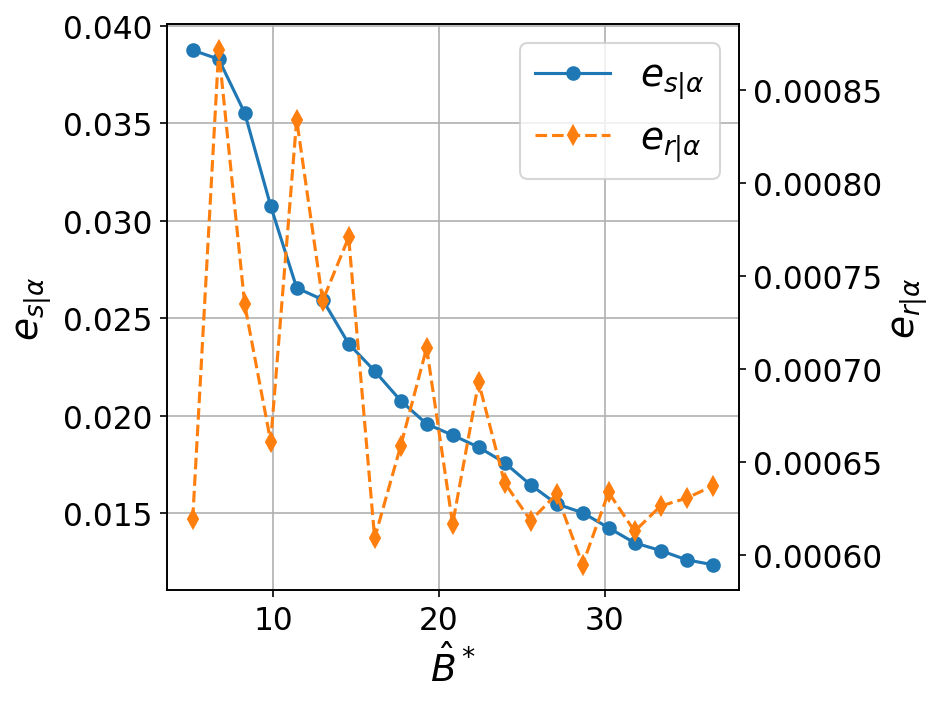

In [29]:
fig, ax1 = plt.subplots()


ax1.set_xlabel(r'$\hat{B}^*$', fontsize="18")
ax1.set_ylabel(r'$e_{s|\alpha}$', fontsize="18")
ax1.plot(BPred, sysAlphaError[:-26], label=r'$e_{s|\alpha}$', marker='o')
# ax1.plot(BPred, randAlphaError[:-26], label=r'$e_{r|\alpha}$', marker='d')
ax1.tick_params(axis='both', labelsize=15)
# ax1.legend(fontsize="18", ncol=1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel(r'$e_{r|\alpha}$', fontsize="18")  # we already handled the x-label with ax1
ax2.plot(BPred, randAlphaError[:-26], label=r'$e_{r|\alpha}$', marker='d', color='tab:orange', linestyle='--')
# ax2.plot(BPred, alphaErrRatio[:-26], marker='>', color='tab:green', label=r'$e_{s|\alpha}/e_{r|\alpha}$')
ax2.tick_params(axis='y', labelsize=15)
# ax2.legend(fontsize="18")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=0, fontsize="18", ncol=1)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.grid()
plt.savefig("./images/alphaDataParallelErrRatioB.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

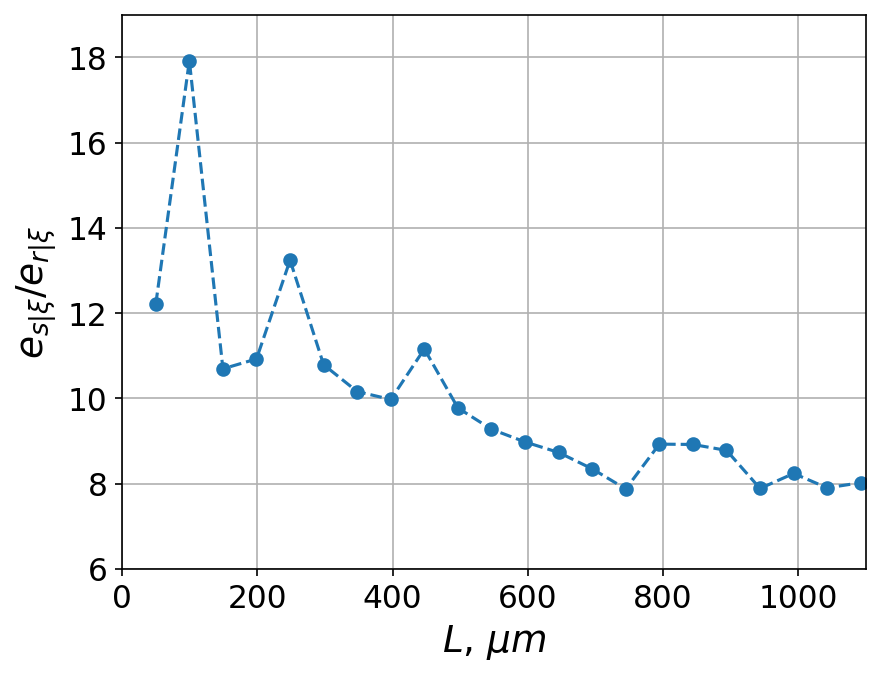

In [99]:
plt.plot(X, xiErrRatio, marker='o', linestyle='--')
plt.xlabel(r'$L$, $\mu m$', fontsize="18")
plt.ylabel(r'$e_{s|\xi}/e_{r|\xi}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
plt.xlim([0, 1100])
plt.ylim([6, 19])
plt.savefig("./images/xiDataParallelErrRatio.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

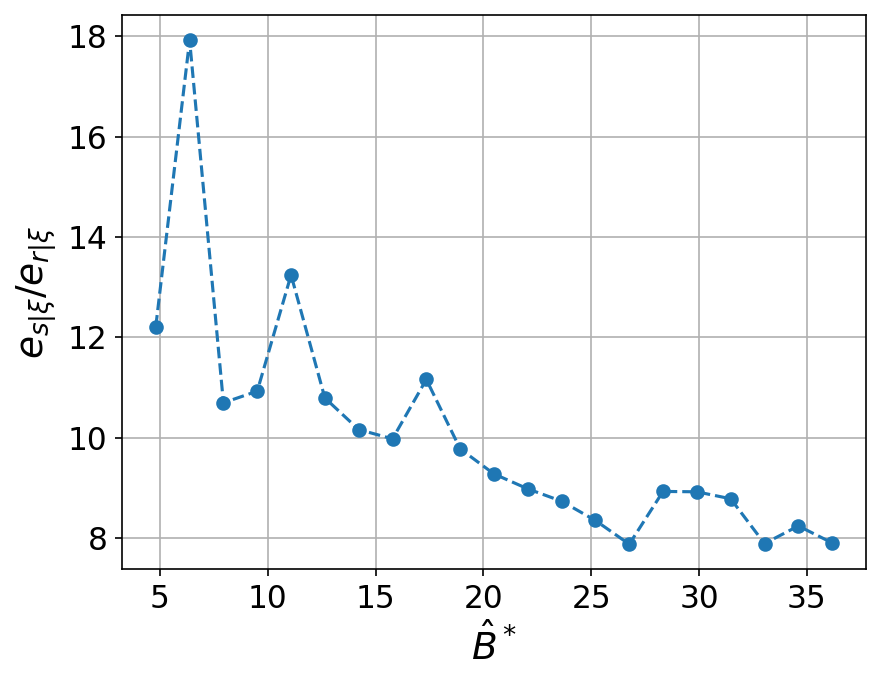

In [21]:
plt.plot(BPred, xiErrRatio[:-26], marker='o', linestyle='--')
plt.xlabel(r'$\hat{B}^*$', fontsize="18")
plt.ylabel(r'$e_{s|\xi}/e_{r|\xi}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
# plt.xlim([0, 1100])
# plt.ylim([6, 19])
plt.savefig("./images/xiDataParallelErrRatioB.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

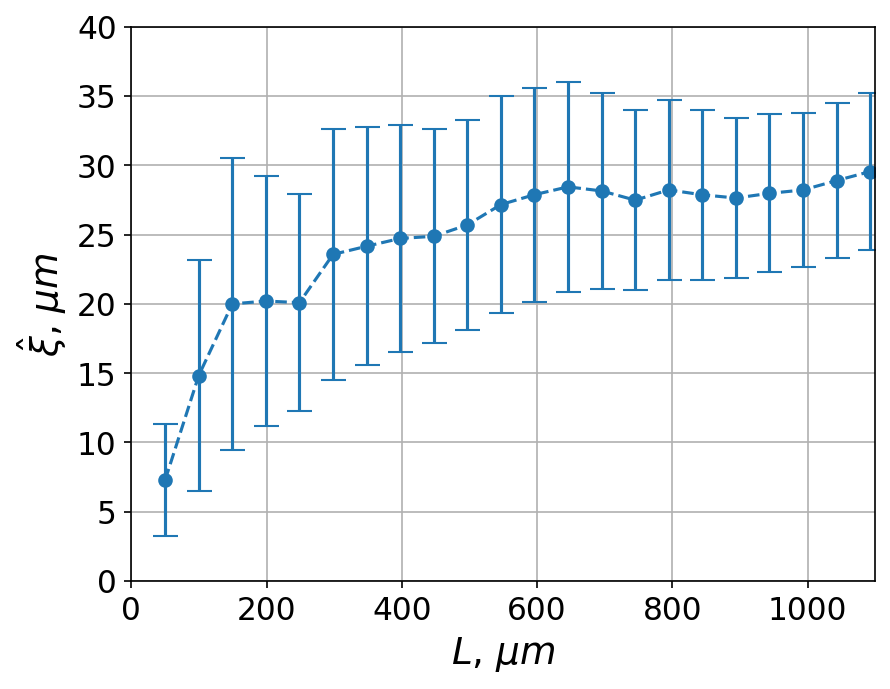

In [100]:
plt.errorbar(X, xiMed, xiErr, capsize=6, marker='o', linestyle='--')
plt.xlabel(r'$L$, $\mu m$', fontsize="18")
plt.ylabel(r'$\hat{\xi}$, $\mu m$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
plt.xlim([0, 1100])
plt.ylim([0, 40])
plt.savefig("./images/xiDataParallelMidErr.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

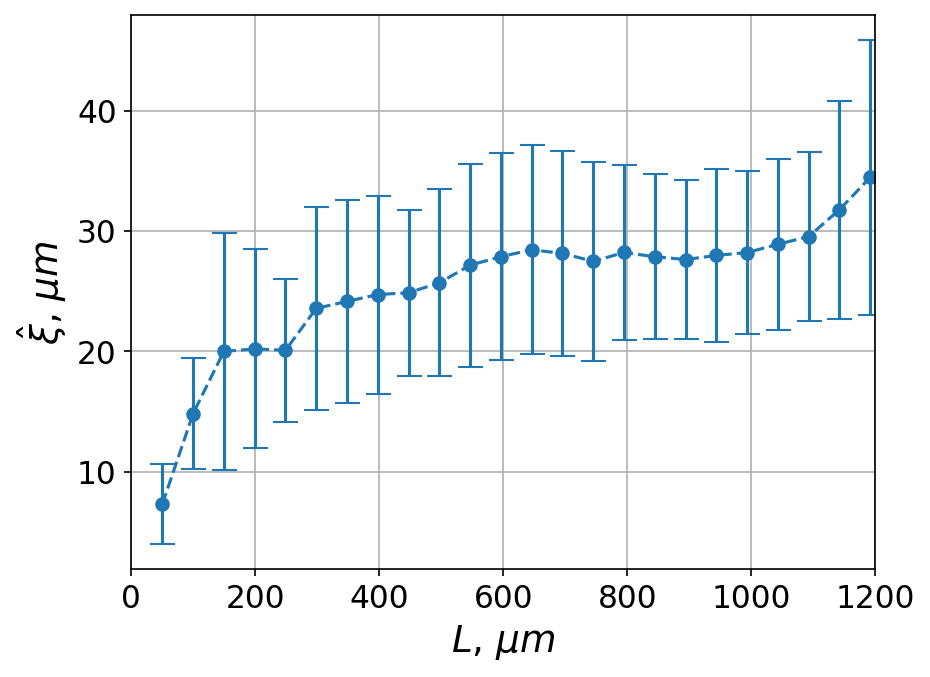

In [38]:
plt.errorbar(X, xiMed, const*xiMAD, capsize=6, marker='o', linestyle='--')
plt.xlabel(r'$L$, $\mu m$', fontsize="18")
plt.ylabel(r'$\hat{\xi}$, $\mu m$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
plt.xlim([0, 1200])
# plt.savefig("./images/xiDataParallelMidDeviation.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

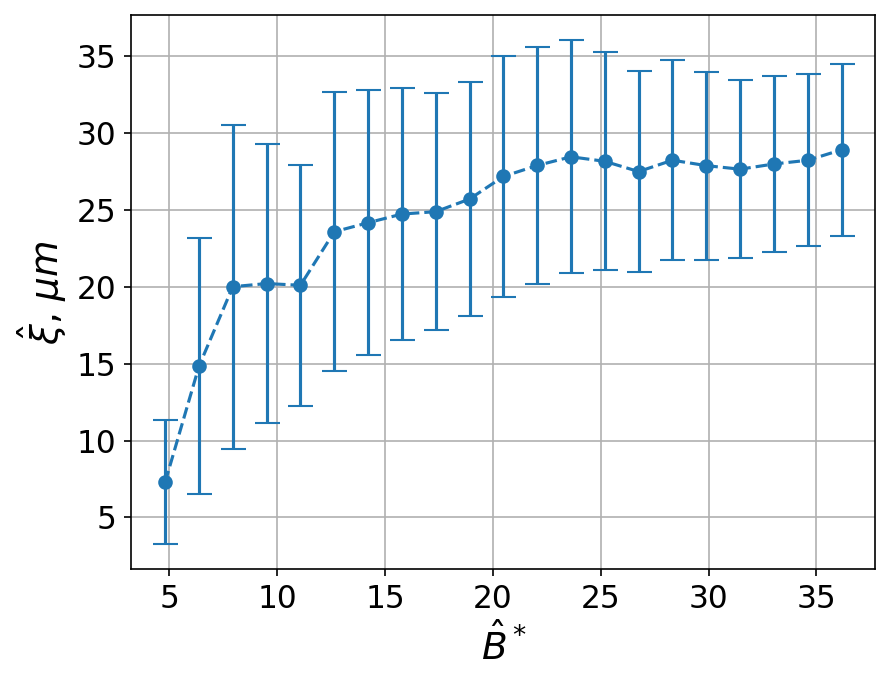

In [22]:
plt.errorbar(BPred, xiMed[:-26], xiErr[:-26], capsize=6, marker='o', linestyle='--')
plt.xlabel(r'$\hat{B}^*$', fontsize="18")
plt.ylabel(r'$\hat{\xi}$, $\mu m$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
plt.savefig("./images/xiDataParallelB.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

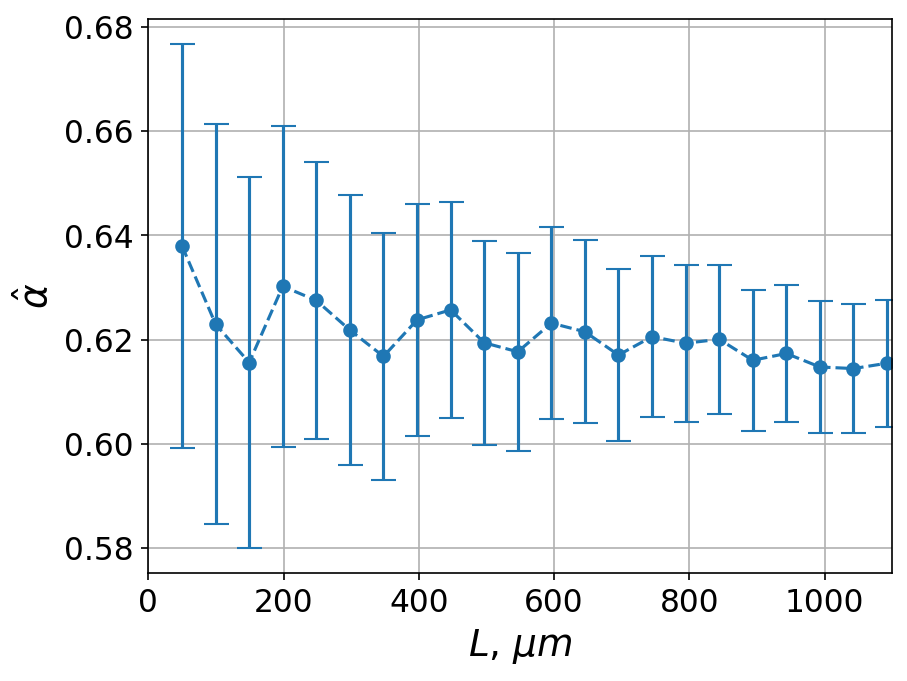

In [115]:
plt.errorbar(X, alphaMed, alphaErr, capsize=6, marker='o', linestyle='--')
plt.xlabel(r'$L$, $\mu m$', fontsize="18")
plt.ylabel(r'$\hat{\alpha}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
plt.xlim([0, 1100])
plt.savefig("./images/alphaDataParallelMidErr.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

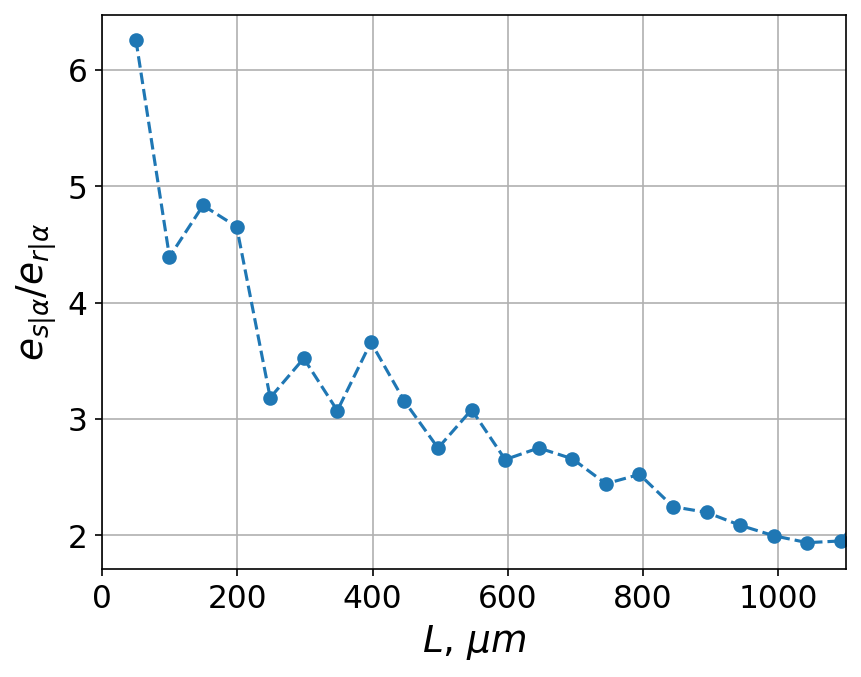

In [27]:
plt.plot(X, alphaErrRatio, marker='o', linestyle='--')
plt.xlabel(r'$L$, $\mu m$', fontsize="18")
plt.ylabel(r'$e_{s|\alpha}/e_{r|\alpha}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
plt.xlim([0, 1100])
plt.savefig("./images/alphaDataParallelErrRatio.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

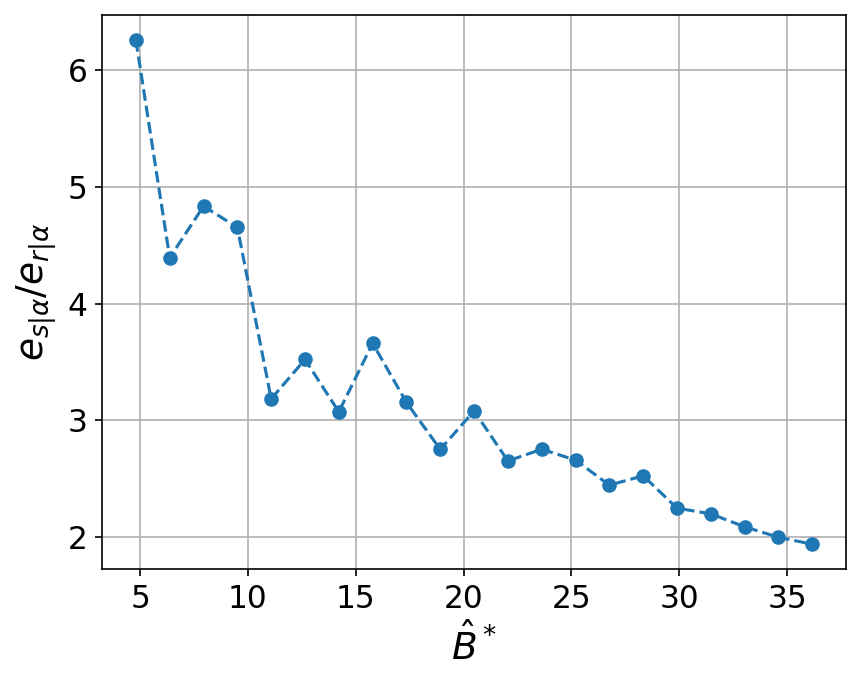

In [23]:
plt.plot(BPred, alphaErrRatio[:-26], marker='o', linestyle='--')
plt.xlabel(r'$\hat{B}^*$', fontsize="18")
plt.ylabel(r'$e_{s|\alpha}/e_{r|\alpha}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
# plt.xlim([0, 1100])
plt.savefig("./images/alphaDataParallelErrRatioB.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

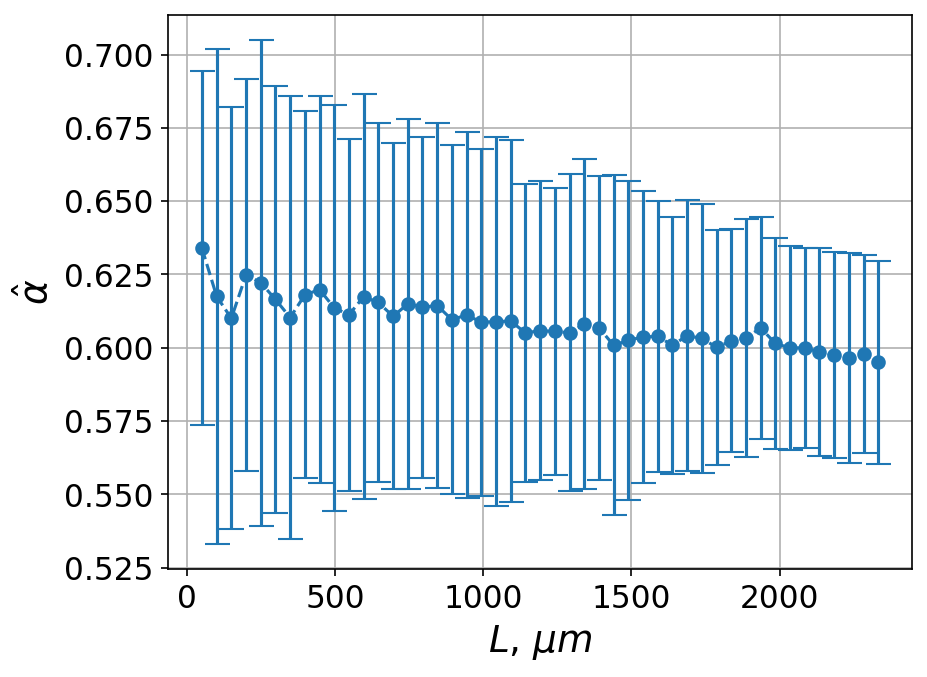

In [44]:
plt.errorbar(X, alphaMed, const*alphaMAD, capsize=6, marker='o', linestyle='--')
plt.xlabel(r'$L$, $\mu m$', fontsize="18")
plt.ylabel(r'$\hat{\alpha}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
plt.savefig("./images/alphaDataParallelStartDeviation.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

In [26]:
print(alphaMed[-26])
print(alphaErr[-26])

0.6154887581723387
0.01214801537578454


In [58]:
f = cp.correctionFactor()
print(f)

0.8883687837633714


In [82]:
f*0.62*(10/53*(np.sqrt(1/35) - 0.06) + 0.12)

0.07742538369262471

In [78]:
(10/53*(np.sqrt(1/35) - 0.06) + 0.12)

0.14057185866900063

In [83]:
np.sqrt(0.08**2 + 0.01**2)

0.0806225774829855

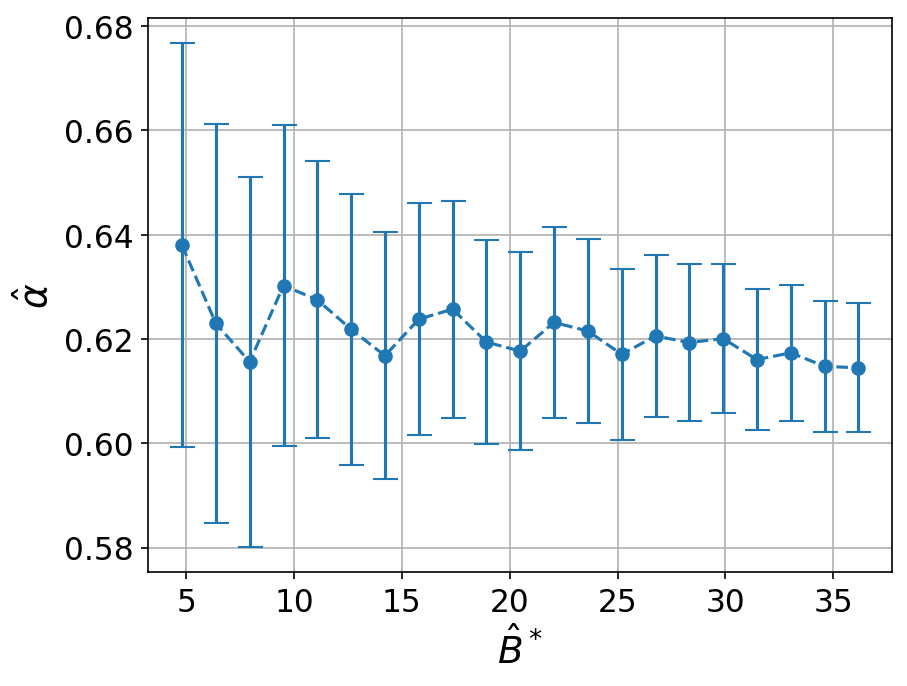

In [27]:
plt.errorbar(BPred, alphaMed[:-26], alphaErr[:-26], capsize=6, marker='o', linestyle='--')
plt.xlabel(r'$\hat{B}^*$', fontsize="18")
plt.ylabel(r'$\hat{\alpha}$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
plt.savefig("./images/alphaDataParallelB.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

In [225]:
iwMed = np.nanmedian(IW, 1)
iwMAD = cp.mad(IW, 1, nan_policy='omit')
iwSTD = np.nanstd(IW, axis=1)

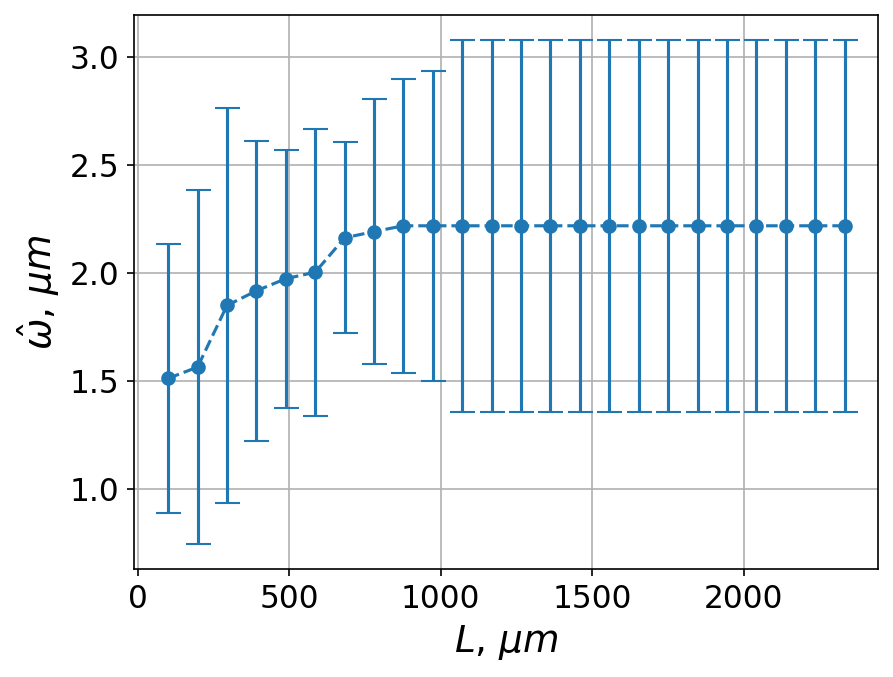

In [227]:
plt.errorbar(X, iwMed, const*iwMAD, capsize=6, marker='o', linestyle='--')
plt.xlabel(r'$L$, $\mu m$', fontsize="18")
plt.ylabel(r'$\hat{\omega}$, $\mu m$', fontsize="18")
plt.tick_params(axis='both', labelsize=15)
plt.grid()
plt.savefig("./images/omegaDataStartDeviation.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

In [29]:
# plt.errorbar(BMed, iwMed, const*iwMAD, capsize=6, marker='o', linestyle='--')
# plt.xlabel(r'$\hat{B}$', fontsize="18")
# plt.ylabel(r'$\hat{\omega}$, $\mu m$', fontsize="18")
# plt.tick_params(axis='both', labelsize=15)
# plt.grid()
# # plt.savefig("./images/xiData.png", format="png", bbox_inches="tight", dpi=300)
# plt.show()